
<font size="20"><h3 align='center'>**_DSL Project_**</font><br>
    
    
<font size="5"><h3 align='center'><span style='color:Blue'> Predict impact of air quality on mortality rates(Kaggle Competition)</font>


<font size="3"><h3 align='center'>https://www.kaggle.com/c/predict-impact-of-air-quality-on-death-rates/overview</font><br>
    <br>


<font size="3">**Group Number - 2**<br>
<font size="3"> Mimansi Agarwal   &emsp;19BM6JP15</font>        
<font size="3"> Vaibhav HK Anand  &emsp;19BM6JP24</font>    
<font size="3"> Bankar Prasad Vilas &emsp;19BM6JP25</font> 


## TO DO

- ANOVA on variables per region
- XGB Regressor
- Best depth via cost pruning for RFR
- Graphs for regulartization 

# Libraries

In [0]:
#!pip install impyute

In [0]:
#!pip freeze > requirements.txt

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from impyute.imputation.cs import mice
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  make_scorer, mean_absolute_error, r2_score, median_absolute_error, mean_squared_error
import math

import missingno as msno

import plotly.express as px
import plotly.graph_objects as go

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

import gc
import random
import os

import scipy.stats as sps 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#plt.style.available

In [0]:
plt.style.use('fivethirtyeight')

# Functions

In [6]:
def seed_everything(SEED=1729):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)
    print('done')

seed_everything()

done


In [0]:
def reduce_mem_usage(df, verbose=True):
    '''
    Reduces the usage of memory by a dataframe
    '''
    start_mem = df.memory_usage().sum() / 2**20
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] #defining a list of numeric types
    #start_mem = df.memory_usage().sum() / 2**20   #converting bytes into MB
    for col in df.columns: # iterating over each column of dataframe
        col_type = df[col].dtypes # extracting the data type of a single column
        if col_type in numerics: # checking whether the data type of column is a numeric datatype or not
            c_min = df[col].min()
            c_max = df[col].max()
          
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype('float16')
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype('float32')
            else:
                df[col] = df[col].astype('float64')    
    end_mem = df.memory_usage().sum() / 2**20
    if verbose: print('Mem. usage decreased to {:5.5f} Mb ({:.2f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
def reg_metrics (y_true,y_predicted):
  mse = mean_squared_error(y_true,y_predicted)
  print("MSE = " + str(mse))
  print("RMSE =" + str(math.sqrt(mse)))
  print("Mean Absolute Error =" + str(mean_absolute_error(y_true,y_predicted)))
  print('Median Absolute Error  = ' + str(median_absolute_error(y_true, y_predicted)))
  print('R^2                    = ' + str(r2_score(y_true, y_predicted)))
  del mse
  gc.collect()

In [0]:
def resid_plot(y_true, y_predicted):
    '''
    1. Plots residual plots by taking the y_true and y_predicted as input.
    2. Can be used with any regression method be it linear, ridge, lasso, boosting-based, etc.
    '''
    temp1 = np.array(y_true).reshape(-1,1)
    temp2 = np.array(y_predicted).reshape(-1,1)

    resids = np.subtract(temp1,temp2) #calculating residuals

    sns.regplot(x=y_predicted, y=resids, fit_reg=True)

    plt.title("Residuals vs. Predicted Values")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")

    plt.show()
    plt.close()
    del temp1, temp2
    gc.collect()

In [0]:
def resids_hist(y_true,y_predicted):
  '''
  Plots histogram of residuals
  '''

  temp1 = np.array(y_true).reshape(-1,1)
  temp2 = np.array(y_predicted).reshape(-1,1)

  resids = np.subtract(temp1,temp2) 

  sns.distplot(resids)

  plt.title("Histogram of Residual Values")
  plt.xlabel("Residuals")
  plt.ylabel("Count")
  del temp1, temp2
  gc.collect()

In [0]:
def resid_qq(y_true, y_predicted):
    resids = np.subtract(np.array(y_true).reshape(-1,1),  np.array(y_predicted).reshape(-1,1))
    sps.probplot(resids.flatten(), plot = plt)
    plt.title('Q-Q Plot of residuals')
    plt.xlabel('Quantiles of standard Normal distribution')
    plt.ylabel('Quantiles of residuals')
    plt.show()

## Regularization

In [0]:
def plot_regularization(l, train_RMSE, test_RMSE, coefs, min_idx, title):   
    plt.plot(l, test_RMSE, color = 'green', label = 'Test RMSE')
    plt.plot(l, train_RMSE, label = 'Train RMSE')    
    plt.axvline(min_idx, color = 'black', linestyle = '--')
    plt.legend()
    plt.xlabel('Regularization parameter')
    plt.ylabel('Root Mean Square Error')
    plt.title(title)
    plt.show()
    
    plt.plot(l, coefs)
    plt.axvline(min_idx, color = 'black', linestyle = '--')
    plt.title('Model coefficient values \n vs. regularizaton parameter')
    plt.xlabel('Regularization parameter')
    plt.ylabel('Model coefficient value')
    plt.show()

In [0]:
def test_regularization_l2(x_train, y_train, x_test, y_test, l2):
    train_RMSE = []
    test_RMSE = []
    coefs = []
    for reg in l2:
        lin_mod = Ridge(alpha = reg)
        lin_mod.fit(x_train, y_train)
        coefs.append(lin_mod.coef_)
        y_score_train = lin_mod.predict(x_train)
        train_RMSE.append(mean_squared_error(y_train, y_score_train)**0.5)
        y_score = lin_mod.predict(x_test)
        test_RMSE.append(mean_squared_error(y_test, y_score)**0.5)
    min_idx = np.argmin(test_RMSE)
    min_l2 = l2[min_idx]
    min_RMSE = test_RMSE[min_idx] 
    
    title = 'Train and test root mean square error \n vs. regularization parameter'
    plot_regularization(l2, train_RMSE, test_RMSE, coefs, min_l2, title)
    return min_l2, min_RMSE

In [0]:
def ridge(X_train,y_train, X_test, y_test):
  l2 = [x for x in range(0,50)]
  out_l2 = test_regularization_l2(X_train, y_train, X_test, y_test, l2)
  print(out_l2)
  lin_mod_l2 = Ridge(alpha = out_l2[0])
  lin_mod_l2.fit(X_train, y_train)
  y_score_l2 = lin_mod_l2.predict(X_test)
  print()
  reg_metrics(y_test, y_score_l2)
  resids_hist(np.array(y_test), np.array(y_score_l2))  
  resid_qq(np.array(y_test), np.array(y_score_l2)) 
  resid_plot(np.array(y_test), np.array(y_score_l2))

In [0]:
def test_regularization_l1(x_train, y_train, x_test, y_test, l1):
    train_RMSE = []
    test_RMSE = []
    coefs = []
    for reg in l1:
        lin_mod = Lasso(alpha = reg)
        lin_mod.fit(x_train, y_train)
        coefs.append(lin_mod.coef_)
        y_score_train = lin_mod.predict(x_train)
        train_RMSE.append(mean_squared_error(y_train, y_score_train)**0.5)
        y_score = lin_mod.predict(x_test)
        test_RMSE.append(mean_squared_error(y_test, y_score)**0.5)
    min_idx = np.argmin(test_RMSE)
    min_l1 = l1[min_idx]
    min_RMSE = test_RMSE[min_idx]
    
    title = 'Train and test root mean square error \n vs. regularization parameter'
    plot_regularization(l1, train_RMSE, test_RMSE, coefs, min_l1, title)
    return min_l1, min_RMSE

In [0]:
def lasso(X_train,y_train,X_test,y_test):
    l1 = [x/5000 for x in range(1,50)]
    out_l1 = test_regularization_l1(X_train, y_train, X_test, y_test, l1)
    print(out_l1)
    lin_mod_l1 = Lasso(alpha = out_l1[0])
    lin_mod_l1.fit(X_train, y_train)
    y_score_l1 = lin_mod_l1.predict(X_test)
    print()
    reg_metrics(y_test, y_score_l1) 
    resids_hist(np.array(y_test), np.array(y_score_l1))
    resid_qq(np.array(y_test), np.array(y_score_l1)) 
    resid_plot(np.array(y_test), np.array(y_score_l1))

# Data import

In [0]:
train = pd.read_csv('/content/train.csv', parse_dates=['date'], index_col='Id')
test = pd.read_csv('/content/test.csv', parse_dates=['date'], index_col='Id')
region=pd.read_csv('/content/regions.csv')

In [17]:
train.head()

region       date  mortality_rate      O3   PM10  PM25  NO2      T2M
Id                                                                         
1   E12000001 2007-01-02           2.264  42.358  9.021   NaN  NaN  278.138
2   E12000001 2007-01-03           2.030  49.506  5.256   NaN  NaN  281.745
3   E12000001 2007-01-04           1.874  51.101  4.946   NaN  NaN  280.523
4   E12000001 2007-01-05           2.069  47.478  6.823   NaN  NaN  280.421
5   E12000001 2007-01-06           1.913  45.226  7.532   NaN  NaN  278.961

# Exploratory data analysis

In [0]:
#train = reduce_mem_usage(train)
#test = reduce_mem_usage(test)

In [19]:
region

Code                    Region
0  E12000001                North East
1  E12000002                North West
2  E12000003  Yorkshire and The Humber
3  E12000004             East Midlands
4  E12000005             West Midlands
5  E12000006           East of England
6  E12000007                    London
7  E12000008                South East
8  E12000009                South West

In [20]:
# Checking that the date column is monotonic
for r in train['region'].unique():
  print(train[train['region']==r]['date'].is_monotonic)
del r

True
True
True
True
True
True
True
True
True


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18403 entries, 1 to 18403
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   region          18403 non-null  object        
 1   date            18403 non-null  datetime64[ns]
 2   mortality_rate  18403 non-null  float64       
 3   O3              18394 non-null  float64       
 4   PM10            18394 non-null  float64       
 5   PM25            15127 non-null  float64       
 6   NO2             11833 non-null  float64       
 7   T2M             18403 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.3+ MB


In [22]:
train.describe()

mortality_rate            O3  ...           NO2           T2M
count    18403.000000  18394.000000  ...  11833.000000  18403.000000
mean         1.301737     45.325857  ...     12.045813    283.002235
std          0.304161     16.221330  ...      8.296675      5.182186
min          0.439000      0.988000  ...      1.104000    265.562000
25%          1.102000     35.074250  ...      6.056000    279.321500
50%          1.281000     45.836000  ...      9.769000    283.270000
75%          1.474000     55.881000  ...     15.858000    287.240500
max          2.841000    105.693000  ...     76.765000    297.209000

[8 rows x 6 columns]

In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7886 entries, 18404 to 26289
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   region  7886 non-null   object        
 1   date    7886 non-null   datetime64[ns]
 2   O3      7886 non-null   float64       
 3   PM10    7886 non-null   float64       
 4   PM25    7886 non-null   float64       
 5   NO2     7886 non-null   float64       
 6   T2M     7886 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 492.9+ KB


In [24]:
test.describe()

O3         PM10         PM25          NO2          T2M
count  7886.000000  7886.000000  7886.000000  7886.000000  7886.000000
mean     49.527998    14.545470     8.749311    13.140902   283.410366
std      16.086797     7.660908     6.437121     8.848008     5.274034
min       1.559000     2.506000     0.850000     1.386000   268.696000
25%      39.843000     9.467250     4.620250     6.732750   279.458500
50%      50.935500    12.364000     6.810000    10.627500   283.518000
75%      60.379000    17.353750    10.872000    16.864750   287.707250
max     103.718000    67.361000    56.717000    67.063000   296.740000

In [25]:
region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Code    9 non-null      object
 1   Region  9 non-null      object
dtypes: object(2)
memory usage: 272.0+ bytes


## Missing Values

In [26]:
train.isna().sum()

region               0
date                 0
mortality_rate       0
O3                   9
PM10                 9
PM25              3276
NO2               6570
T2M                  0
dtype: int64

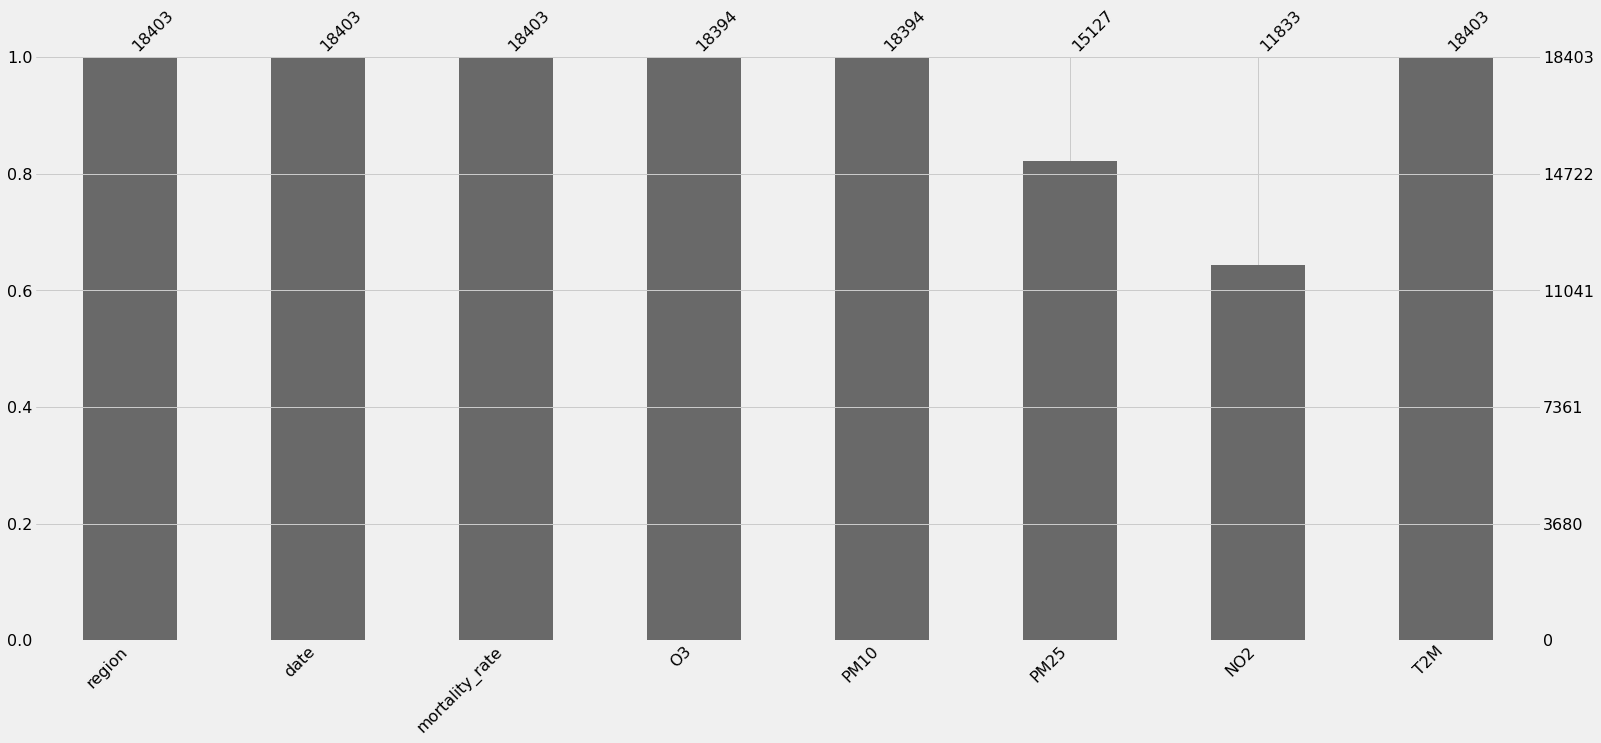

In [27]:
msno.bar(train)

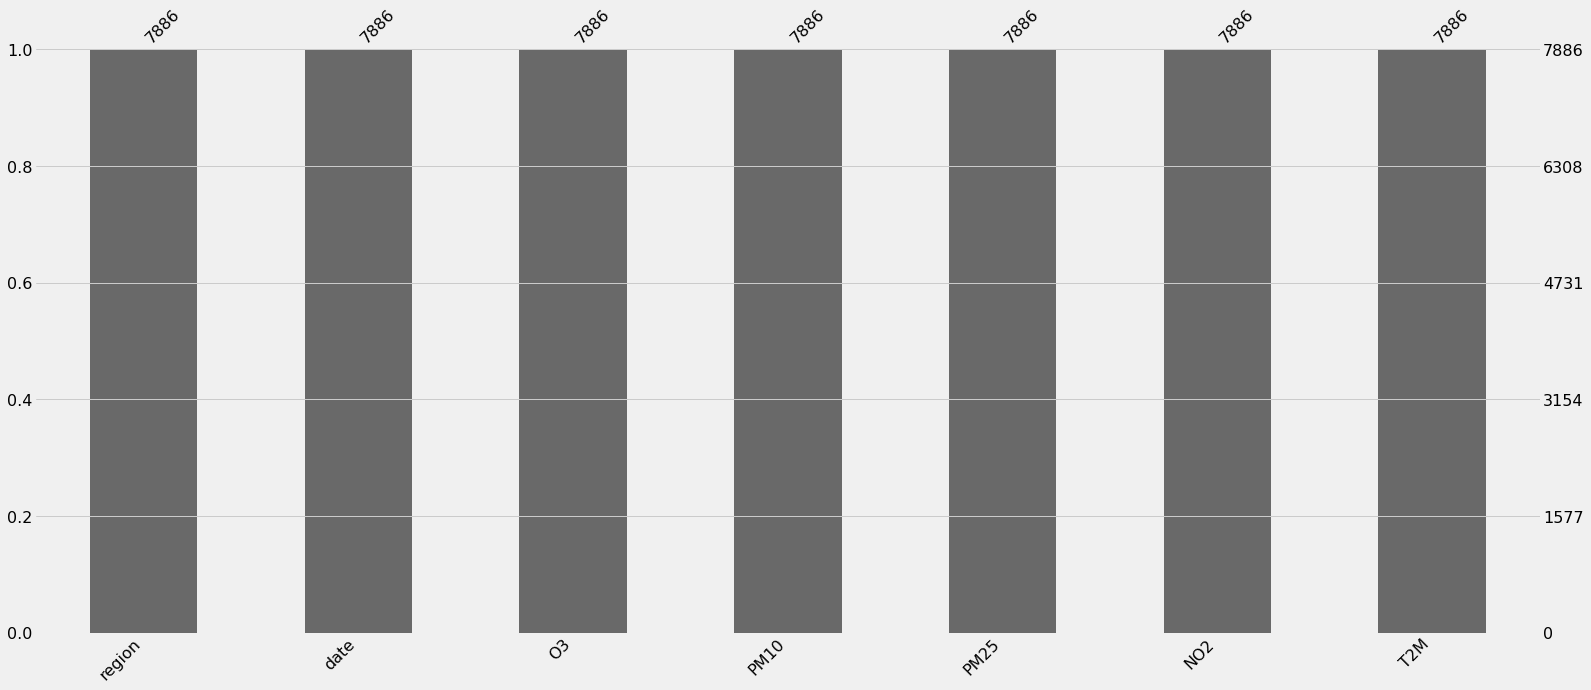

In [28]:
msno.bar(test)

# No missing values

AxesSubplot(0.08,0.07;0.784255x0.81)
AxesSubplot(0.08,0.07;0.784255x0.81)
AxesSubplot(0.08,0.07;0.784255x0.81)
AxesSubplot(0.08,0.07;0.784255x0.81)
AxesSubplot(0.08,0.07;0.784255x0.81)
AxesSubplot(0.08,0.07;0.784255x0.81)
AxesSubplot(0.08,0.07;0.784255x0.81)
AxesSubplot(0.08,0.07;0.784255x0.81)
AxesSubplot(0.08,0.07;0.784255x0.81)


10

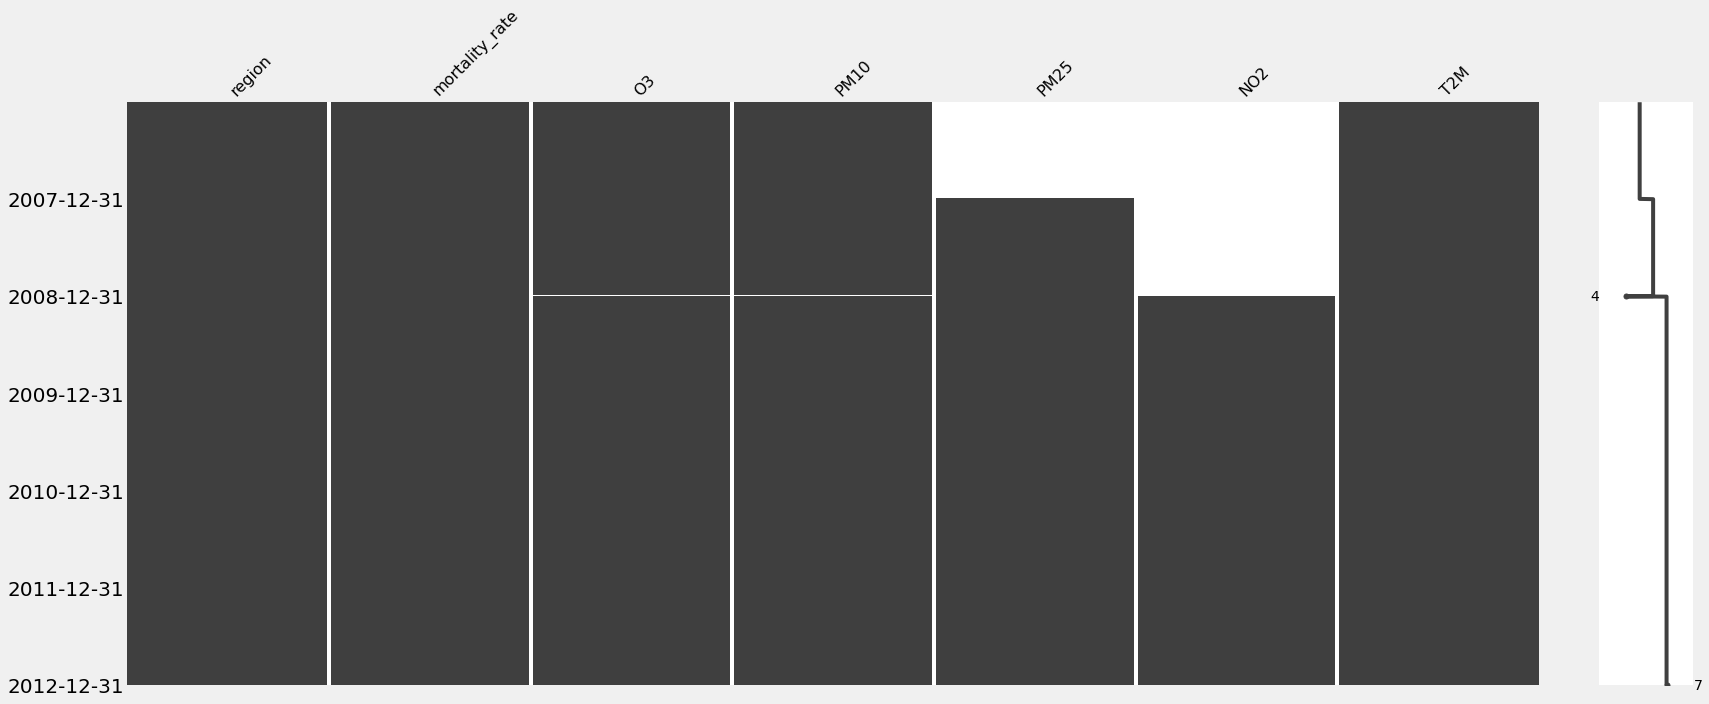

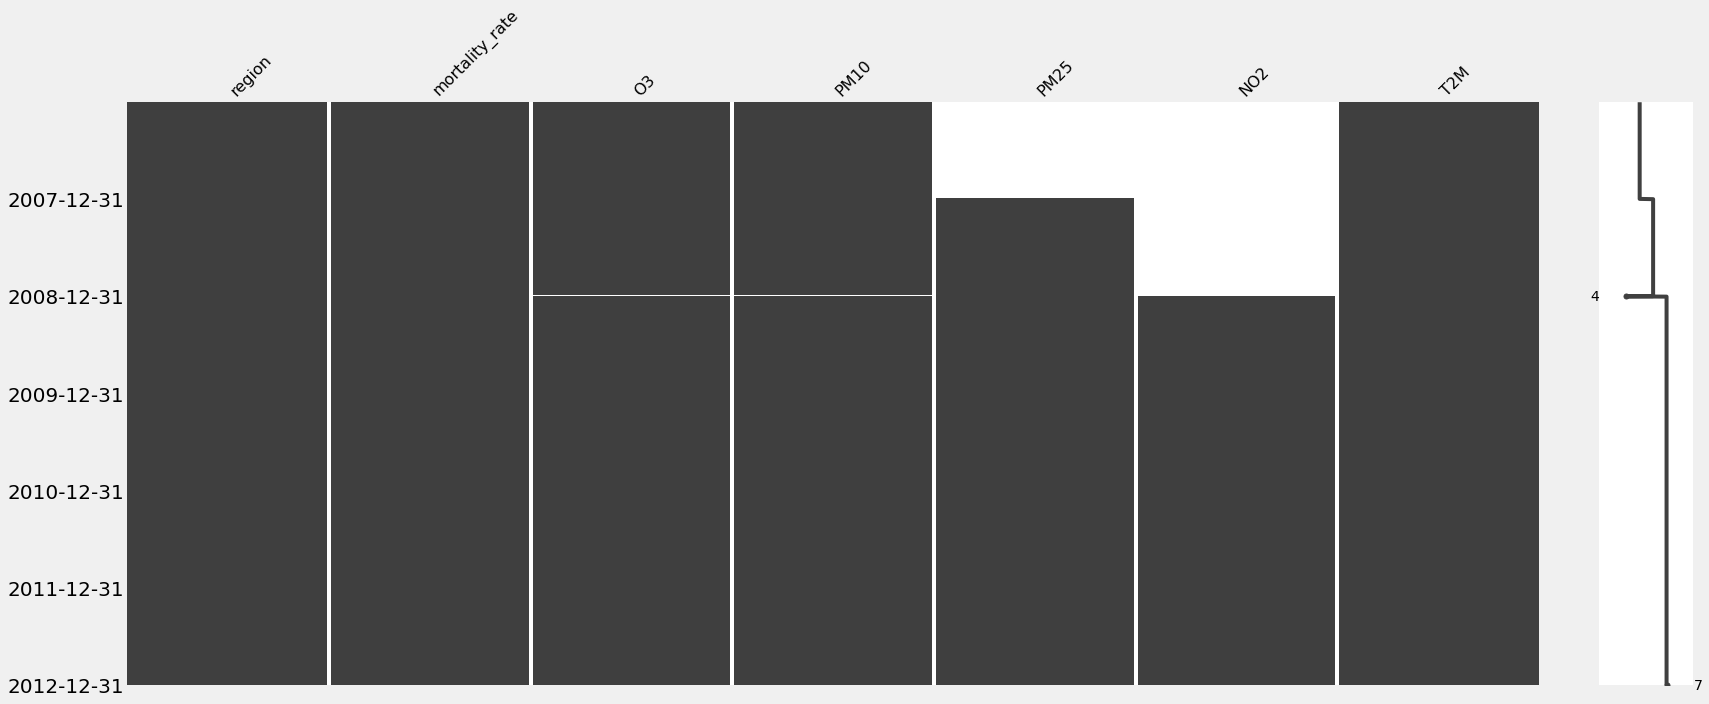

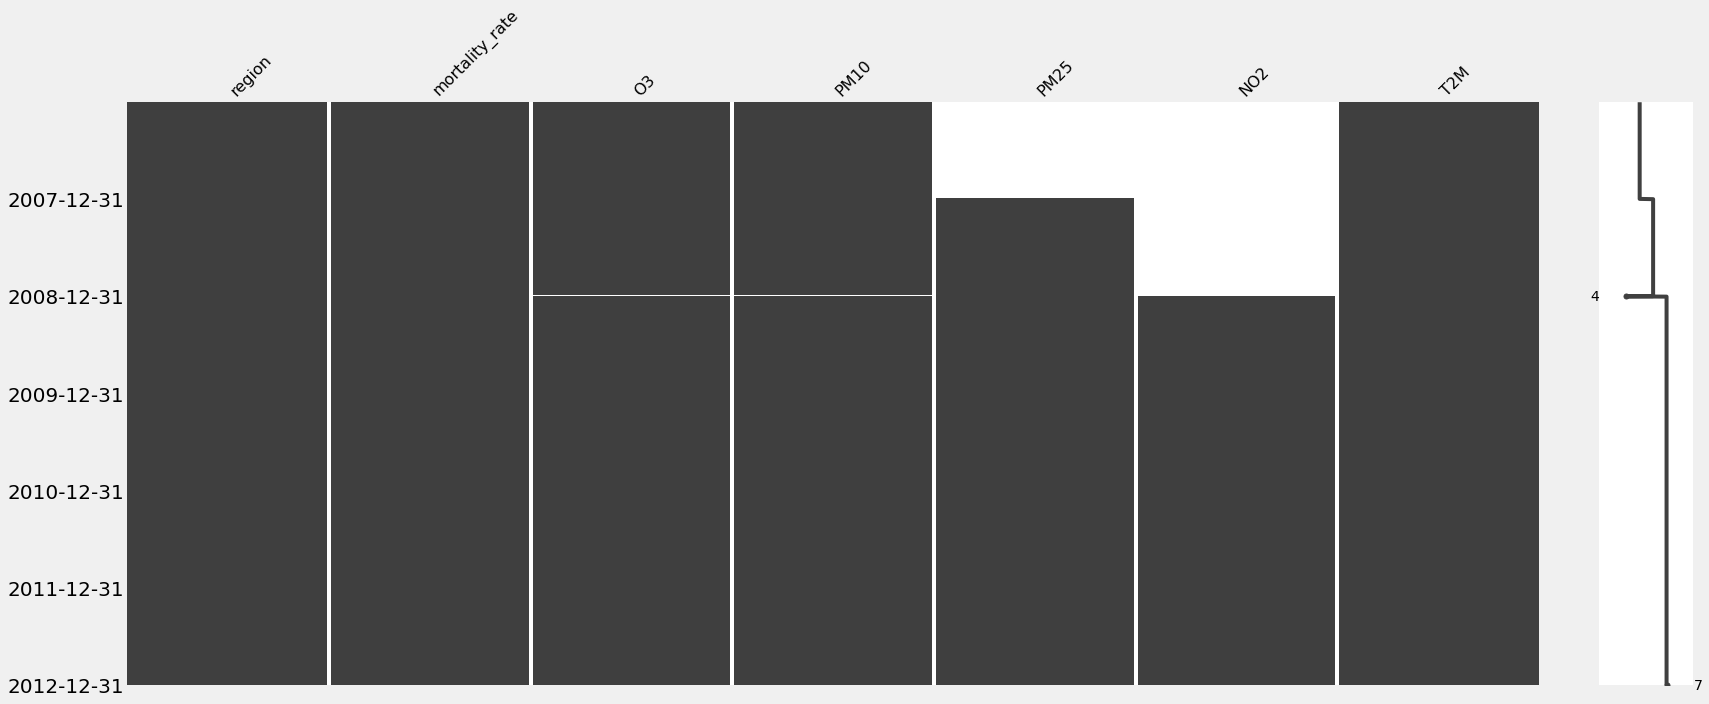

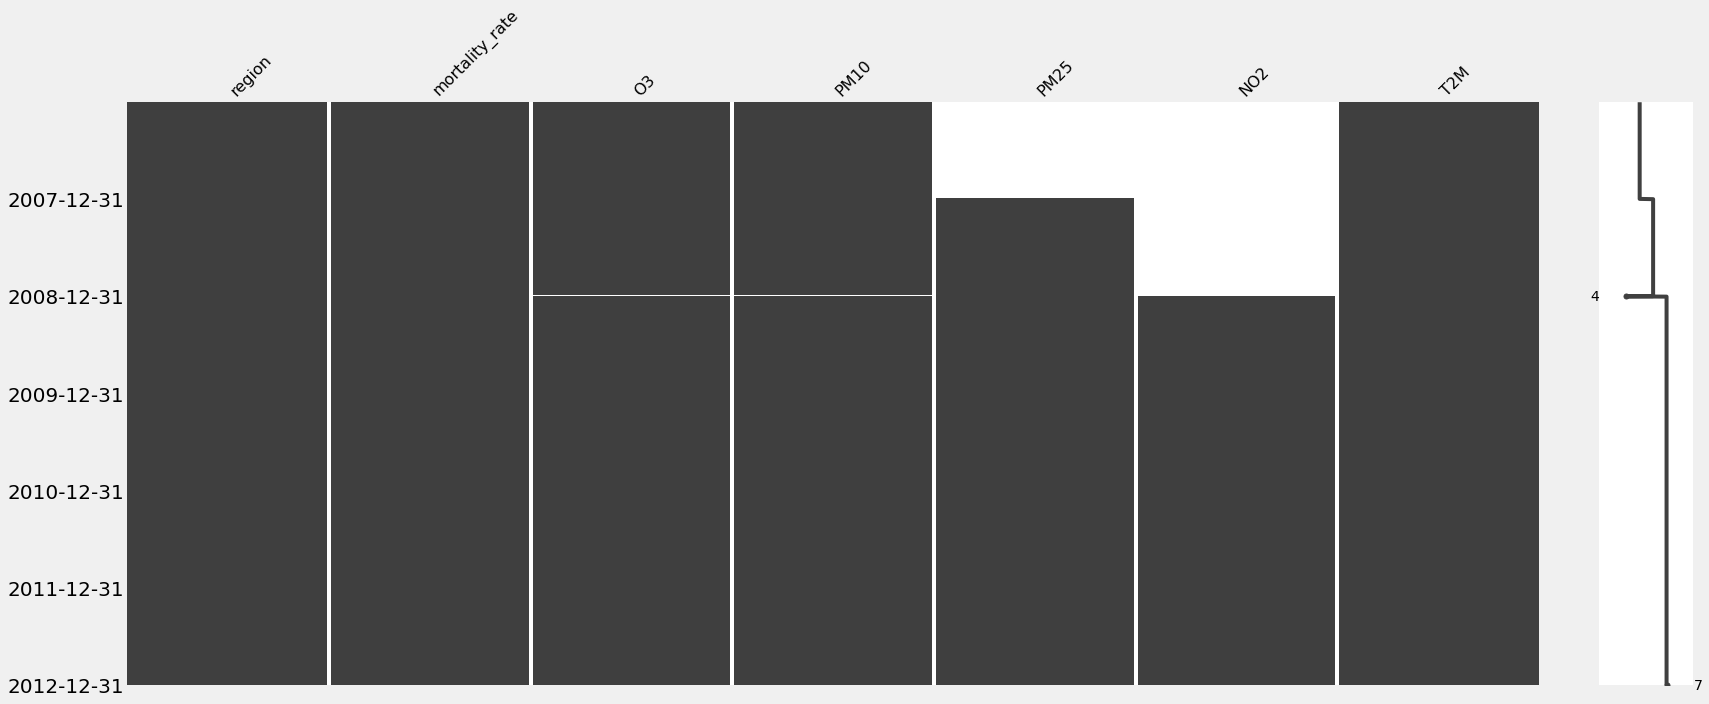

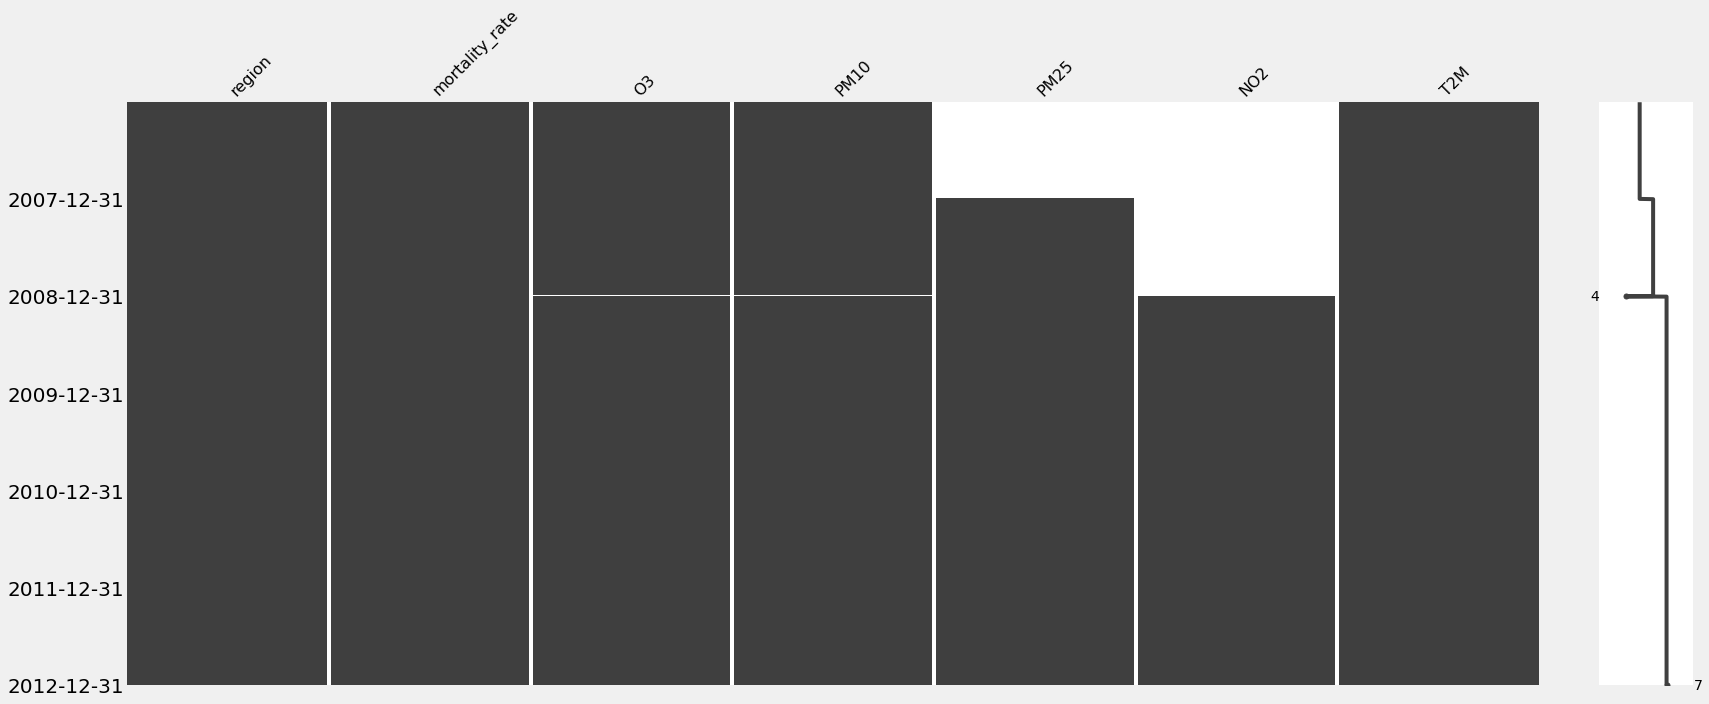

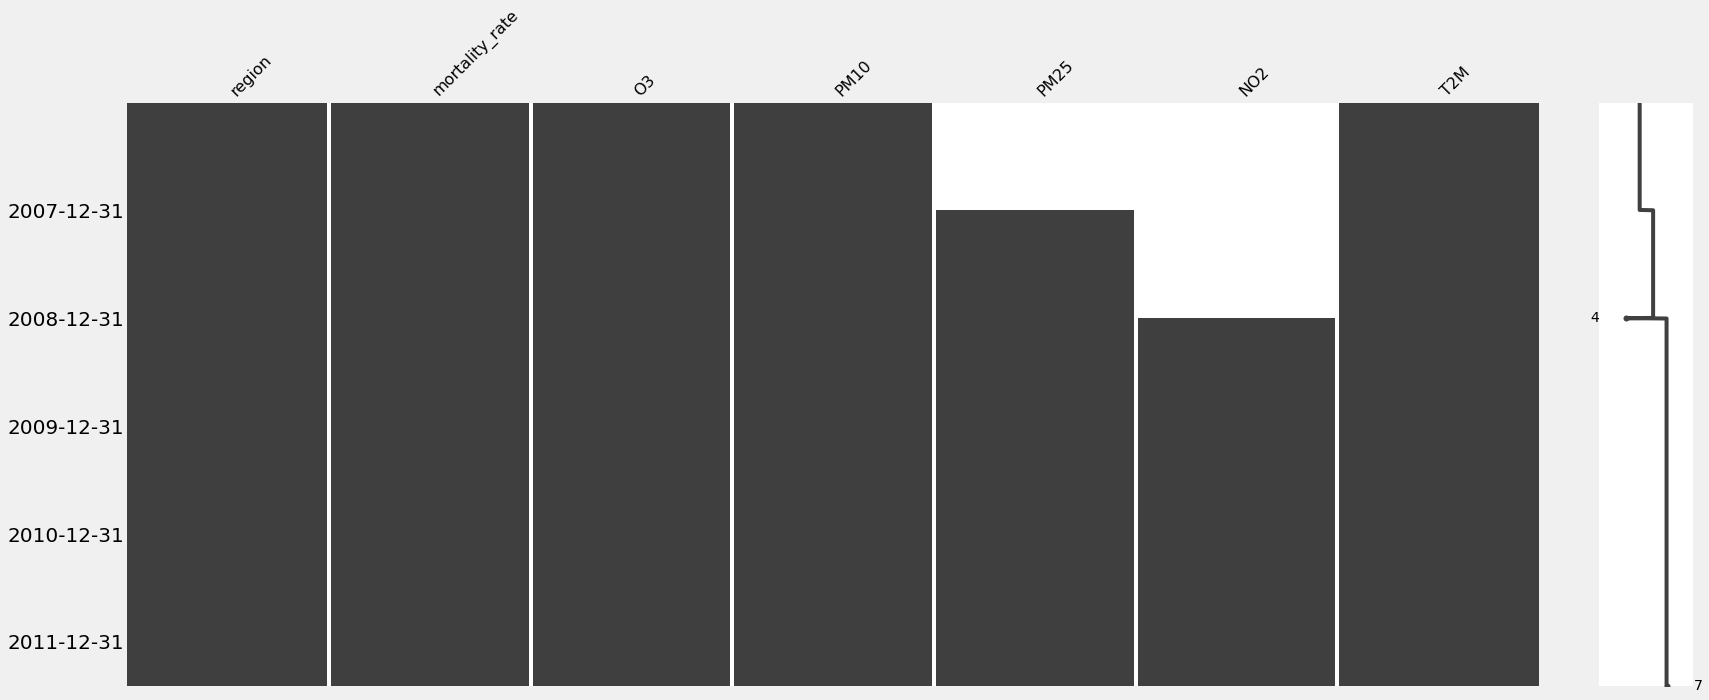

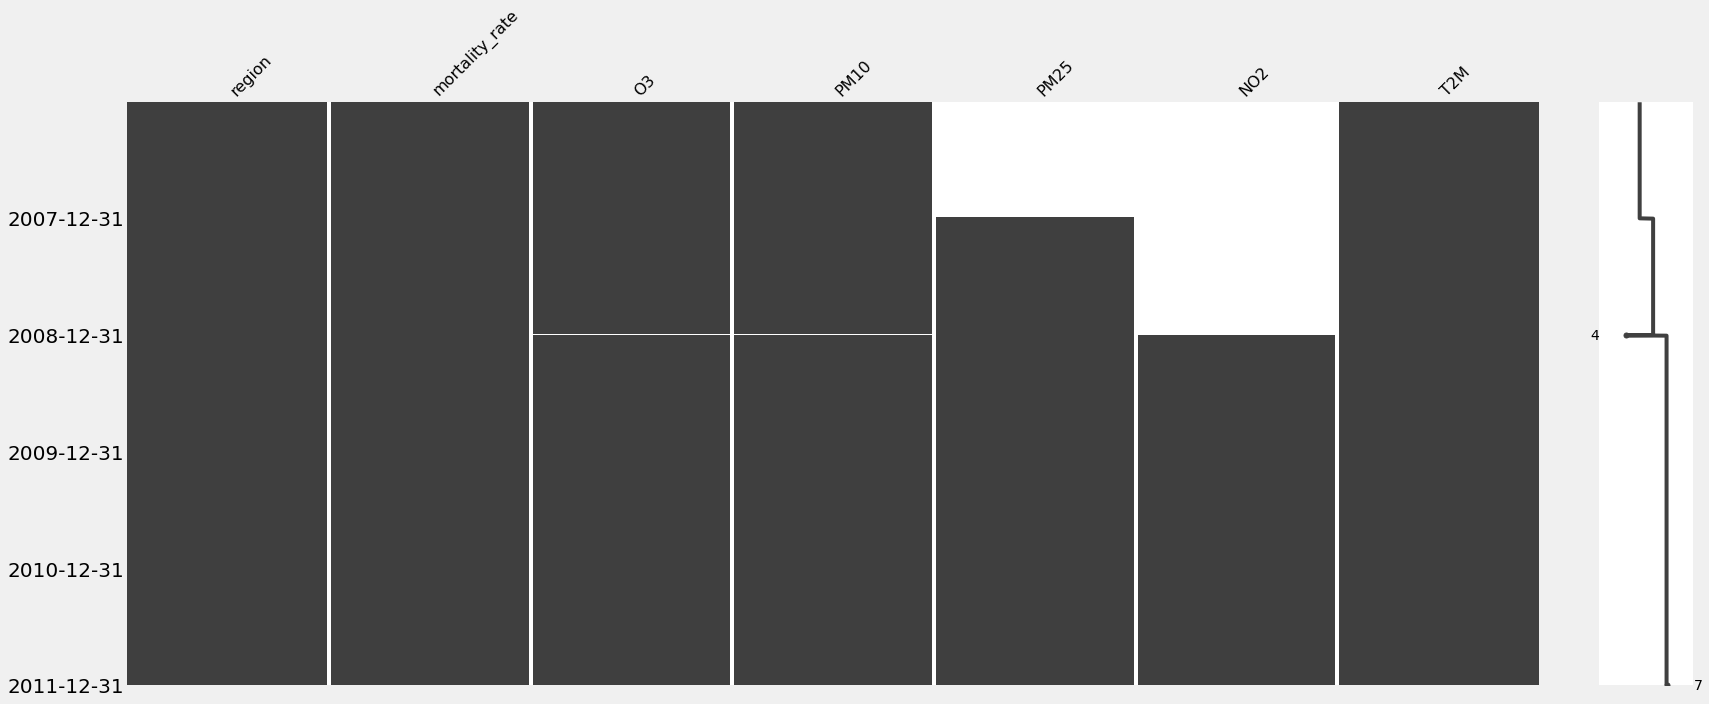

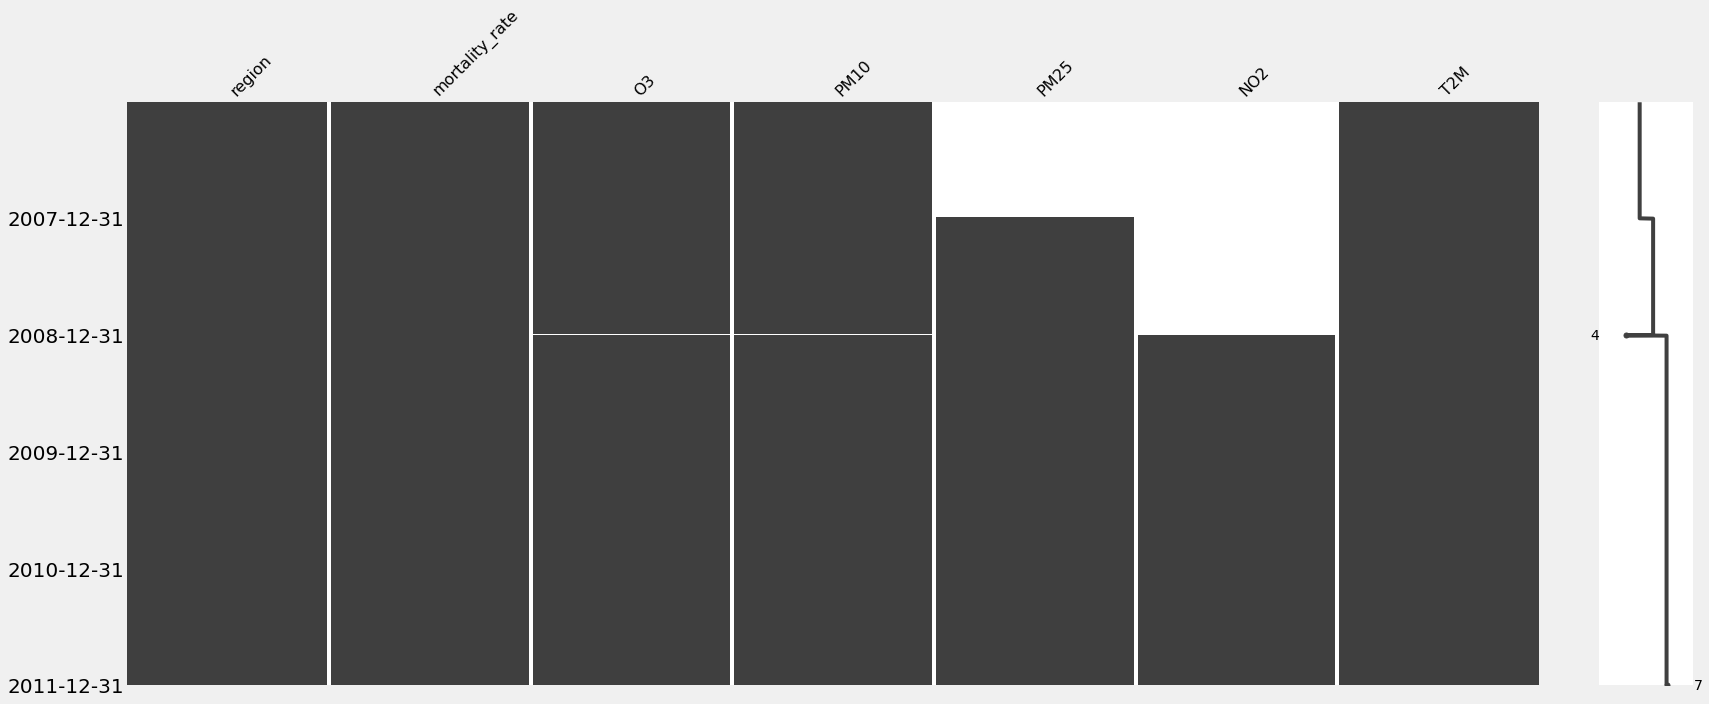

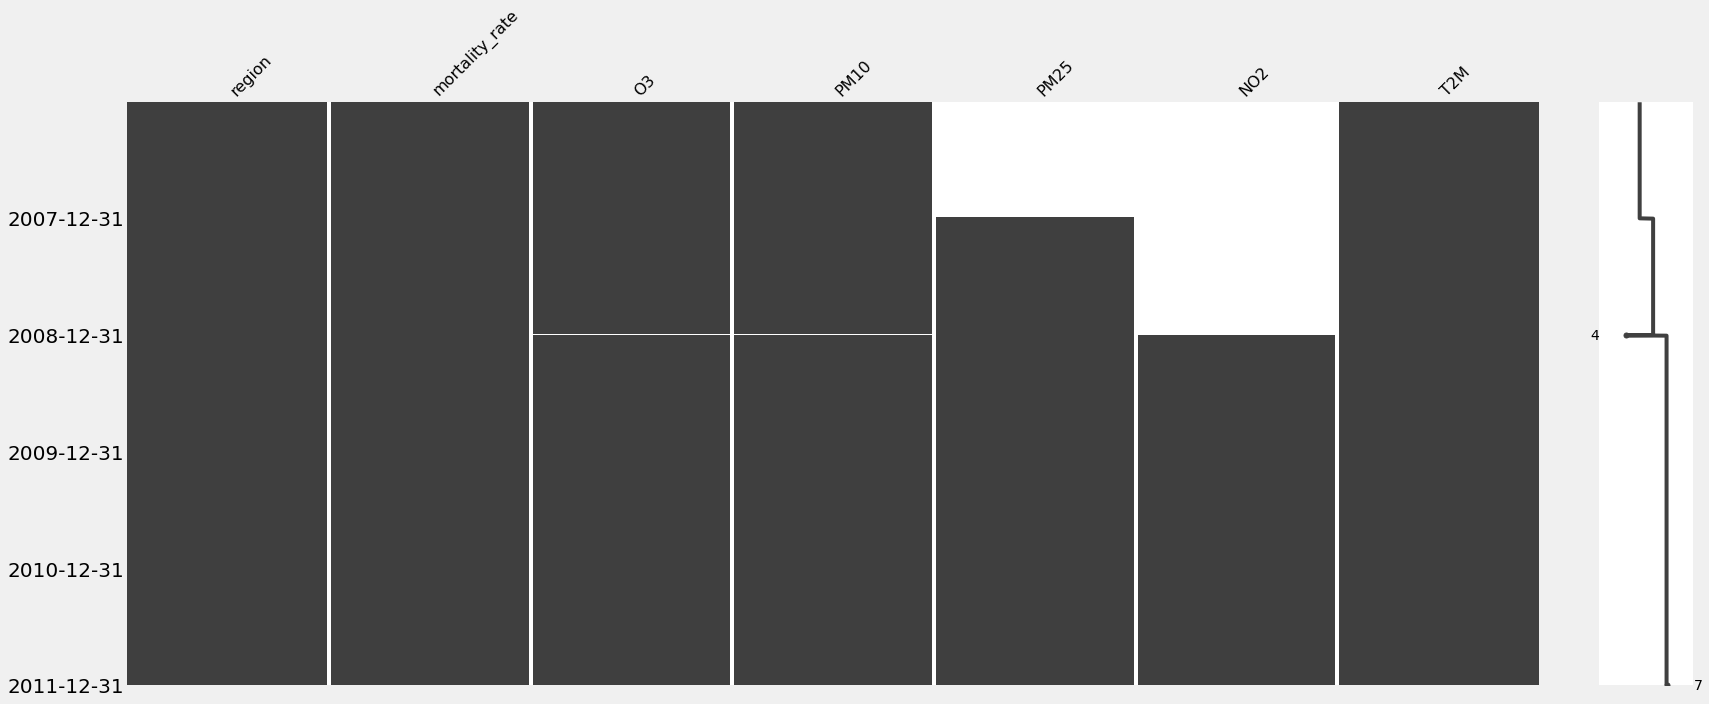

In [29]:
temp = train.set_index('date')

for r in train['region'].unique():
  t = temp[temp['region']==r]
  print(msno.matrix(t, freq = 'A'))

del temp, t
gc.collect()

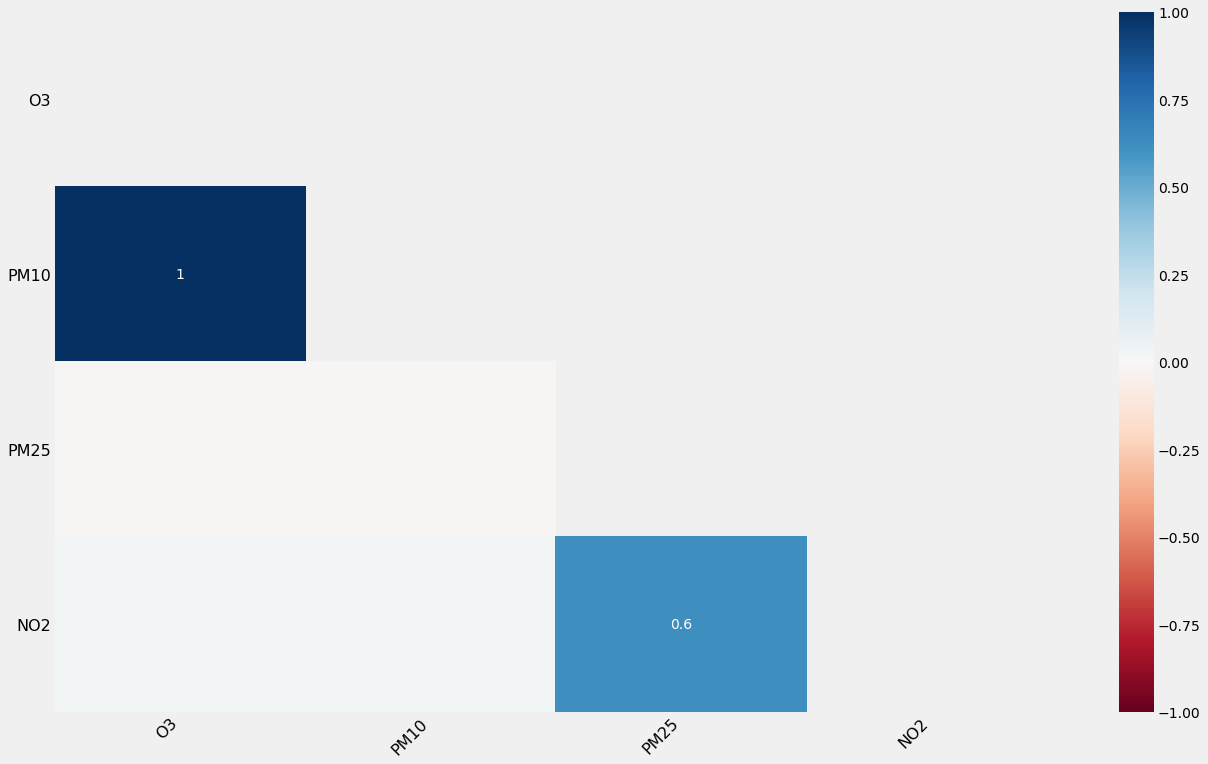

In [30]:
msno.heatmap(train)

# https://github.com/ResidentMario/missingno

# correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another
# Variables that are always full or always empty have no meaningful correlation, and so are silently removed from the visualization—in this case for instance the datetime and injury number columns, which are completely filled, are not included.

AxesSubplot(0.08,0.07;0.696x0.81)
AxesSubplot(0.08,0.07;0.696x0.81)
AxesSubplot(0.08,0.07;0.696x0.81)
AxesSubplot(0.08,0.07;0.696x0.81)
AxesSubplot(0.08,0.07;0.696x0.81)
AxesSubplot(0.08,0.07;0.696x0.81)
AxesSubplot(0.08,0.07;0.696x0.81)
AxesSubplot(0.08,0.07;0.696x0.81)
AxesSubplot(0.08,0.07;0.696x0.81)


38160

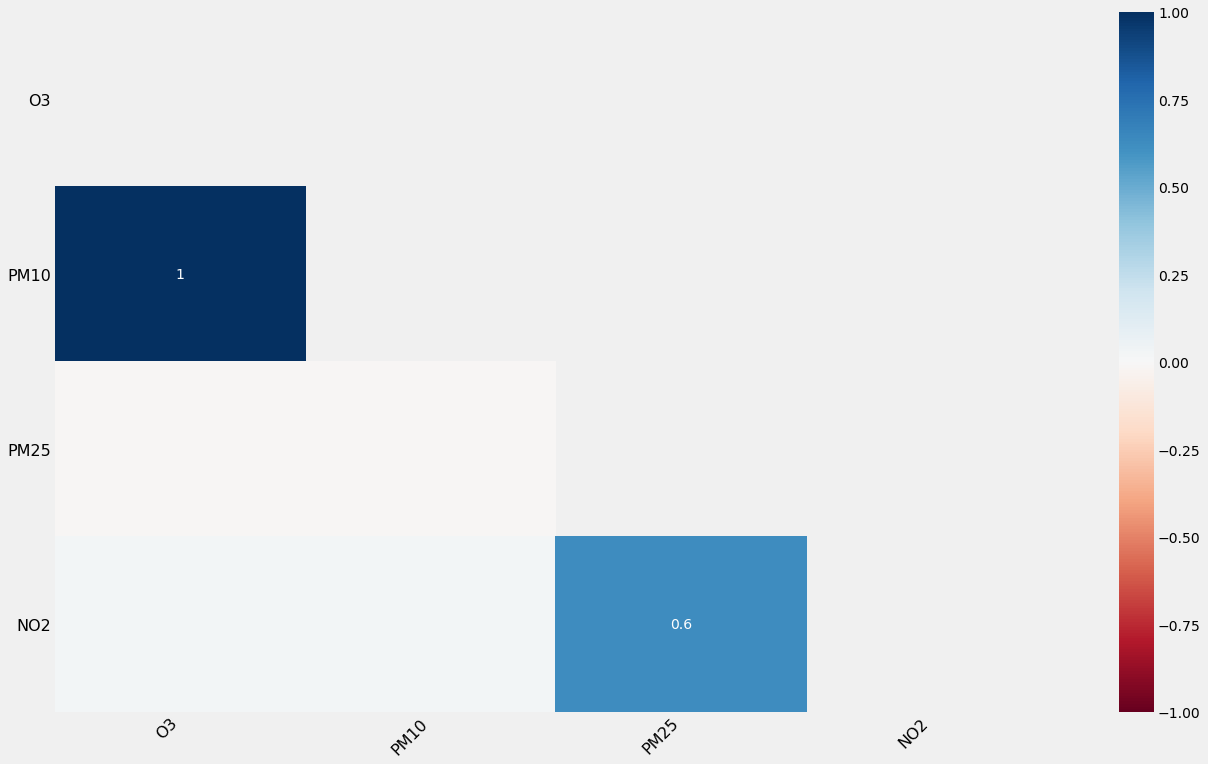

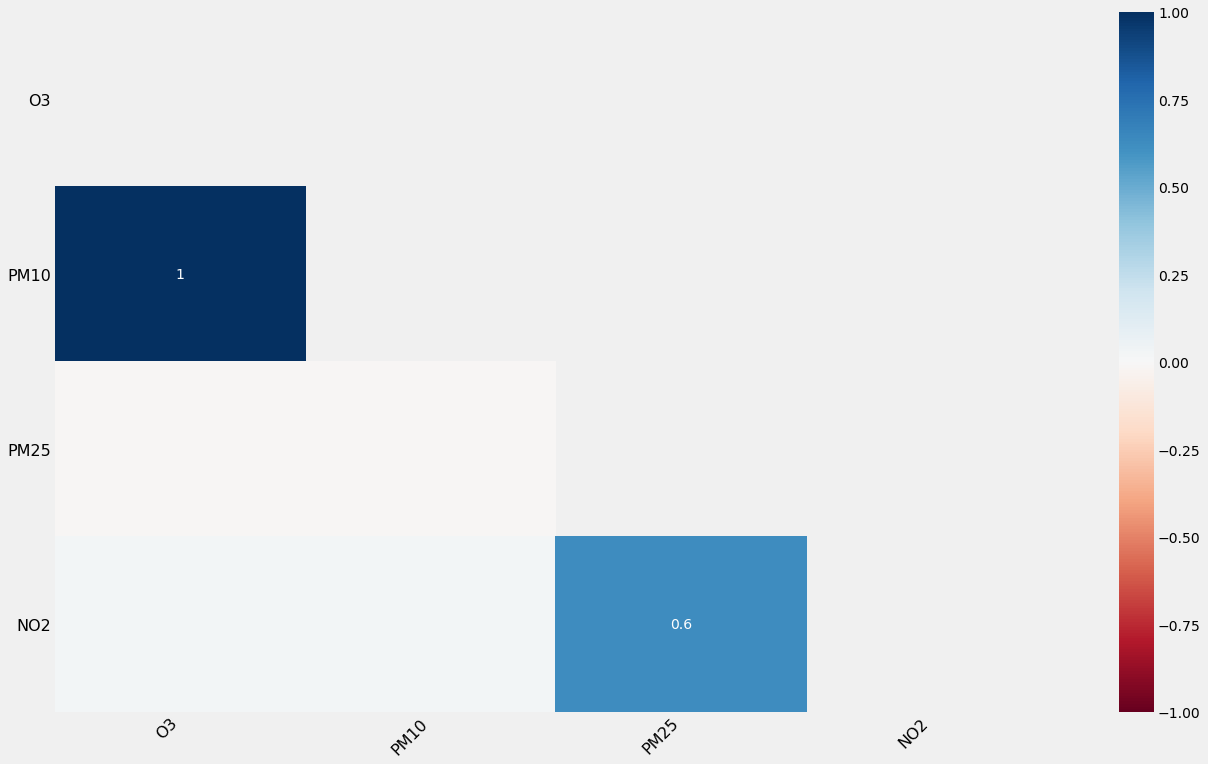

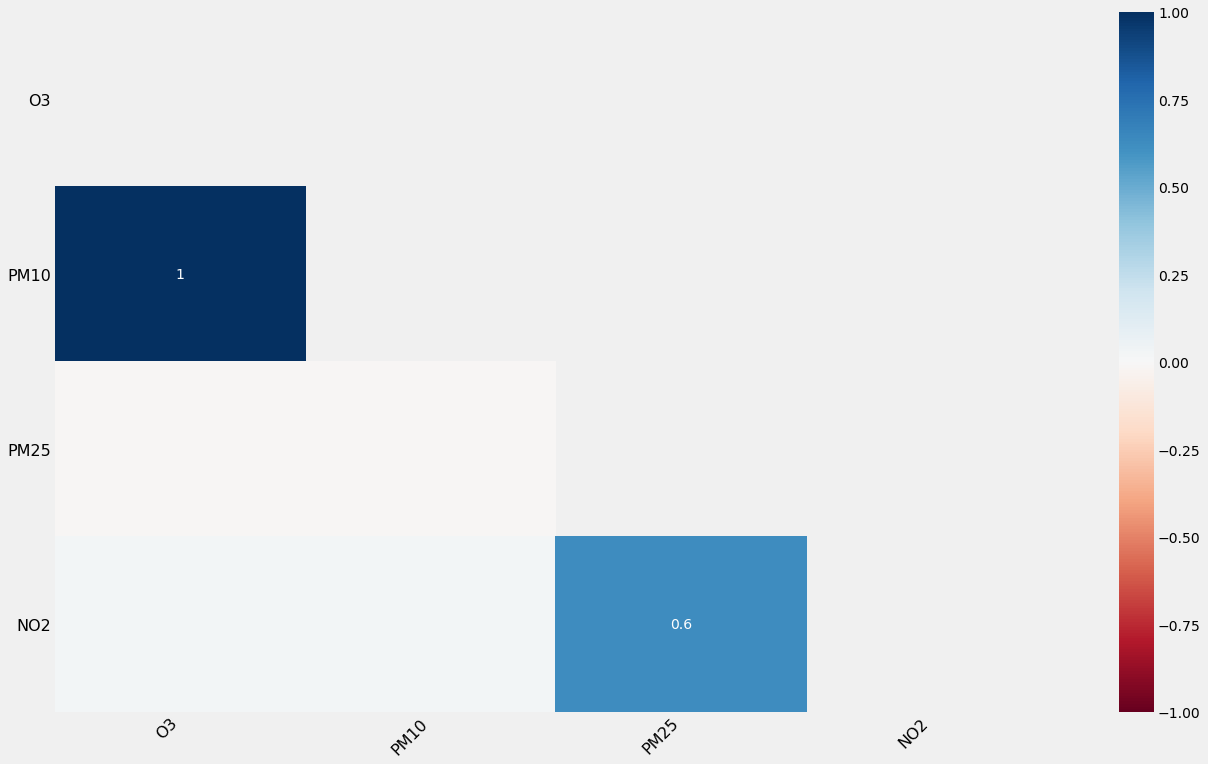

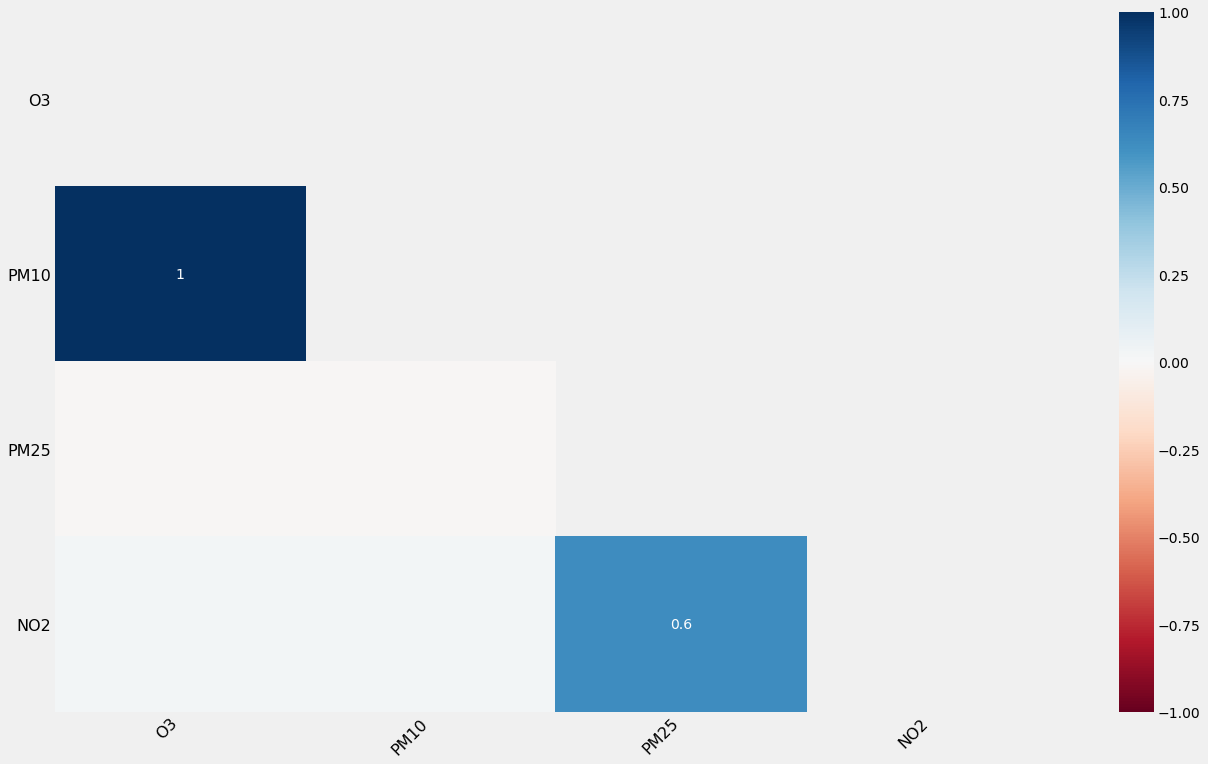

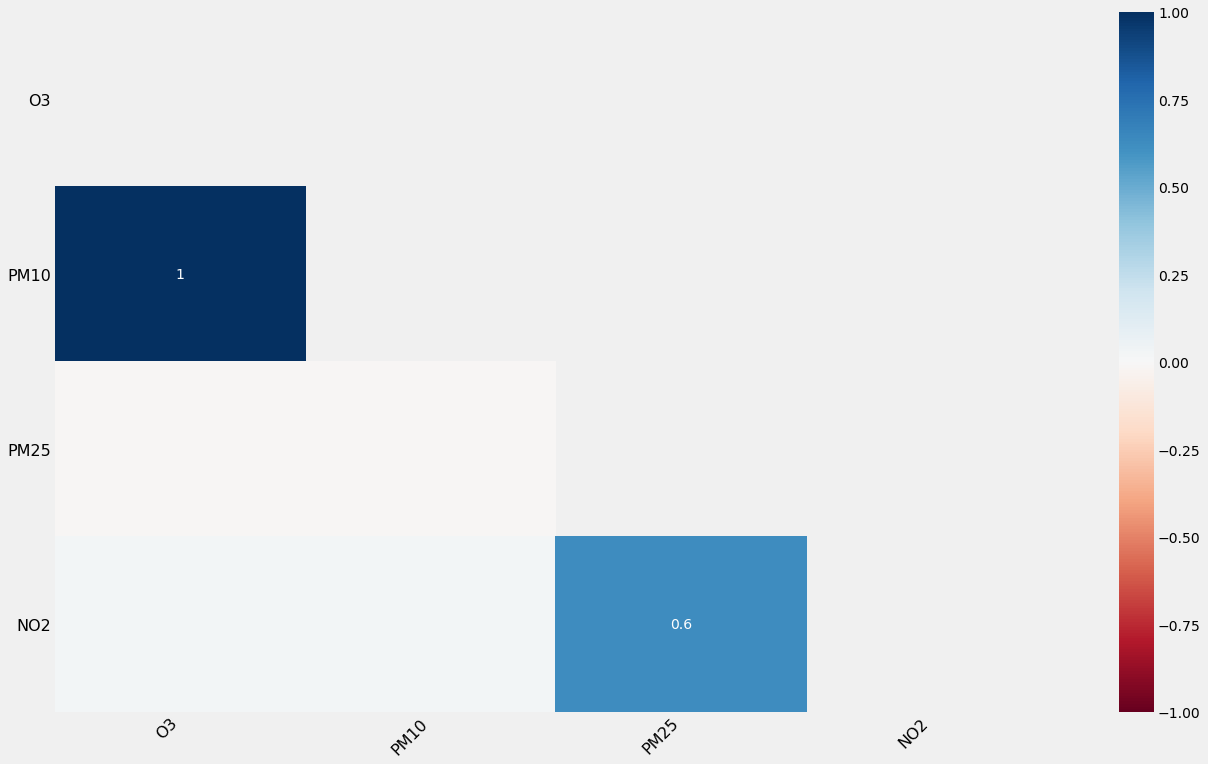

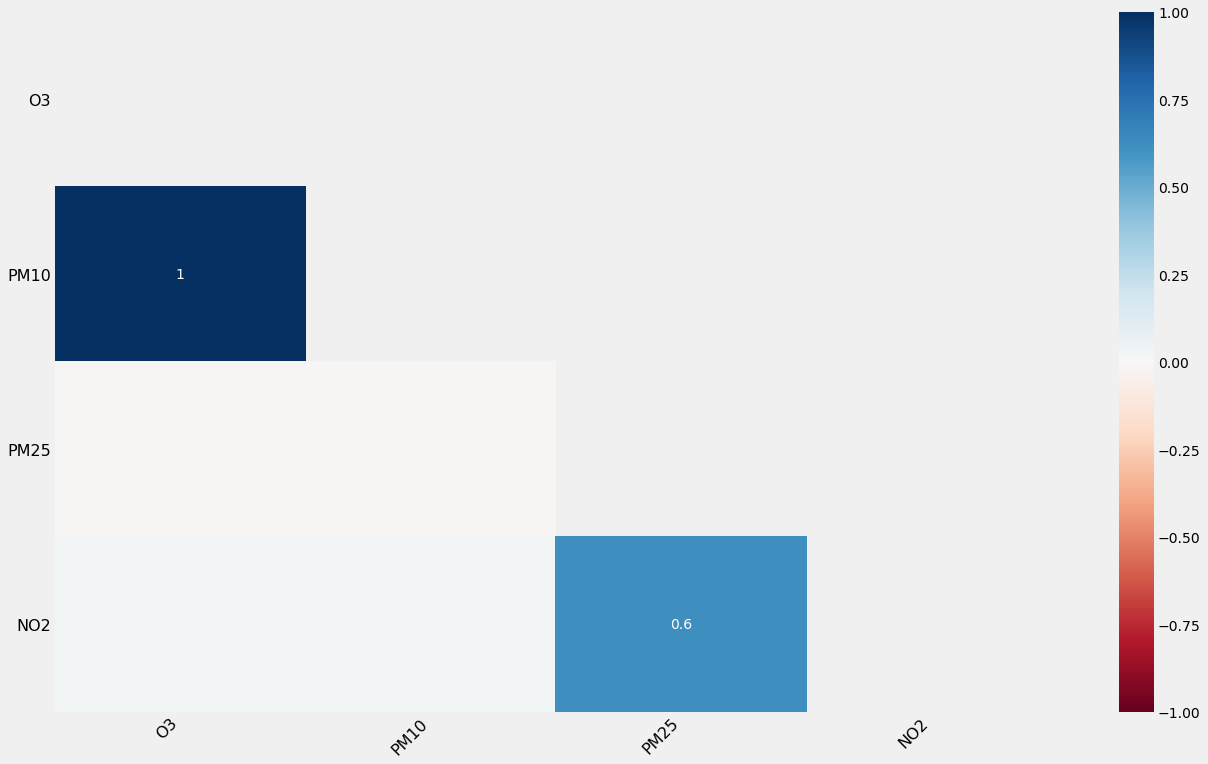

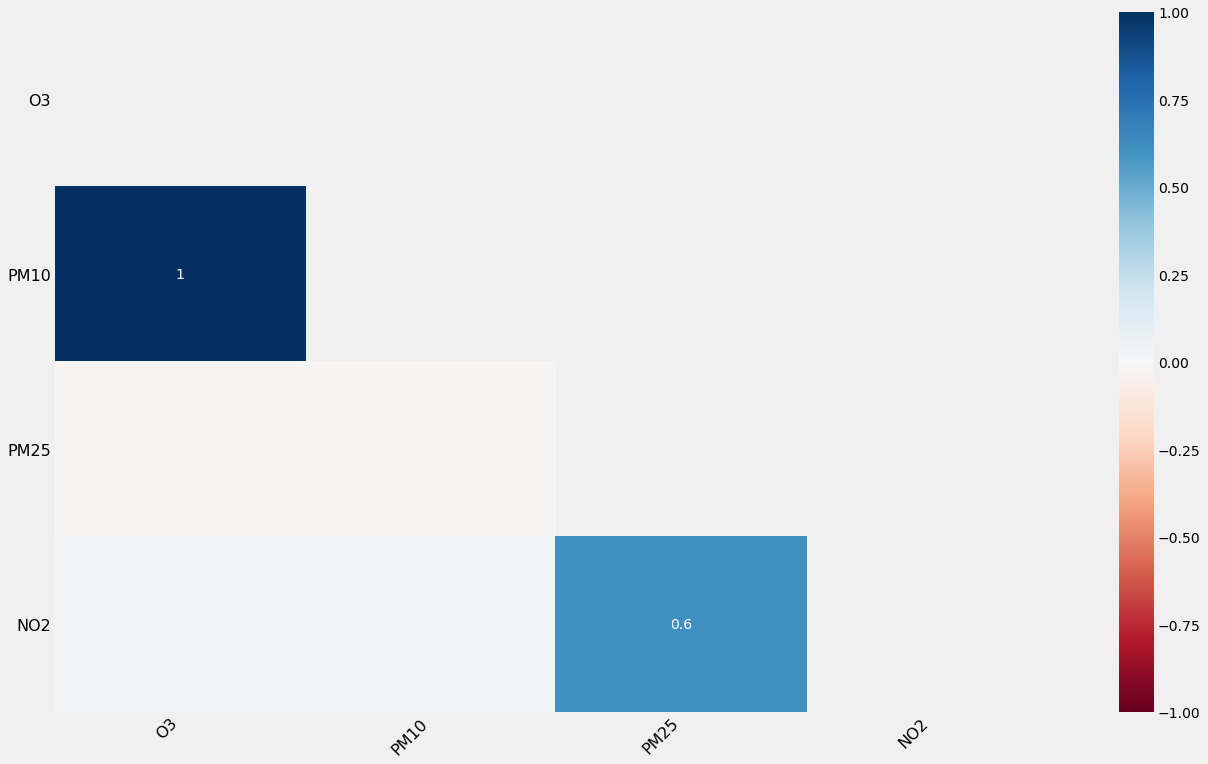

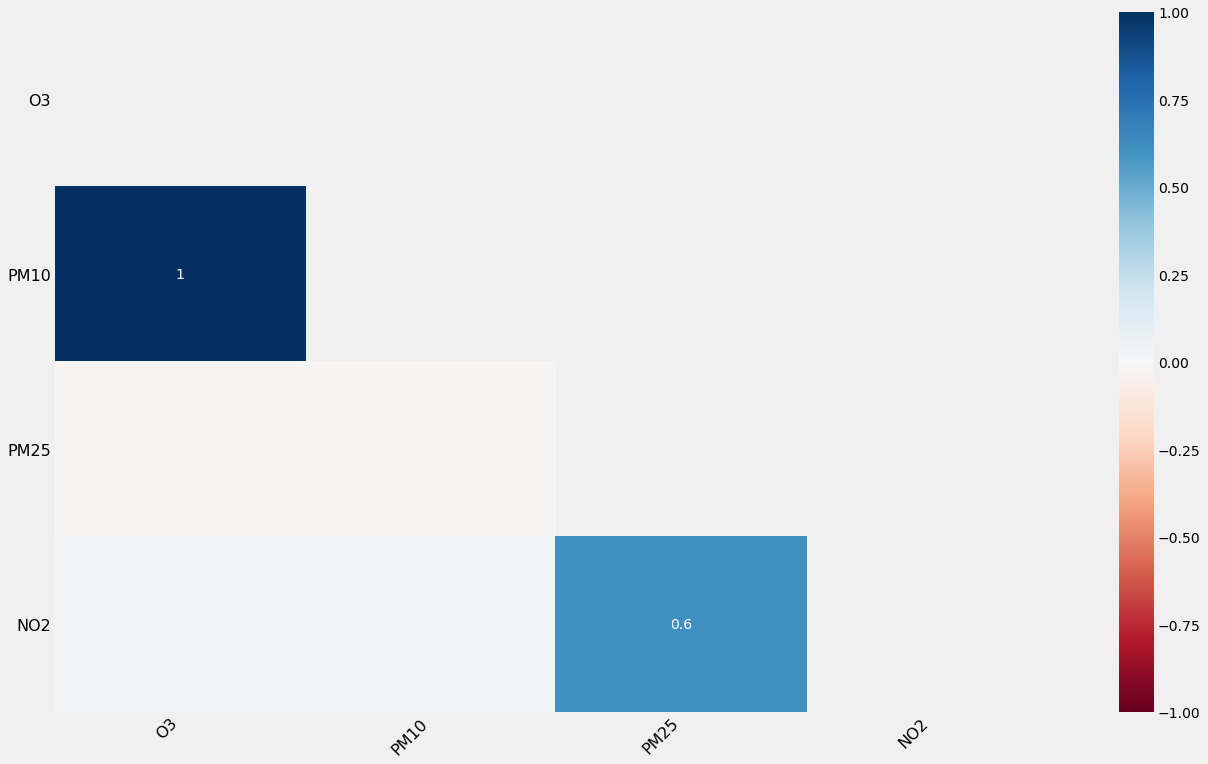

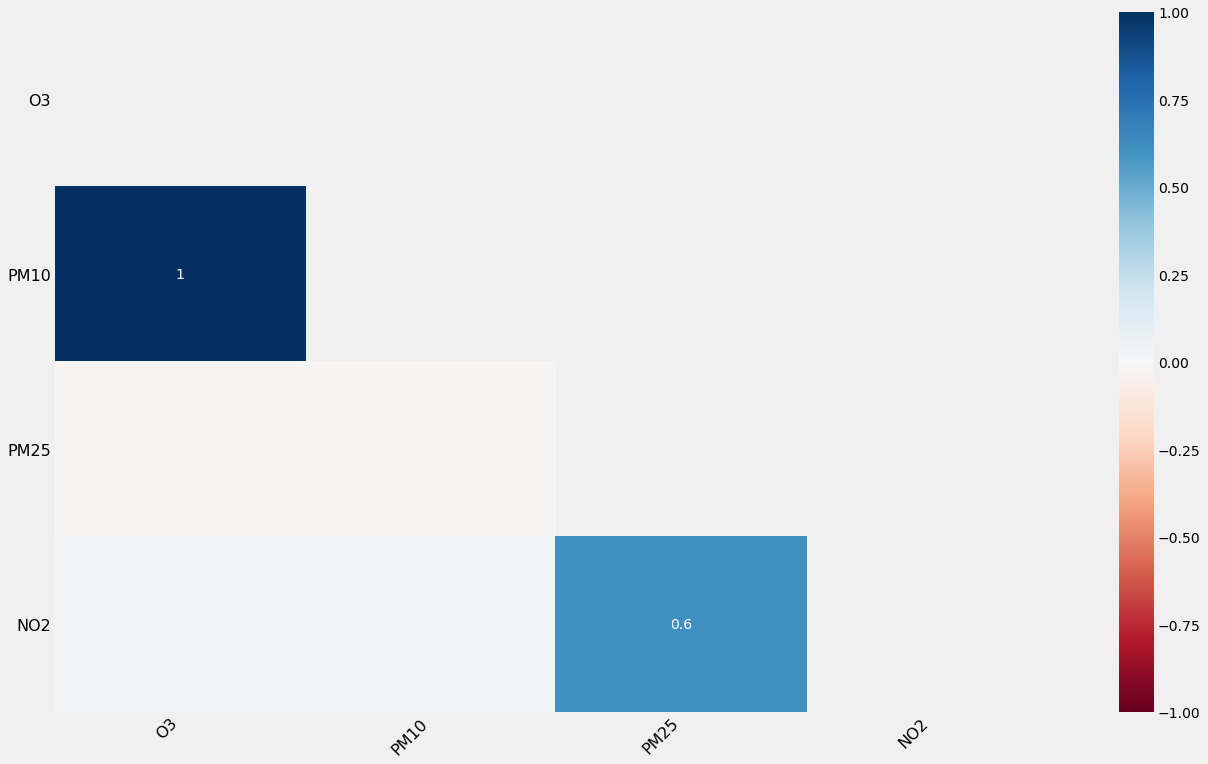

In [31]:
for r in train['region'].unique():
  t = train[train['region']==r]
  print(msno.heatmap(t))

del t
gc.collect()

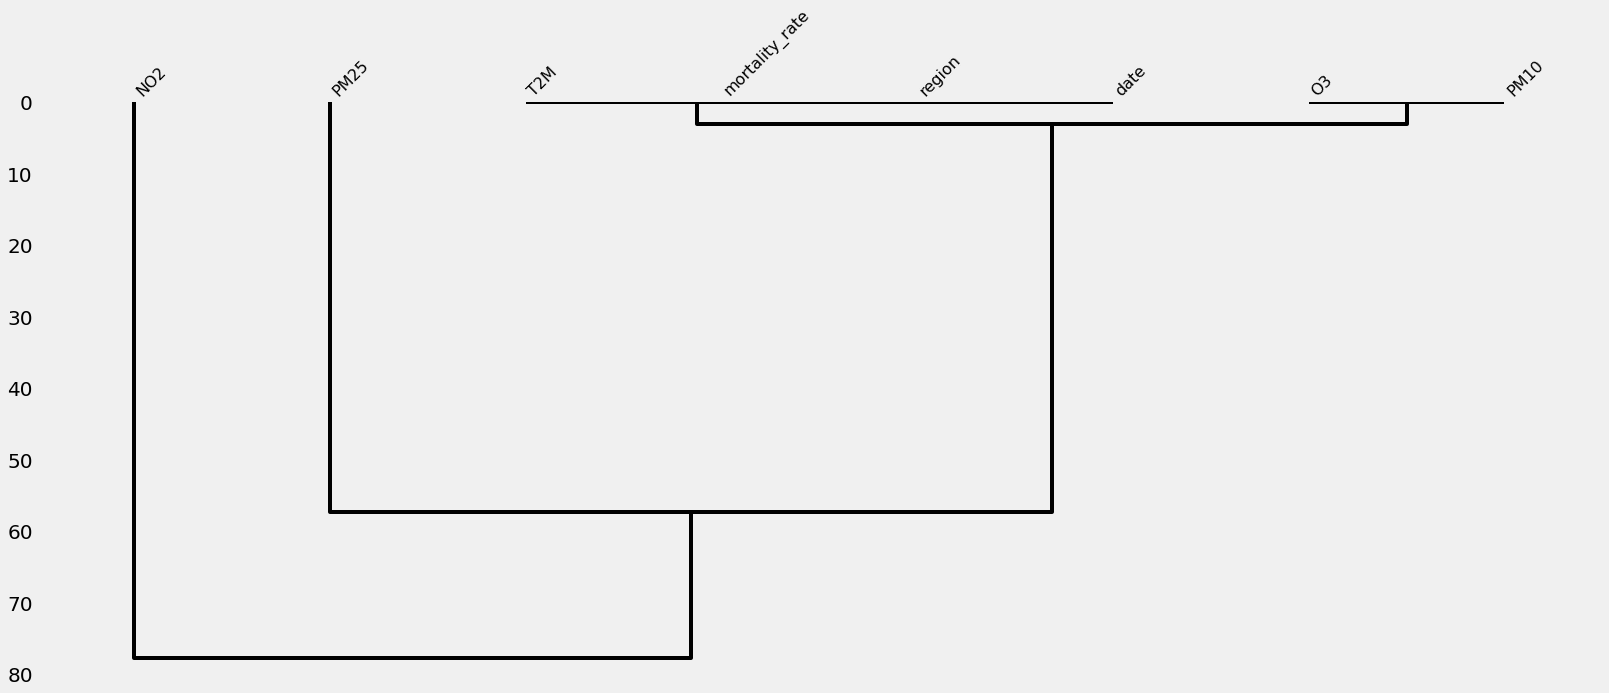

In [32]:
msno.dendrogram(train)

AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)
AxesSubplot(0.08,0.07;0.87x0.81)


36685

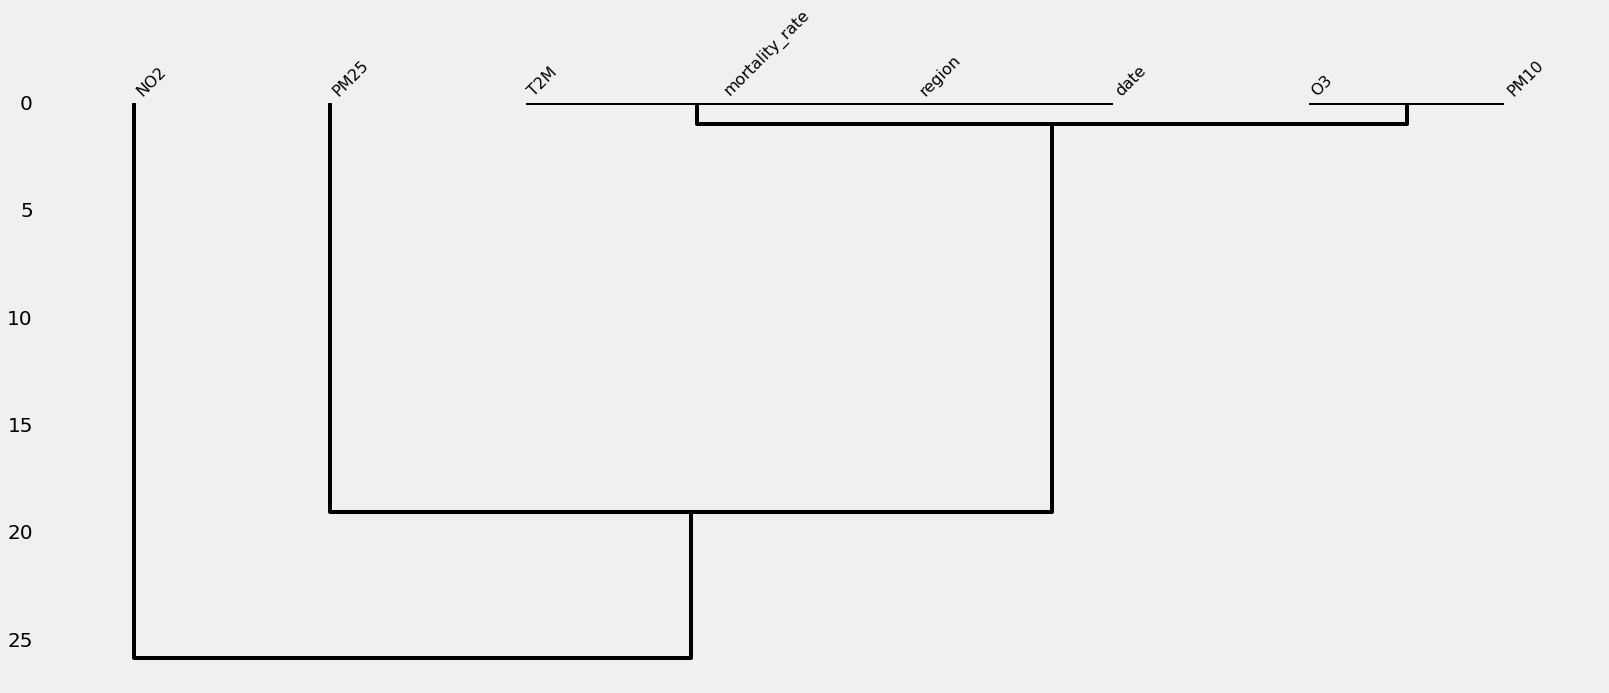

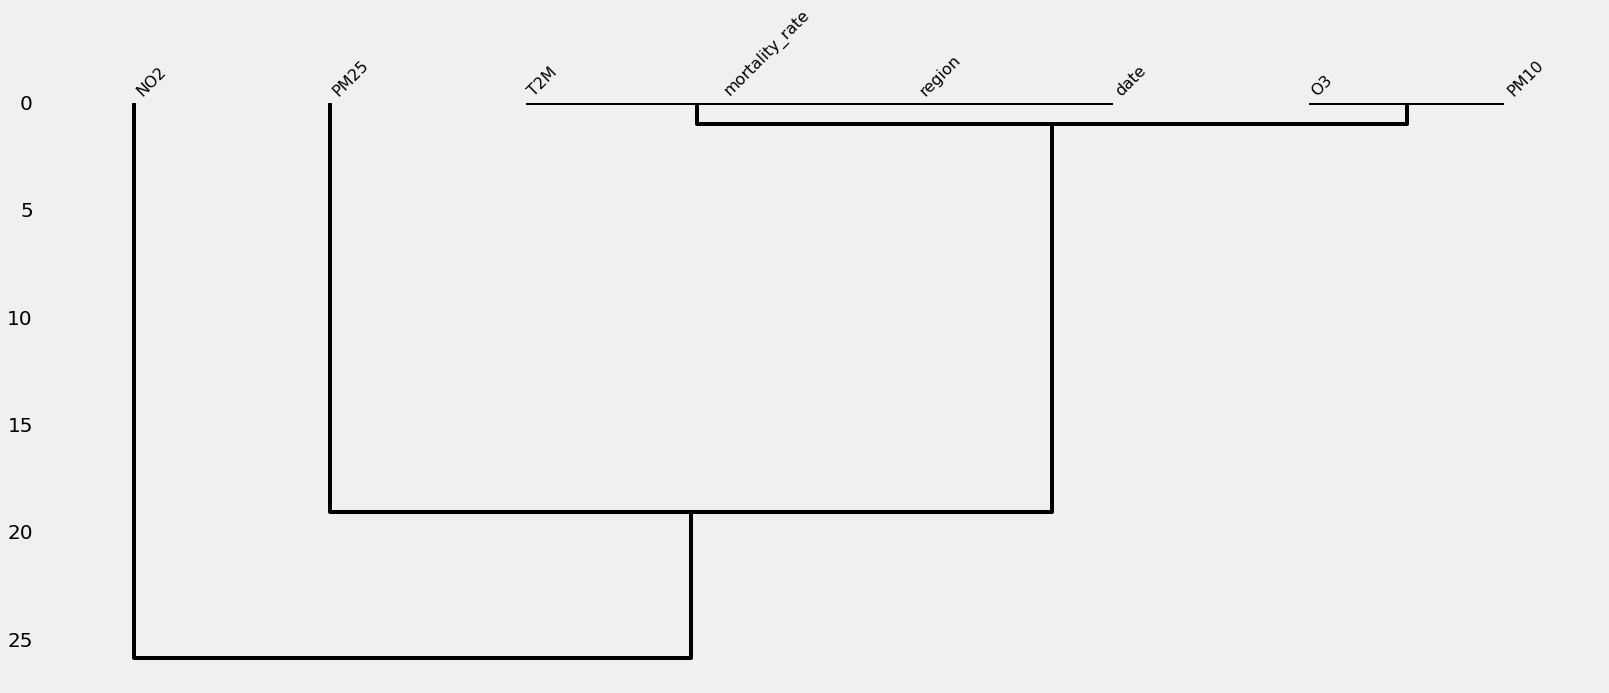

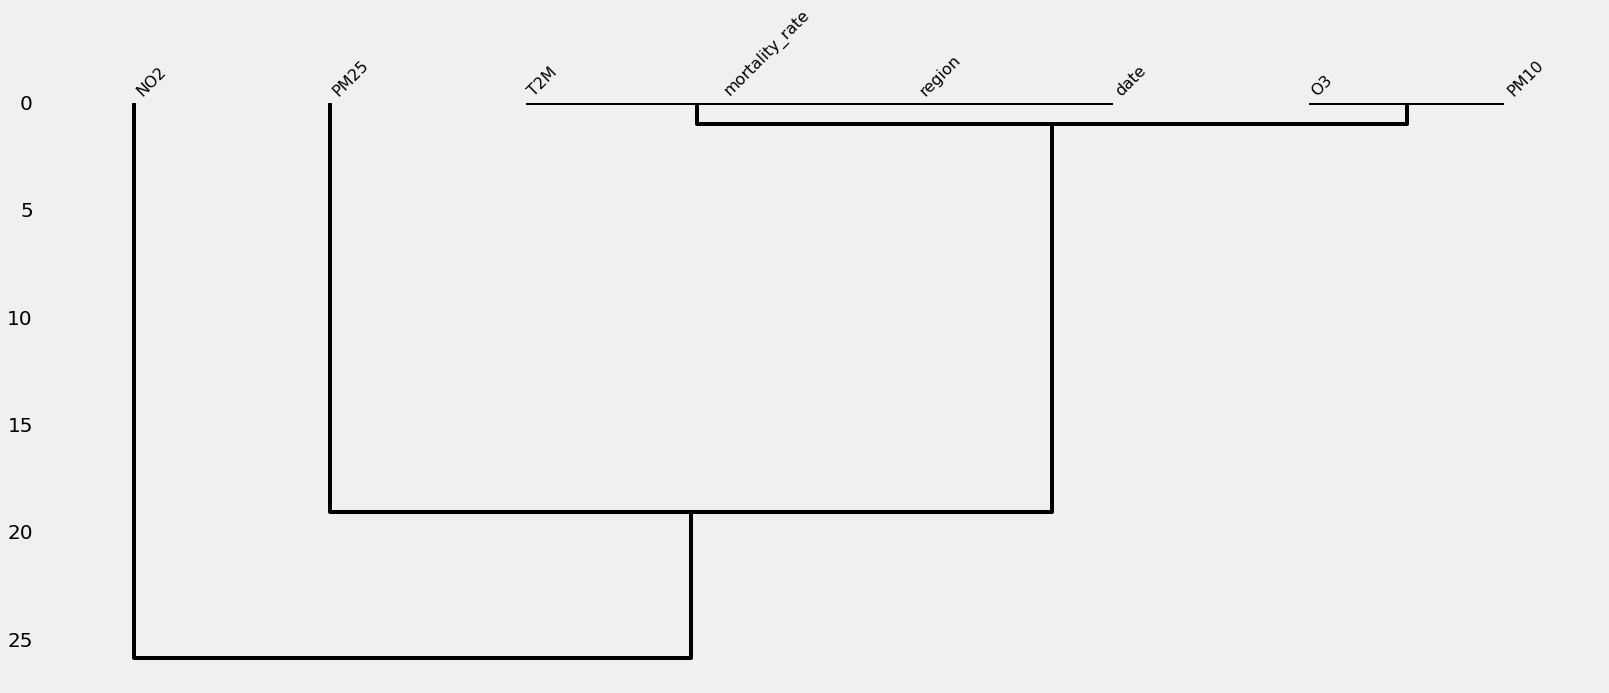

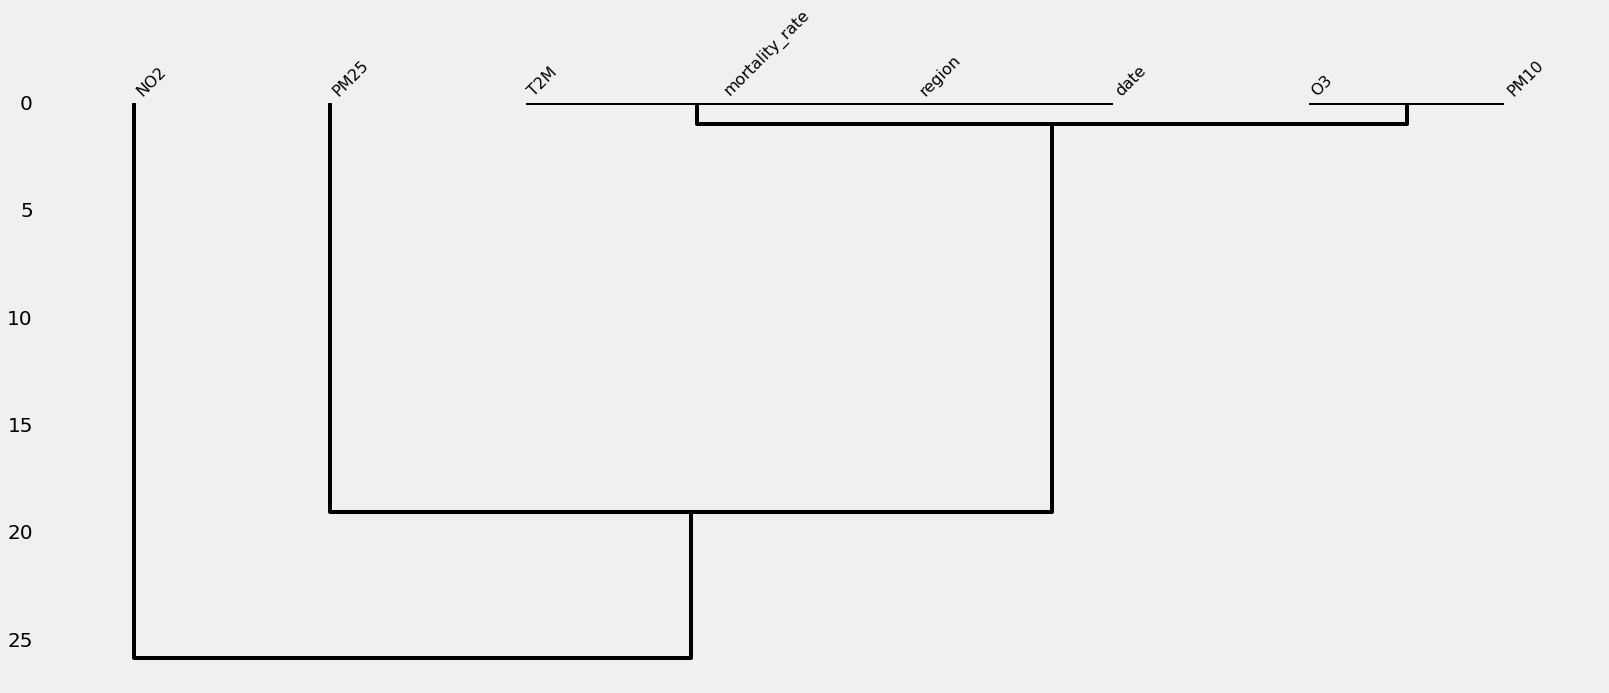

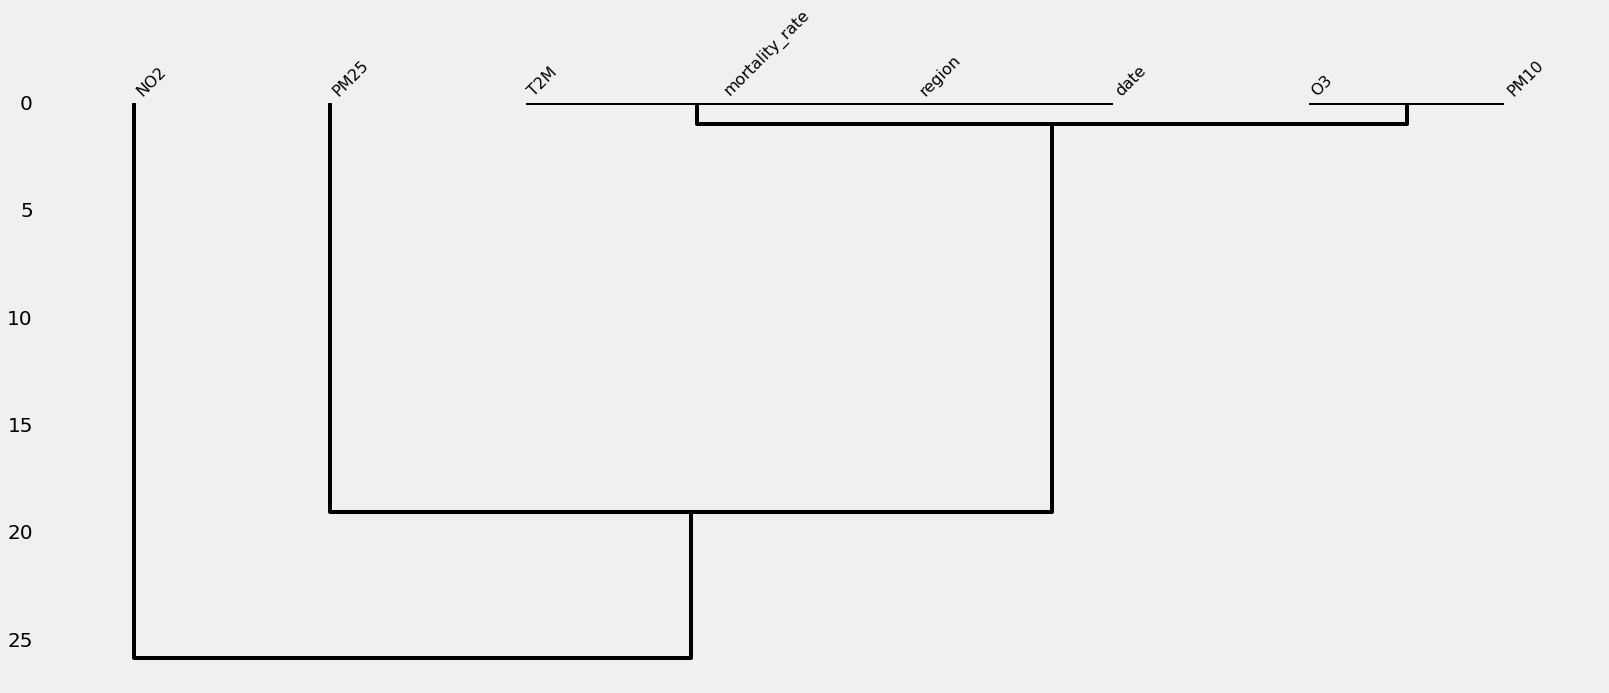

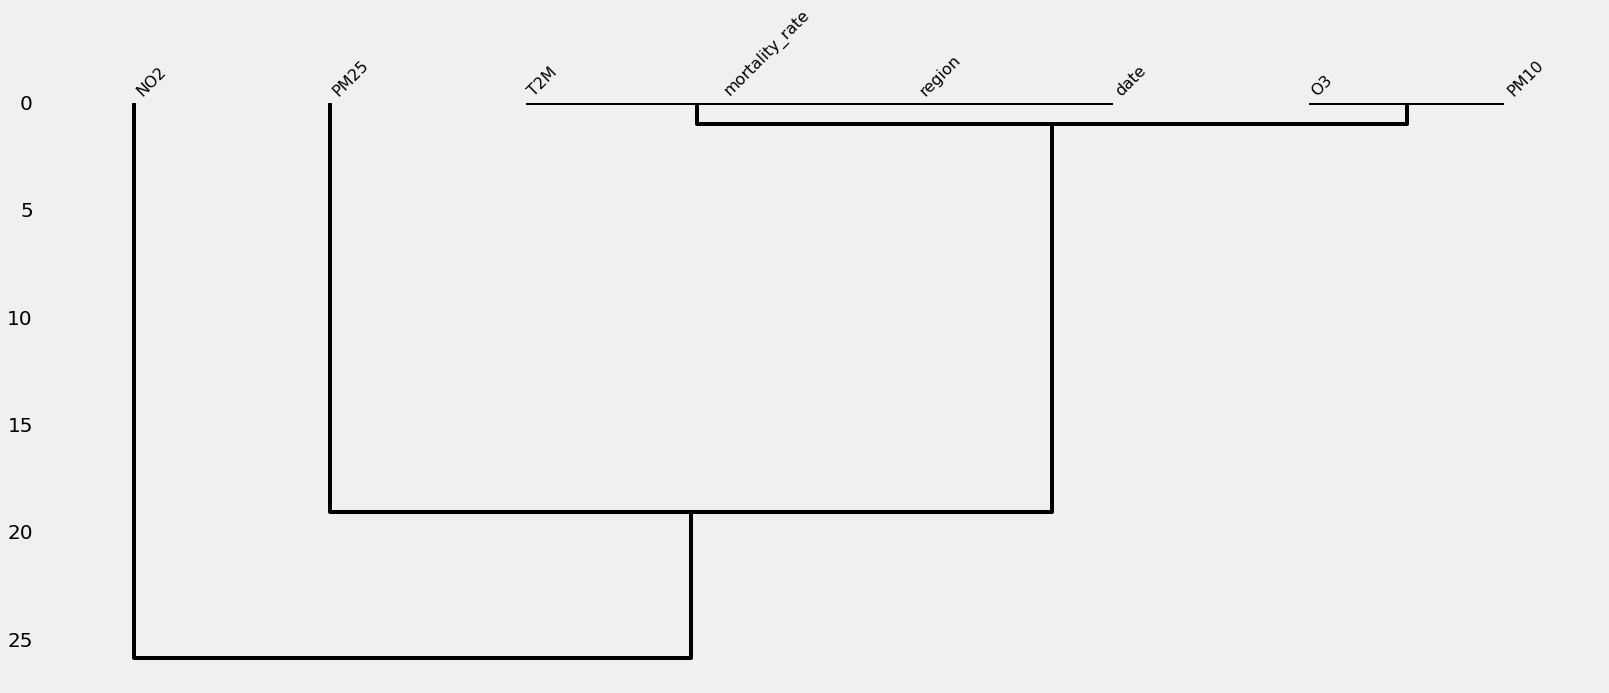

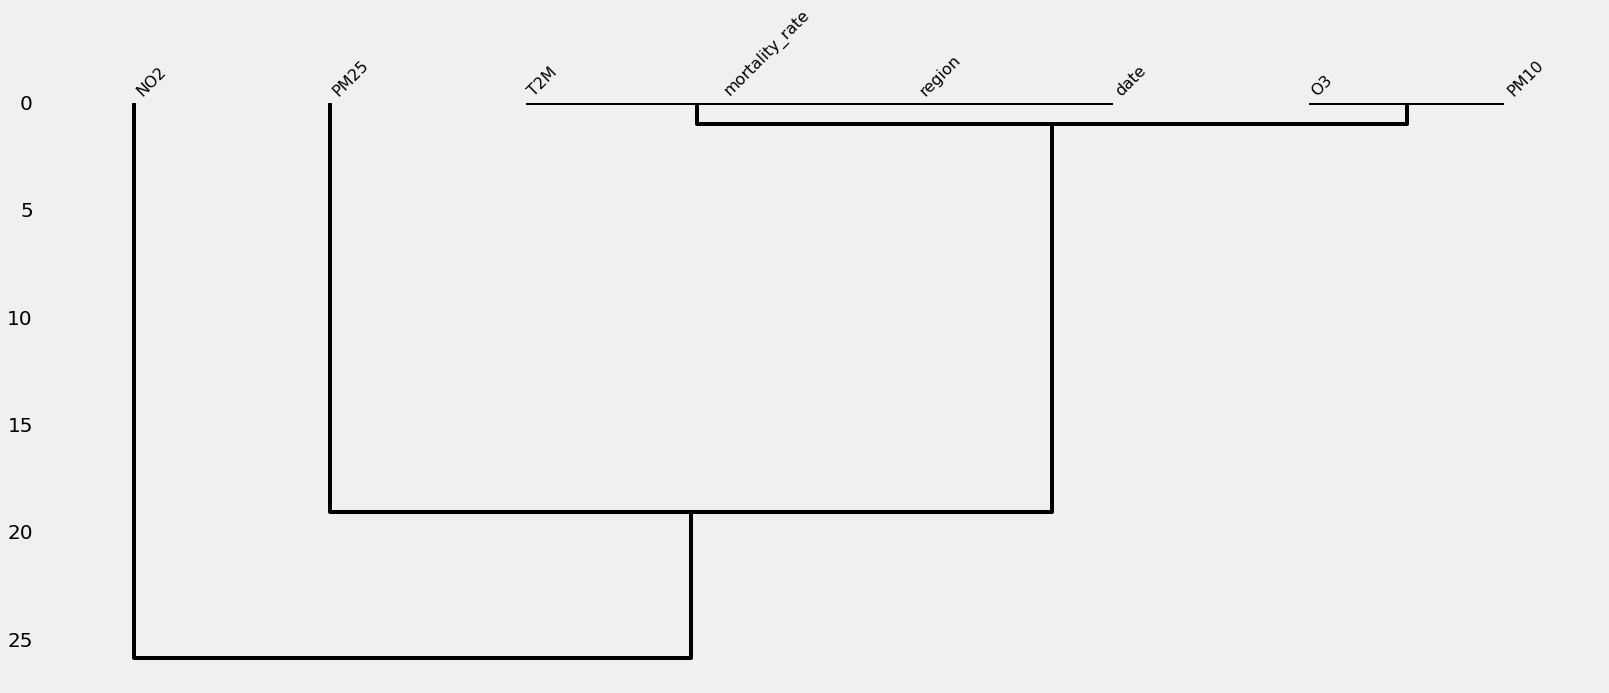

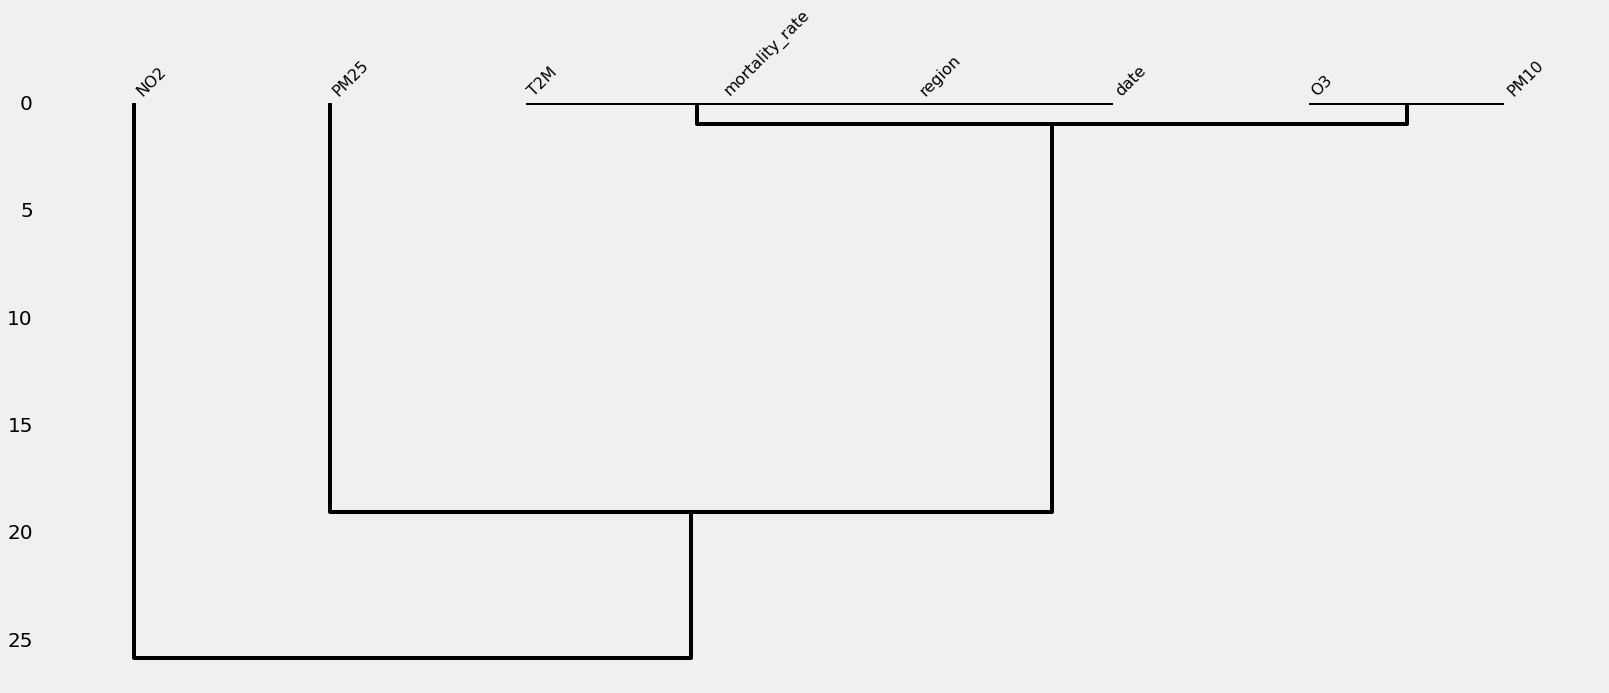

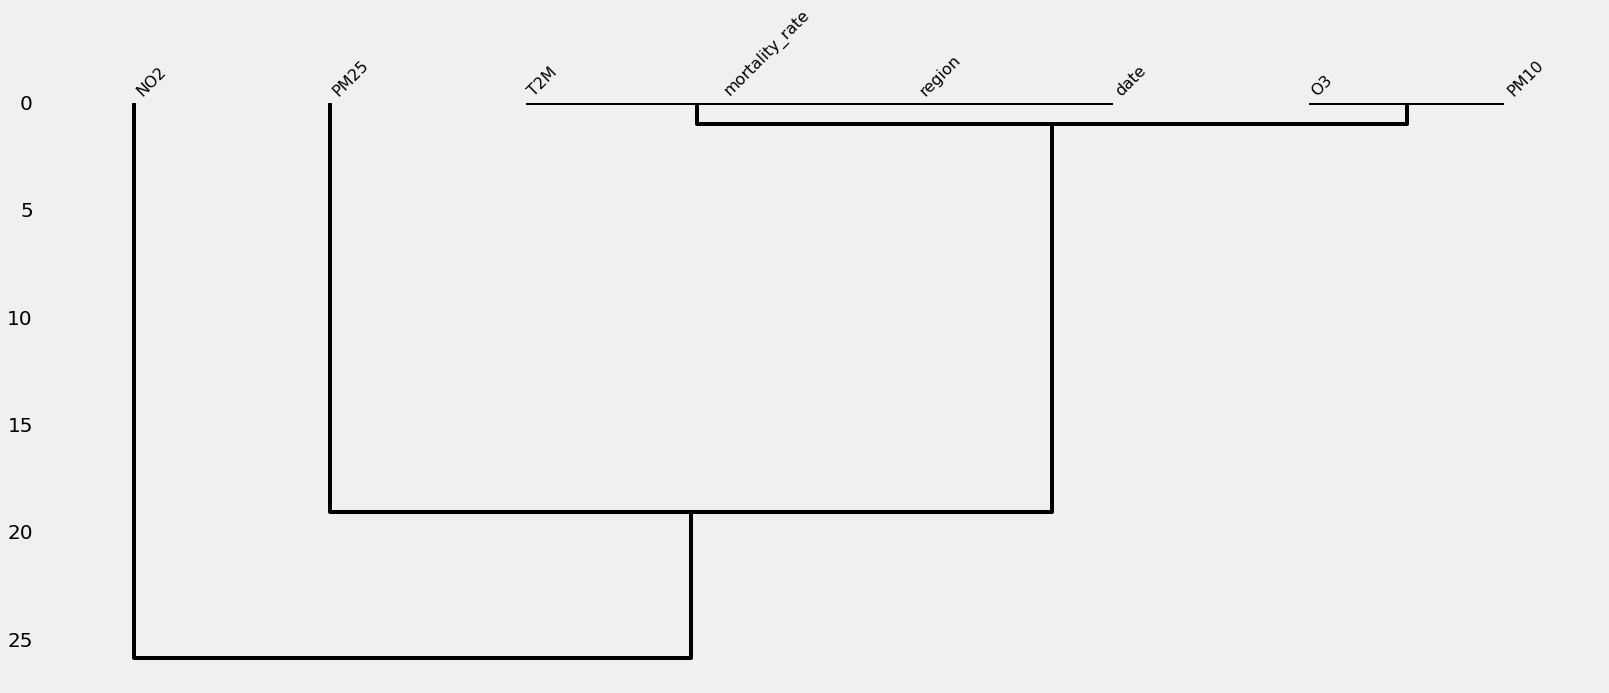

In [33]:
for r in train['region'].unique():
  t = train[train['region']==r]
  print(msno.dendrogram(t))

del t
gc.collect()

**_Missing values present in 4 columns, O3 ,PM10, PM25, NO2_**

## Merging Region names with the rest of the data

In [0]:
train1 = train.merge(region, left_on='region', right_on='Code')
train1.drop(columns = ['region'],inplace=True)
test1 = test.merge(region, left_on='region', right_on='Code')
test1.drop(columns = ['region'],inplace=True)

## univariate analysis ##

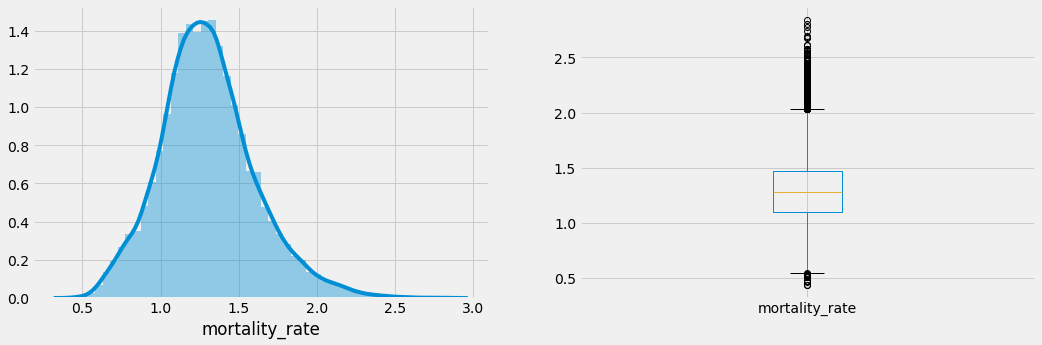

In [35]:
# Visualizing mortality_rate
def mr(df):
  plt.subplot(121)
  sns.distplot(df['mortality_rate']);

  plt.subplot(122)
  df['mortality_rate'].plot.box(figsize=(16,5))

  plt.show()

mr(train)

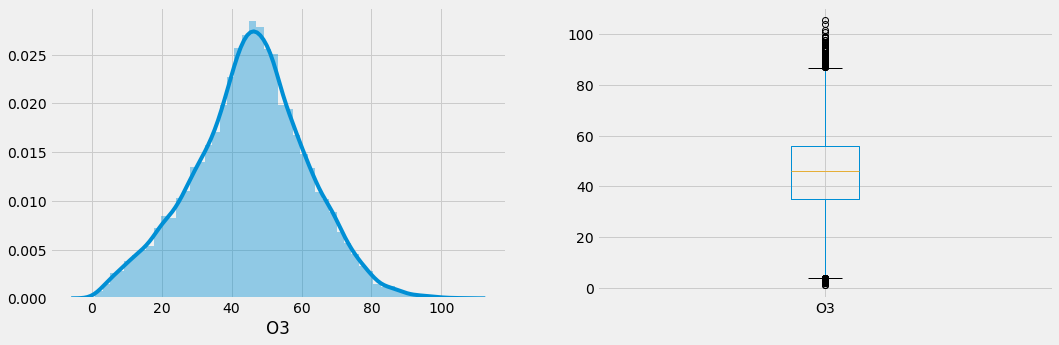

In [36]:
# Visualizing O3
def o3(df):
    plt.subplot(121)
    O3_1 = train['O3'].dropna()
    sns.distplot(O3_1);

    plt.subplot(122)
    O3_1.plot.box(figsize=(16,5))

    plt.show()
    plt.close()

o3(train)

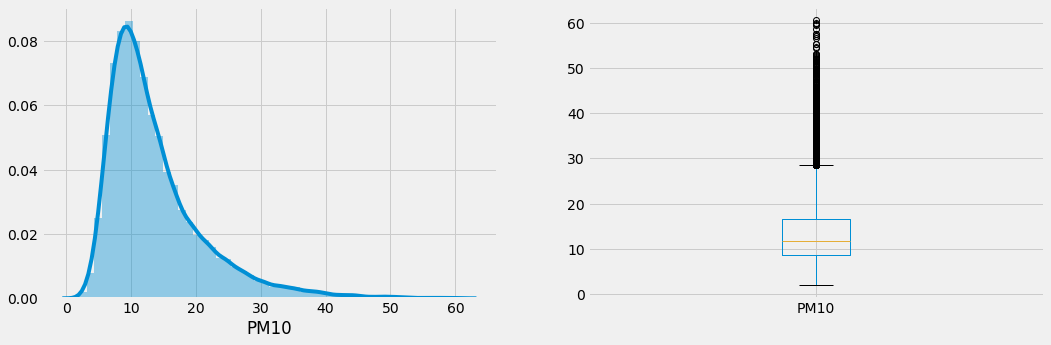

In [37]:
# Visualizing PM10
def pm10(df):
    plt.subplot(121)
    PM10_1 = train['PM10'].dropna()
    sns.distplot(PM10_1);

    plt.subplot(122)
    PM10_1.plot.box(figsize=(16,5))

    plt.show()

pm10(train)

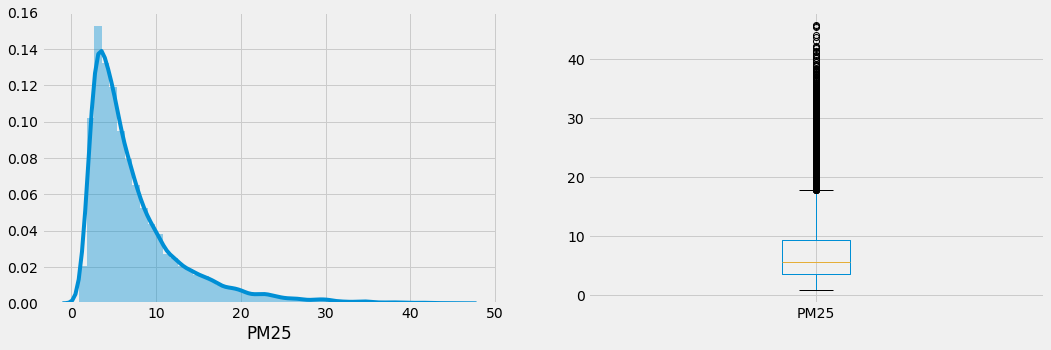

In [38]:
# Visualizing PM25

def pm25(df):
    plt.subplot(121)
    PM25_1 = train['PM25'].dropna()
    sns.distplot(PM25_1);

    plt.subplot(122)
    PM25_1.plot.box(figsize=(16,5))

    plt.show()

pm25(train)

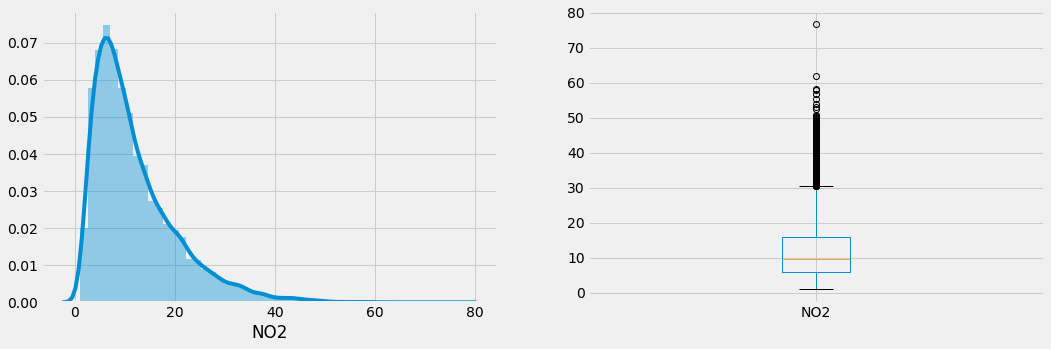

In [39]:
# Visualizing NO2
def no2(df):
    plt.subplot(121)
    NO2_1 = train['NO2'].dropna()
    sns.distplot(NO2_1);

    plt.subplot(122)
    NO2_1.plot.box(figsize=(16,5))

    plt.show()
  
no2(train)

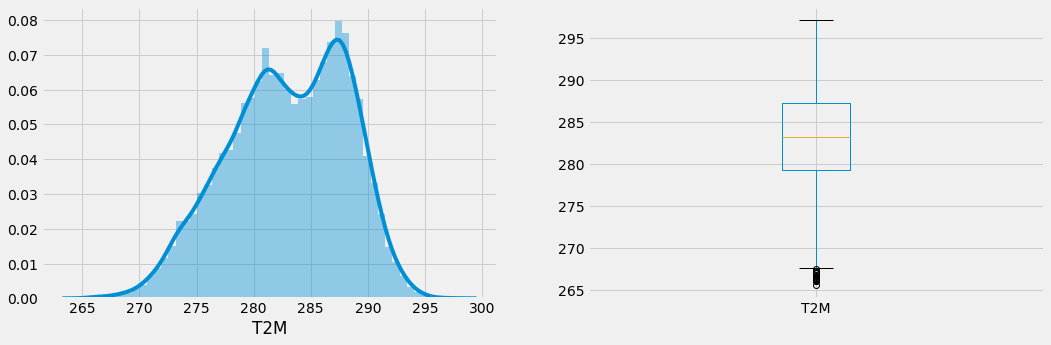

In [40]:
# Visualizing T2M

def t2m(df):
    plt.subplot(121)
    sns.distplot(train['T2M']);

    plt.subplot(122)
    train['T2M'].plot.box(figsize=(16,5))

    plt.show()

t2m(train)

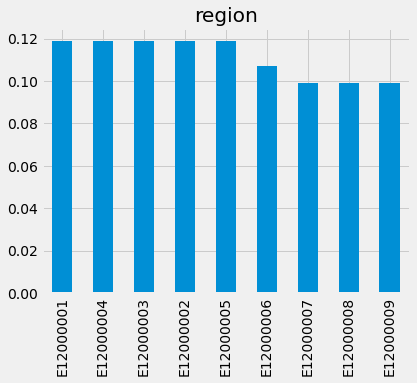

In [41]:
# Visualizing categorical features
plt.subplot(231)
train['region'].value_counts(normalize=True).plot.bar(figsize=(20,10), title= 'region')

mortality rate across regions


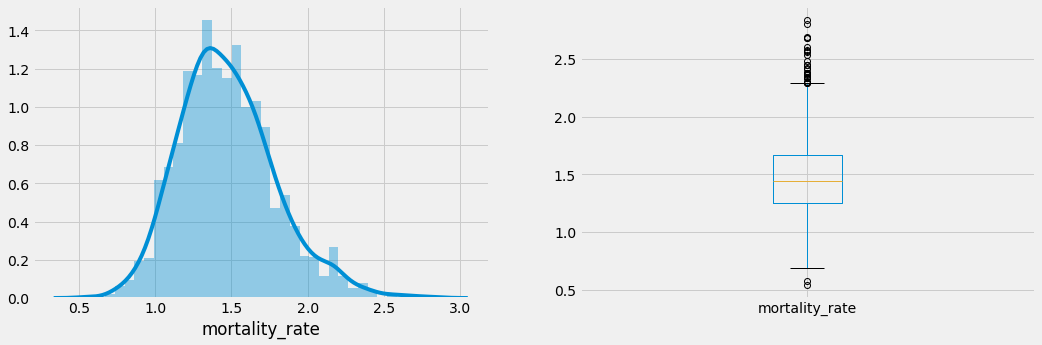

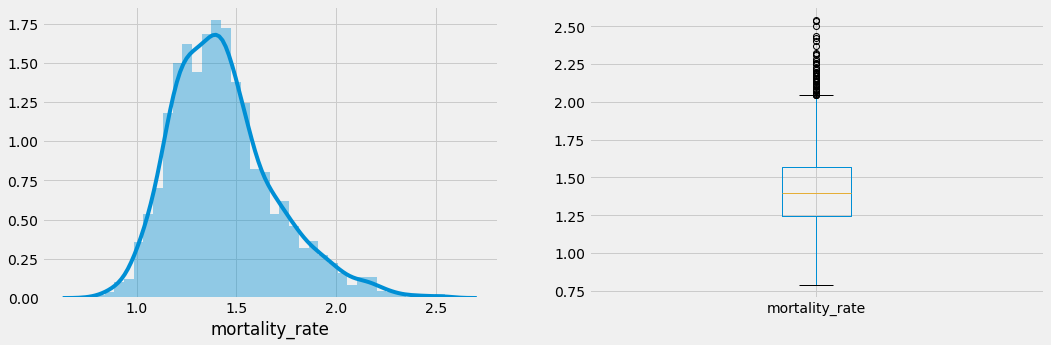

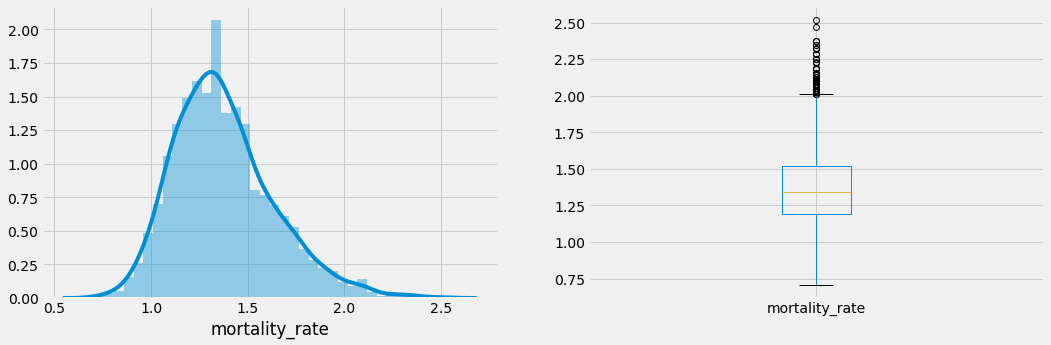

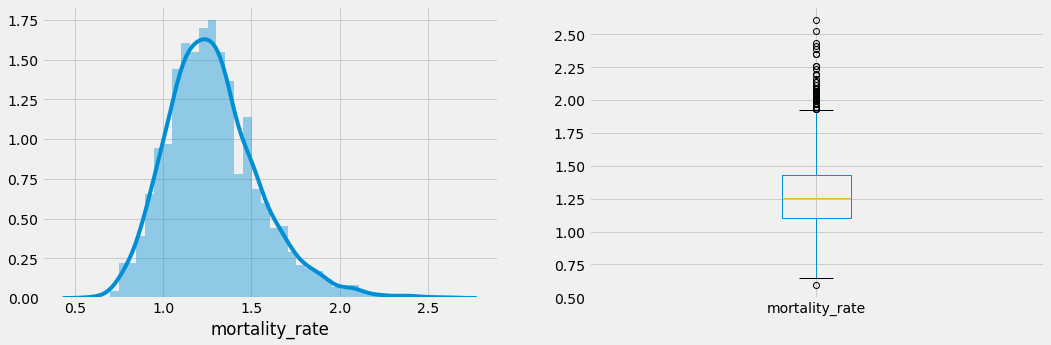

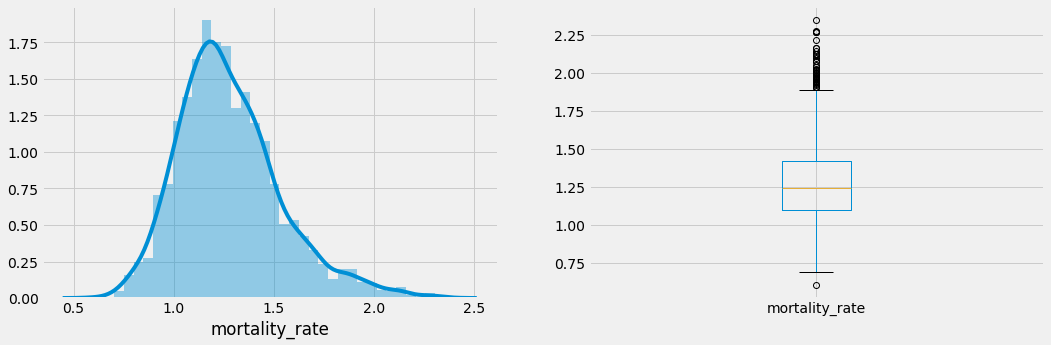

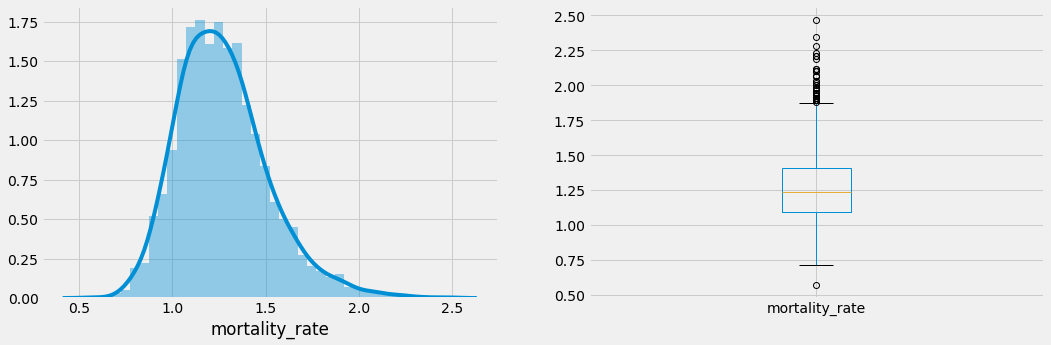

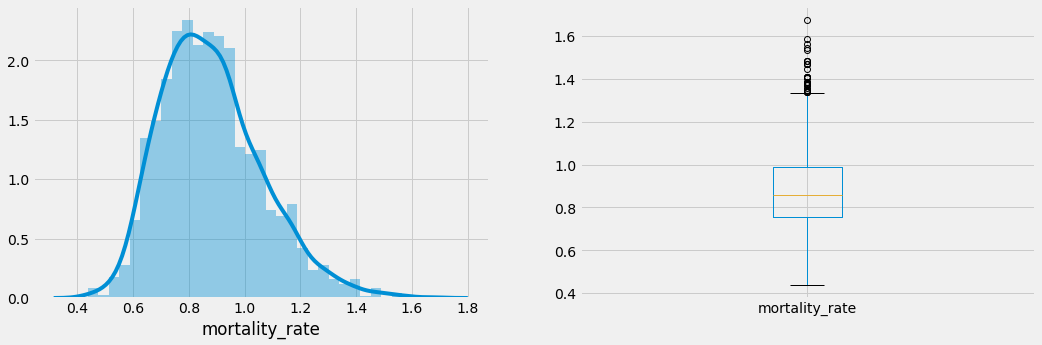

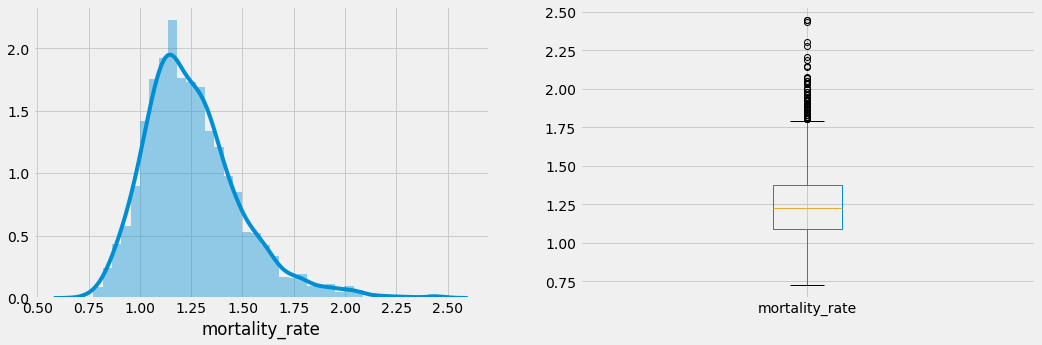

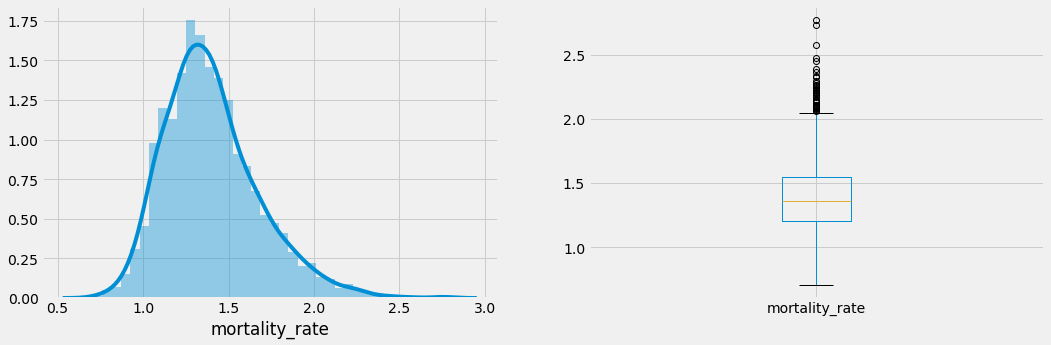

In [42]:
print('mortality rate across regions')
for r in train['region'].unique():
  t = train[train['region']==r]
  mr(t)

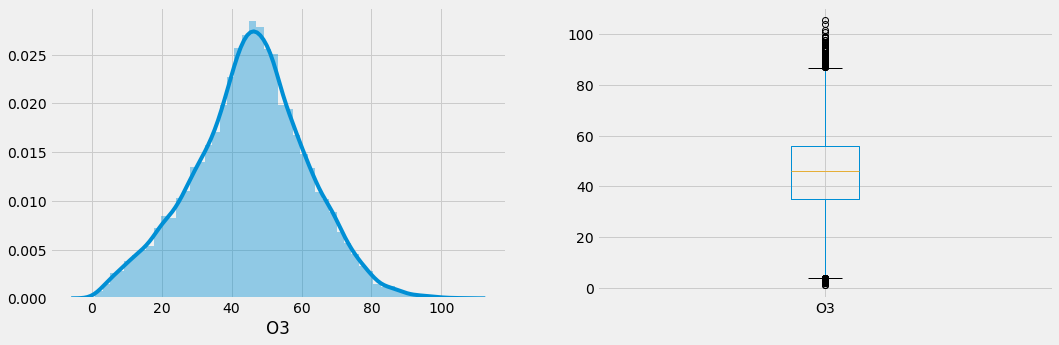

None


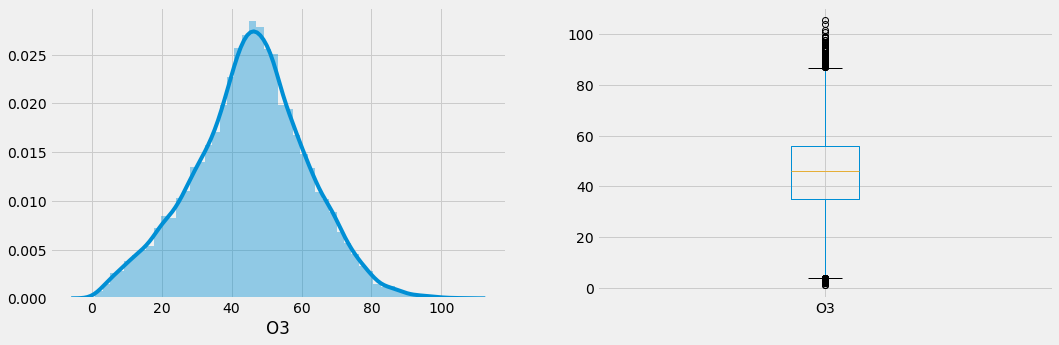

None


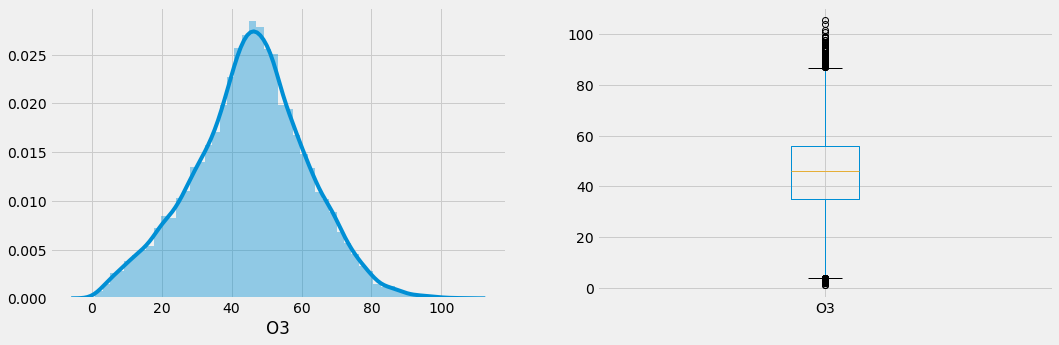

None


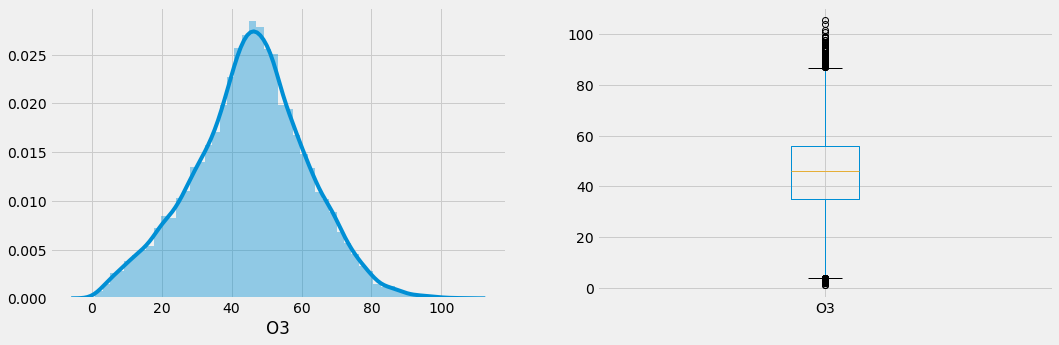

None


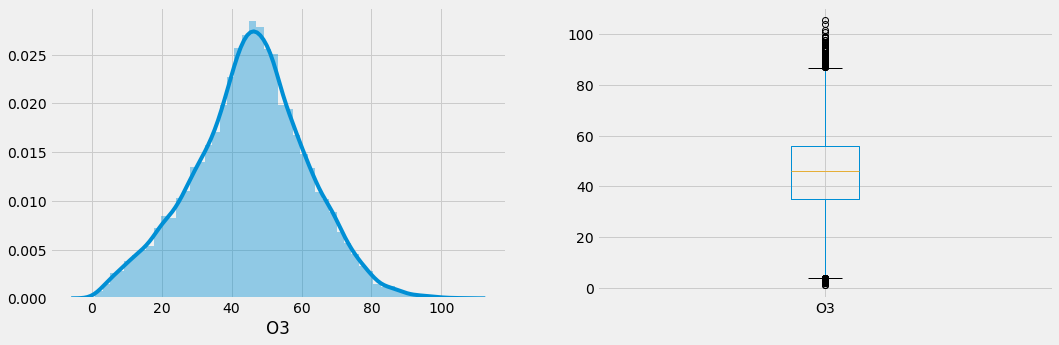

None


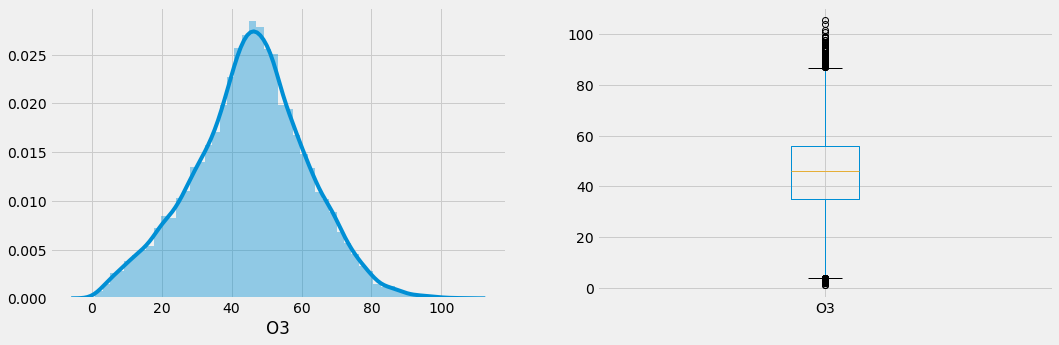

None


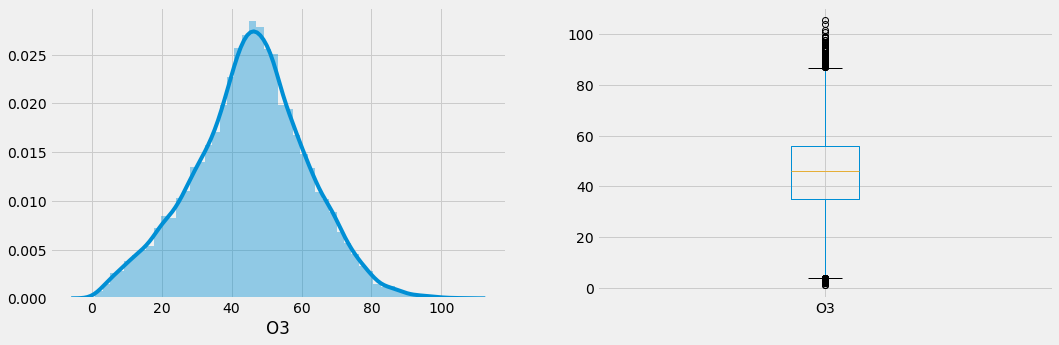

None


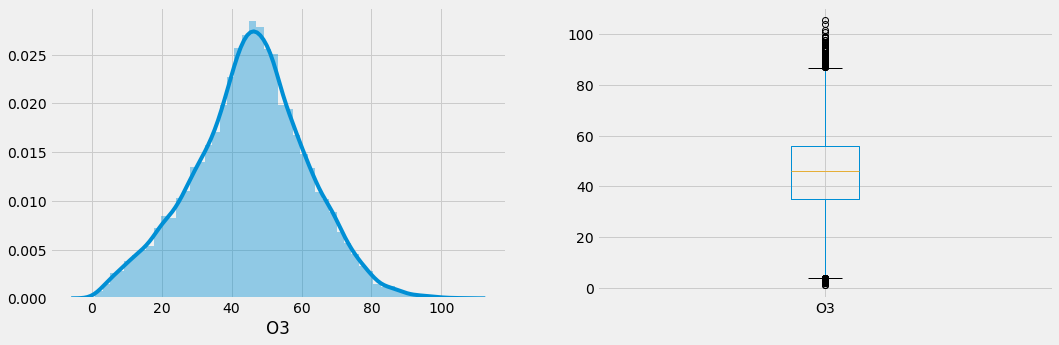

None


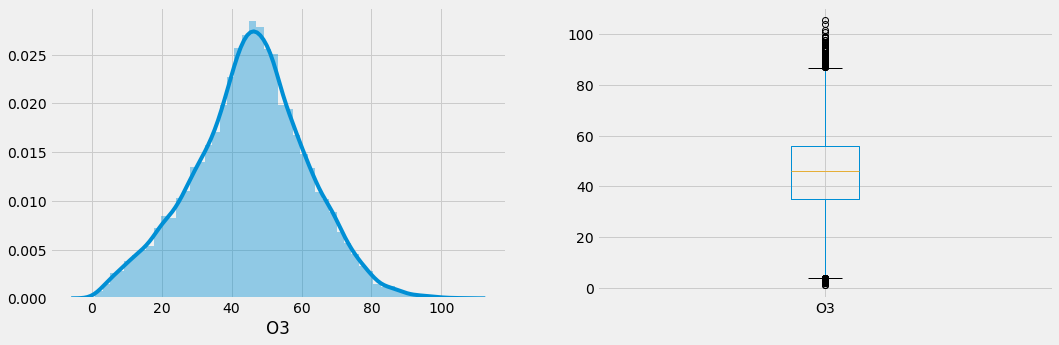

None


In [43]:
for r in train['region'].unique():
  t = train[train['region']==r]
  print(o3(t))

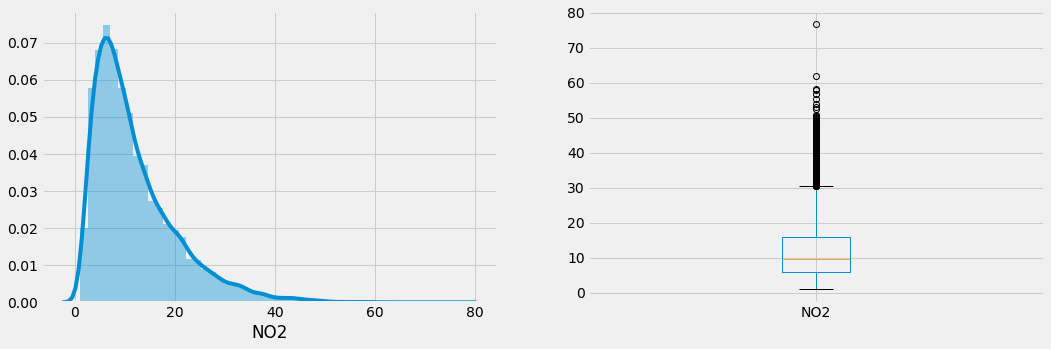

None


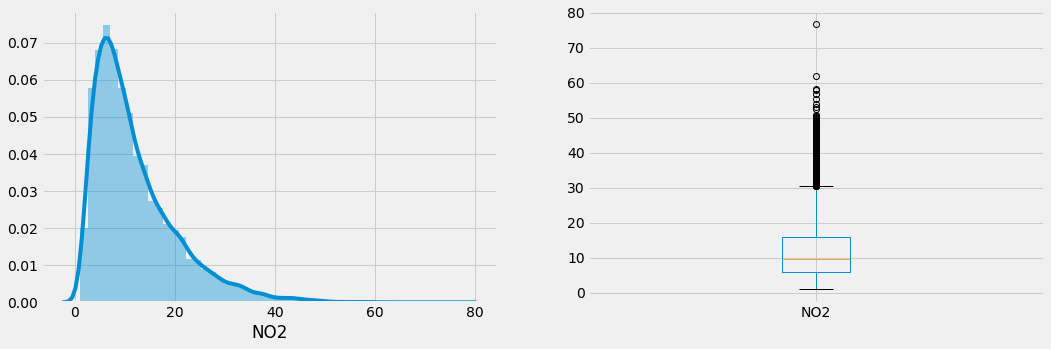

None


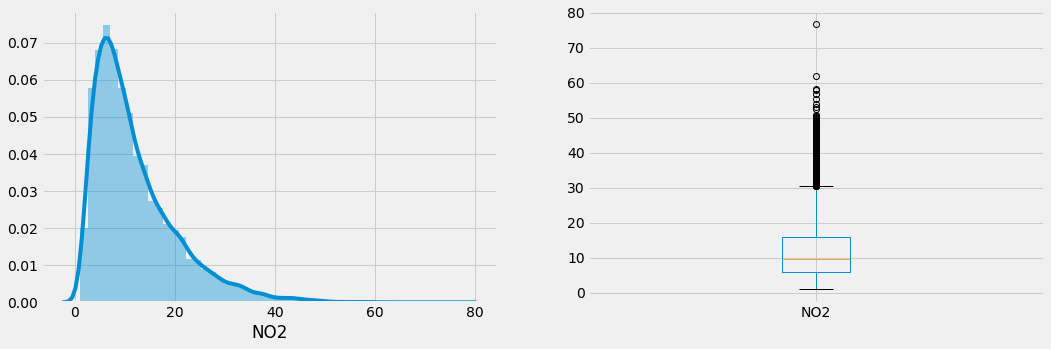

None


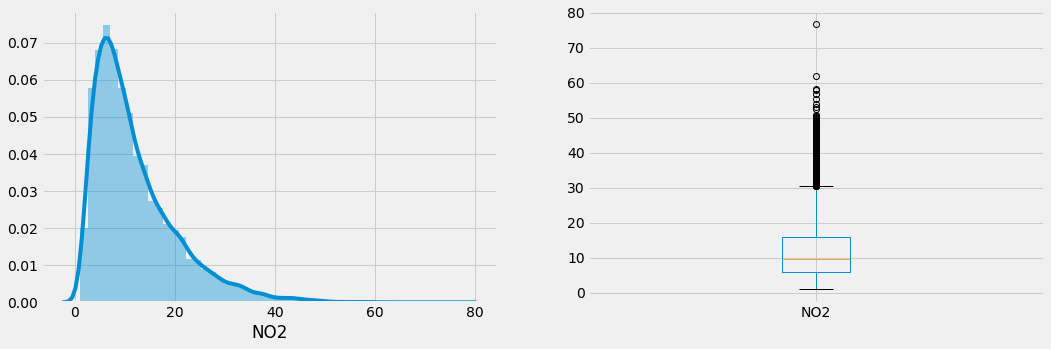

None


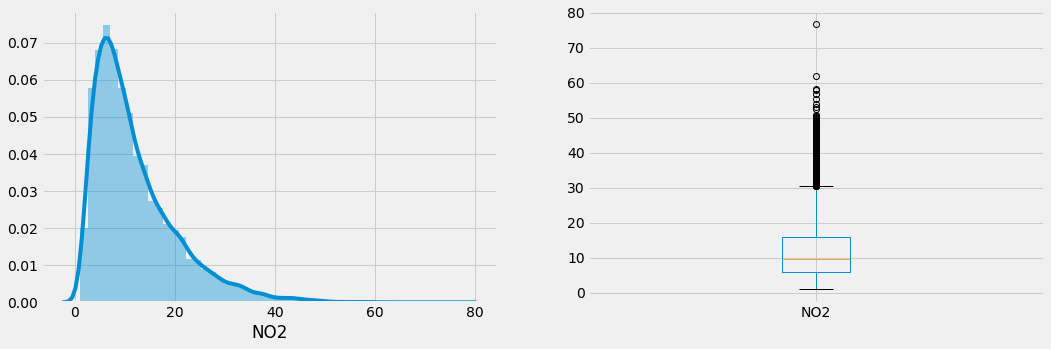

None


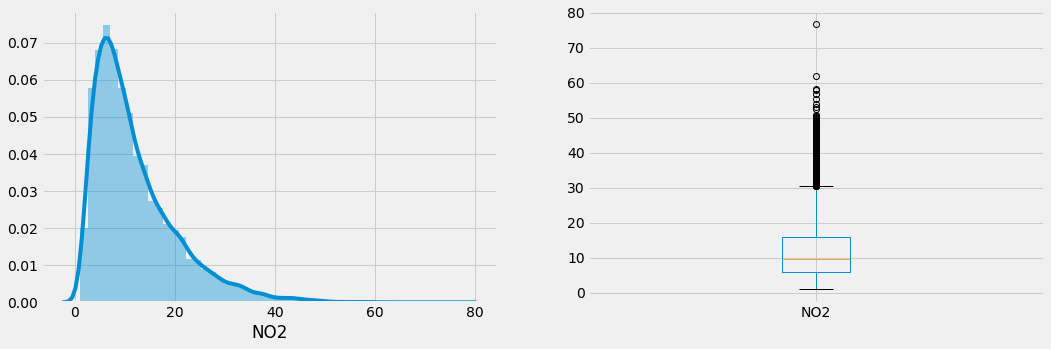

None


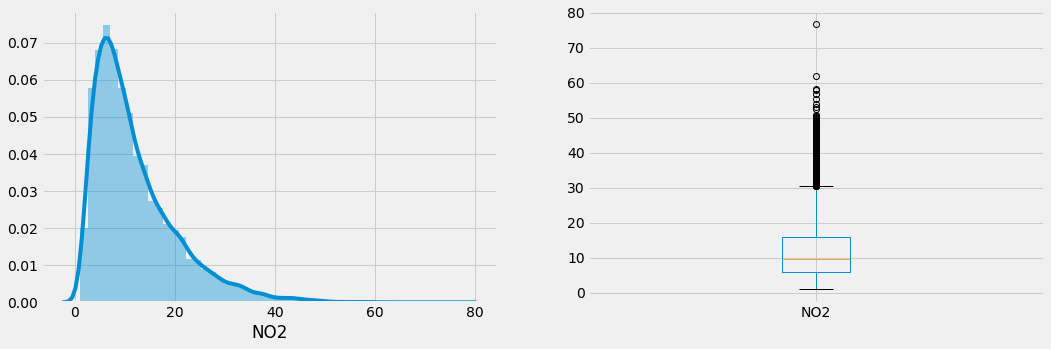

None


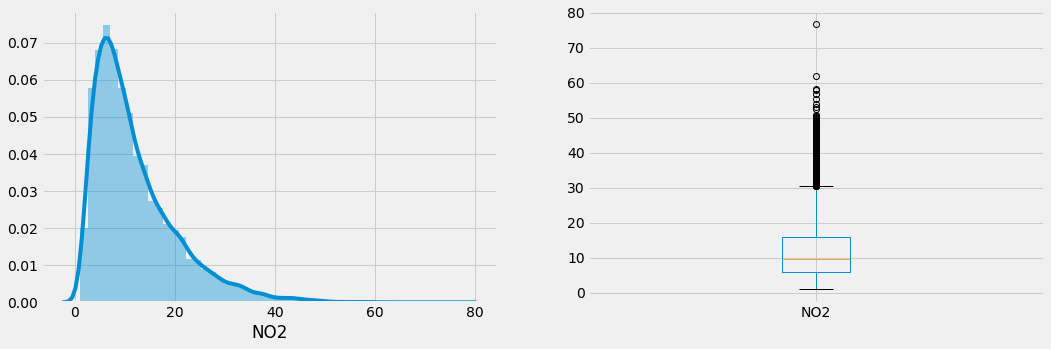

None


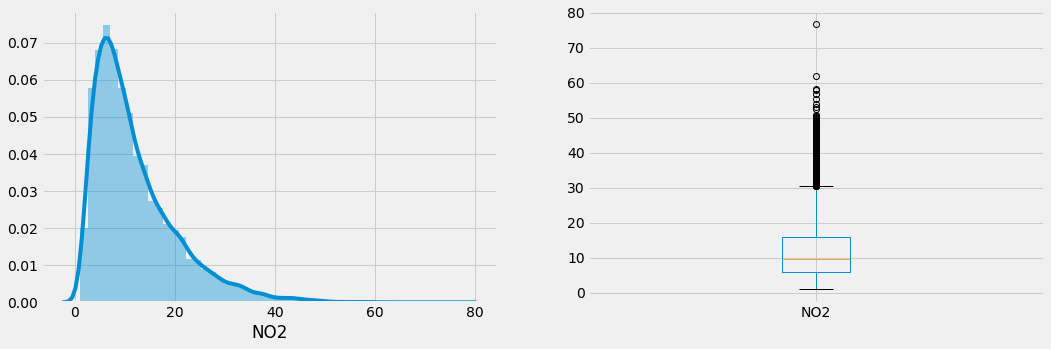

None


In [44]:
for r in train['region'].unique():
  t = train[train['region']==r]
  print(no2(t))

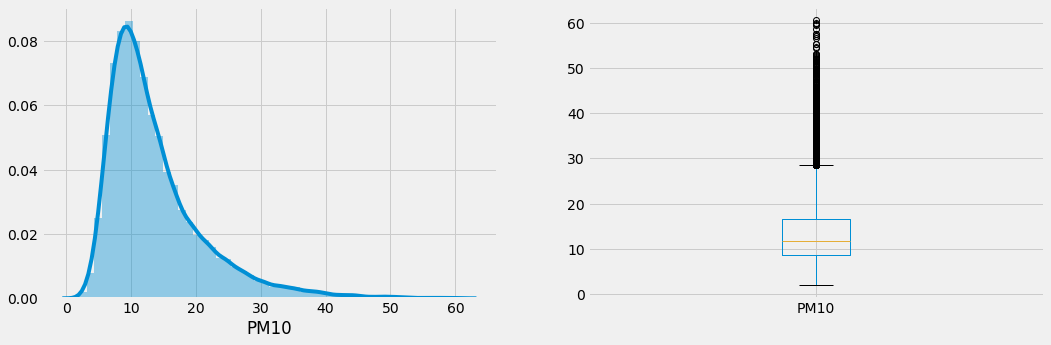

None


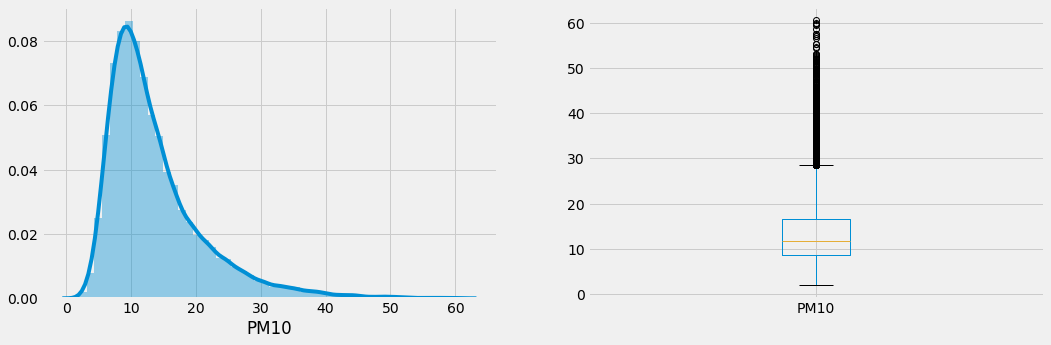

None


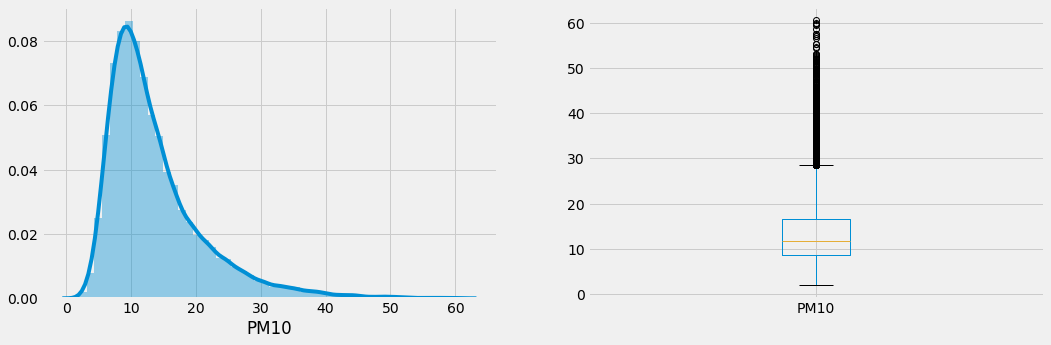

None


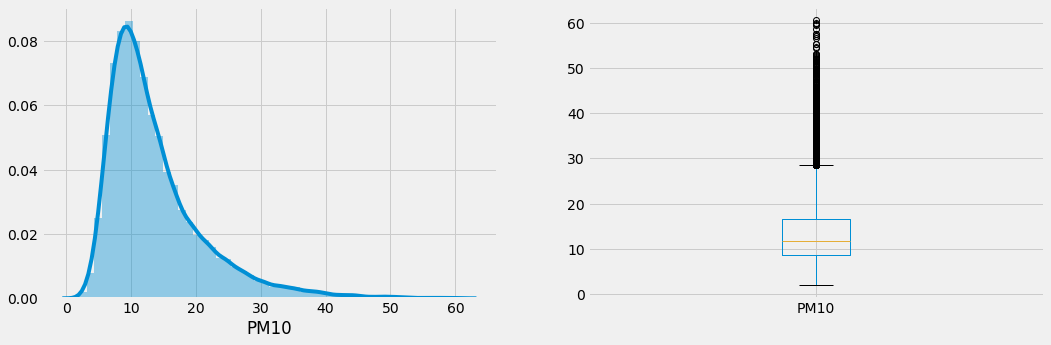

None


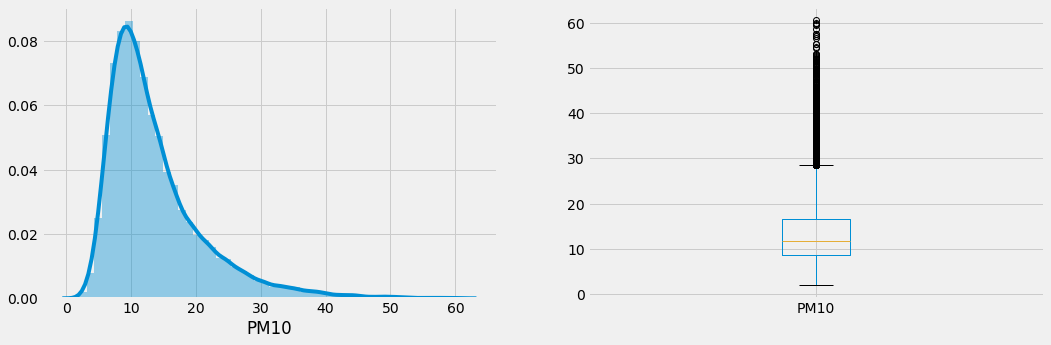

None


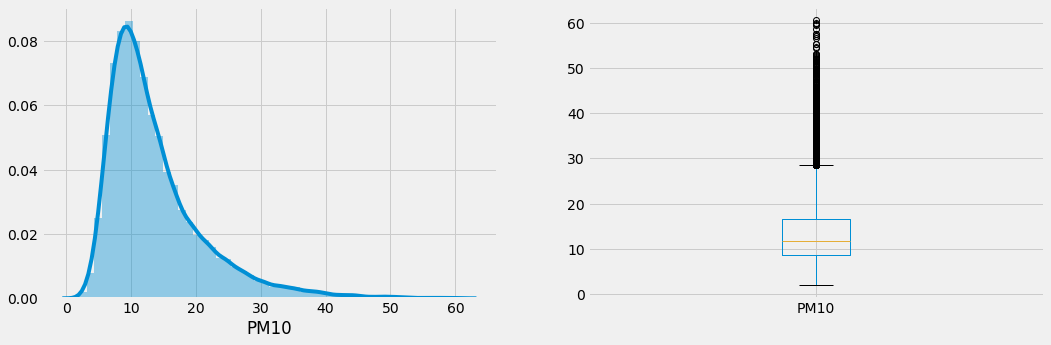

None


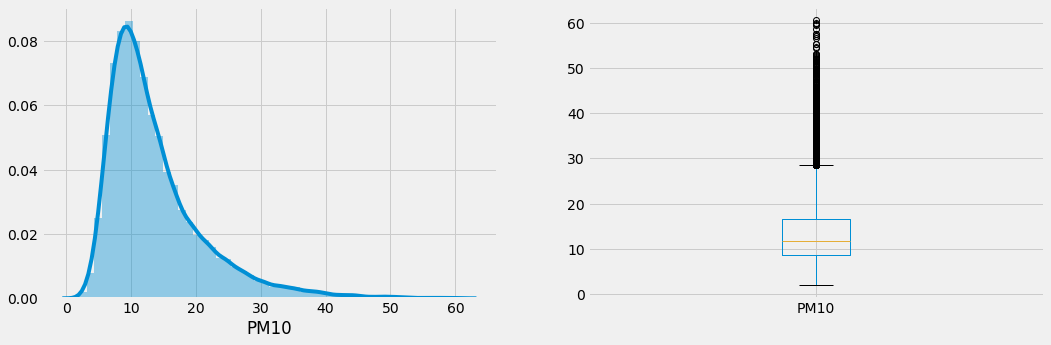

None


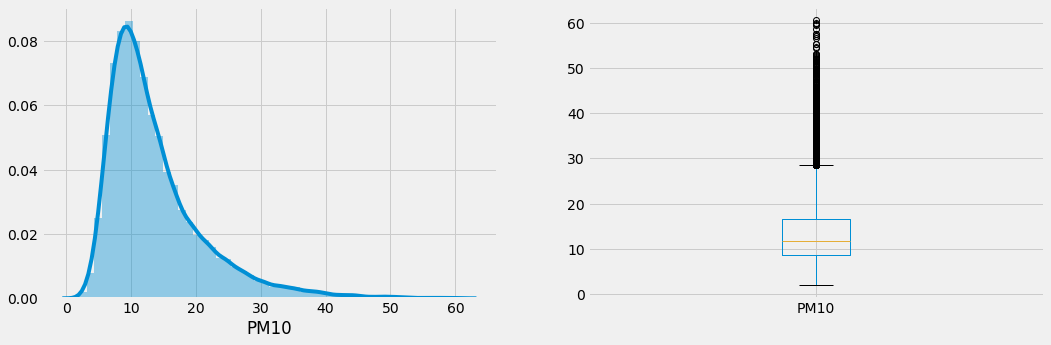

None


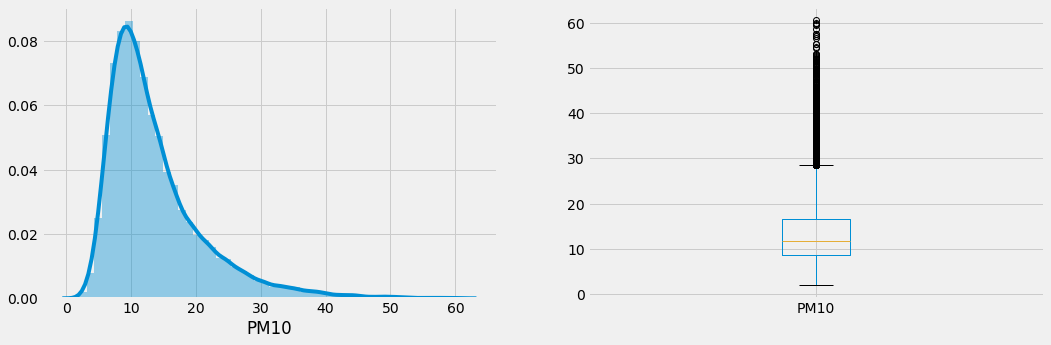

None


In [45]:
for r in train['region'].unique():
  t = train[train['region']==r]
  print(pm10(t))

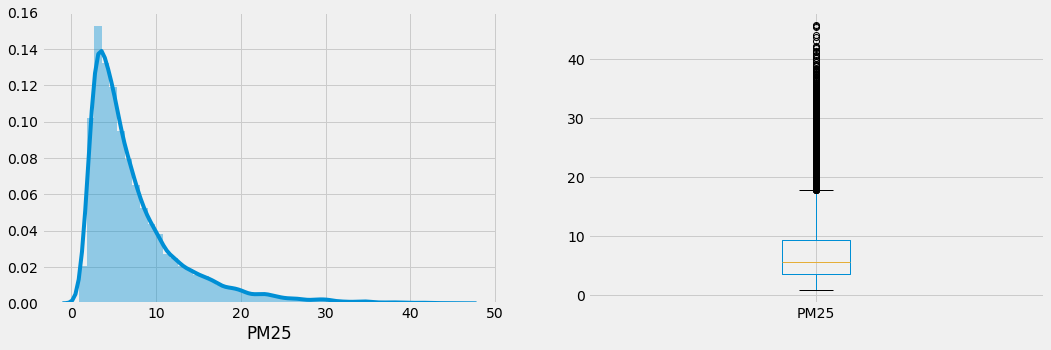

None


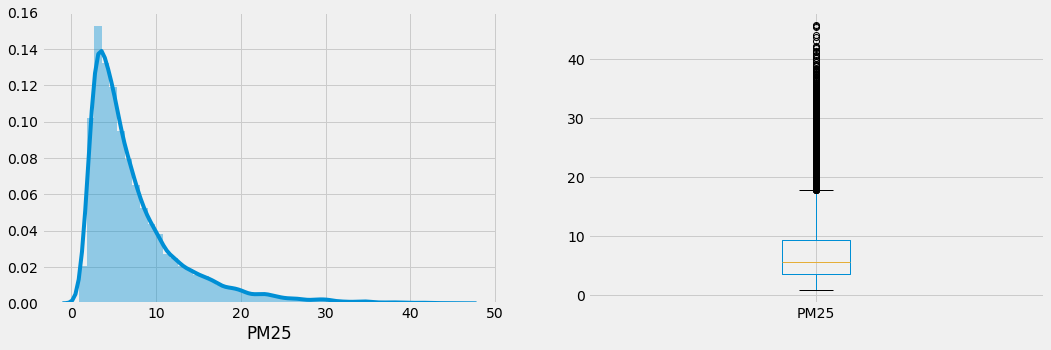

None


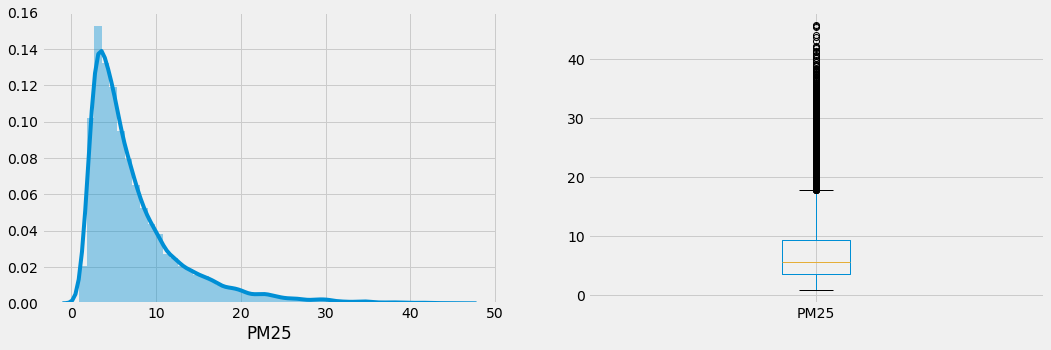

None


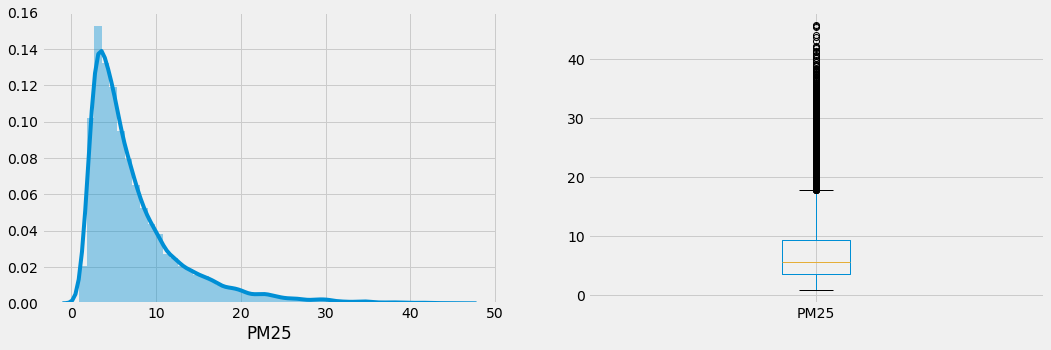

None


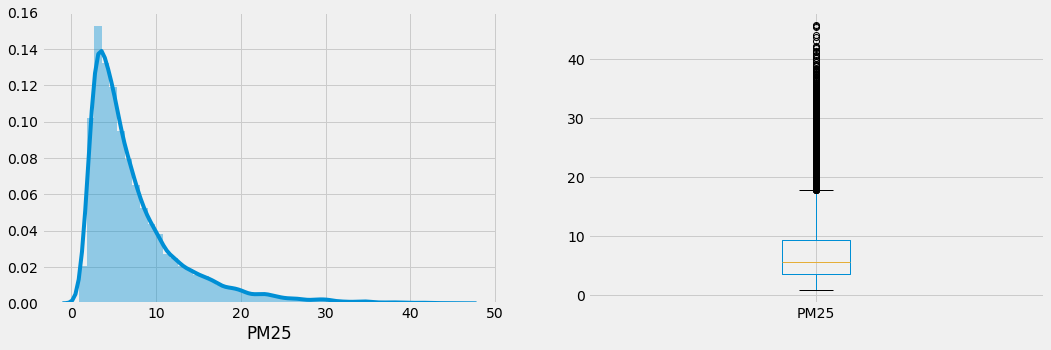

None


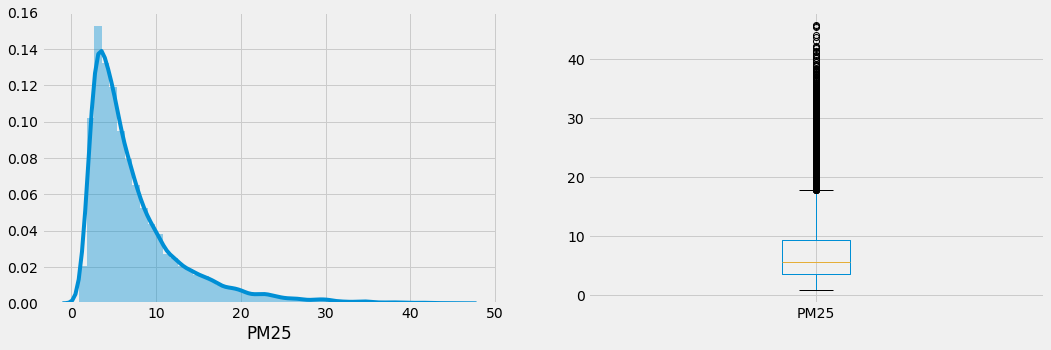

None


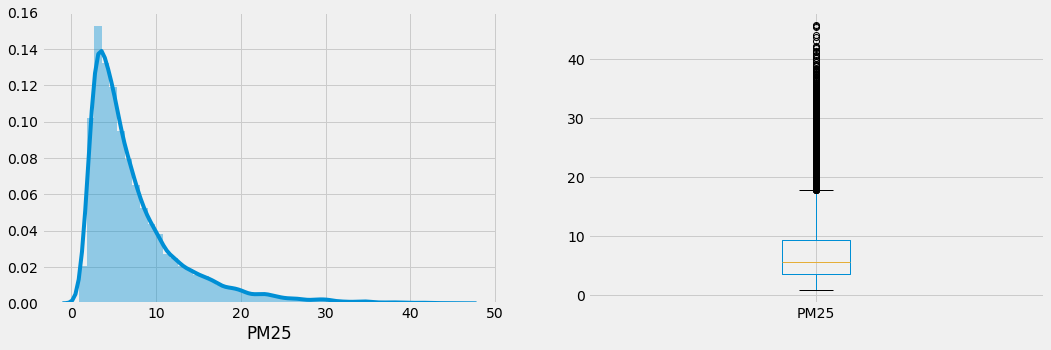

None


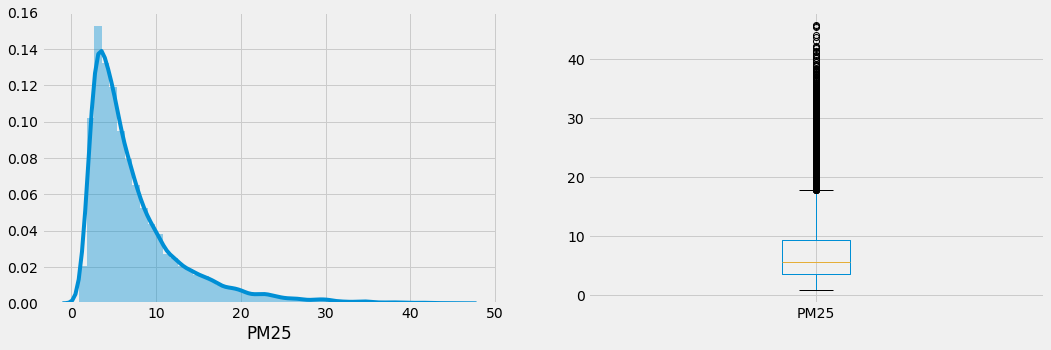

None


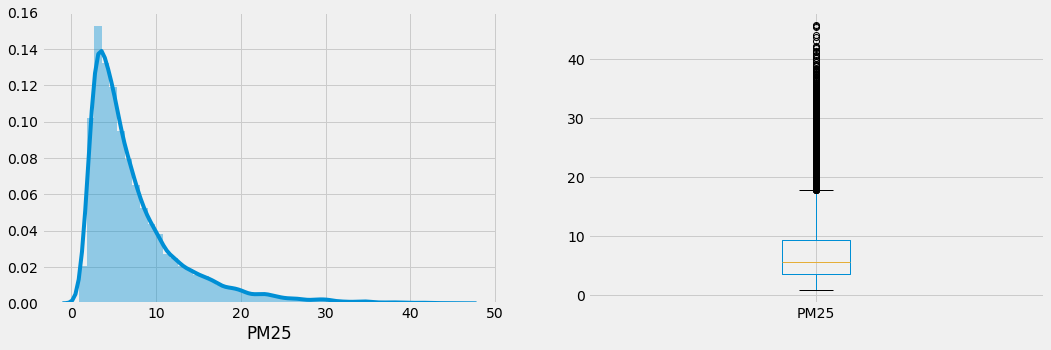

None


In [46]:
for r in train['region'].unique():
  t = train[train['region']==r]
  print(pm25(t))

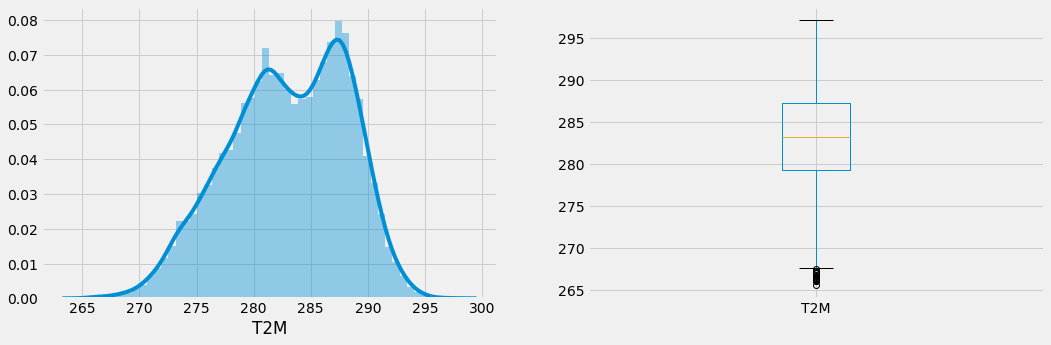

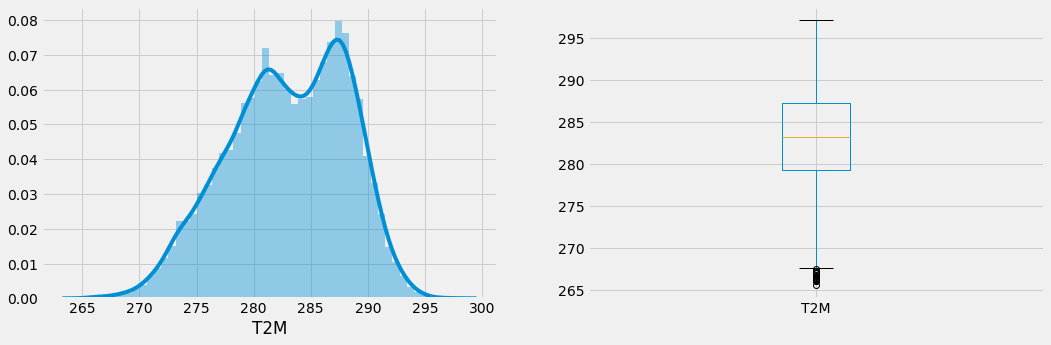

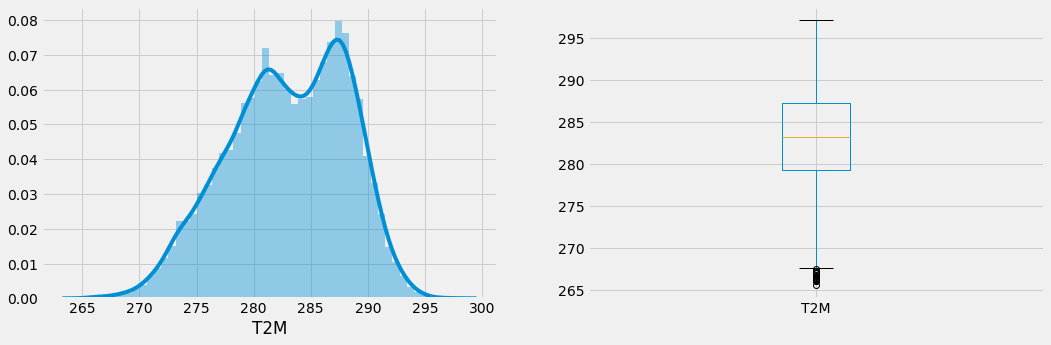

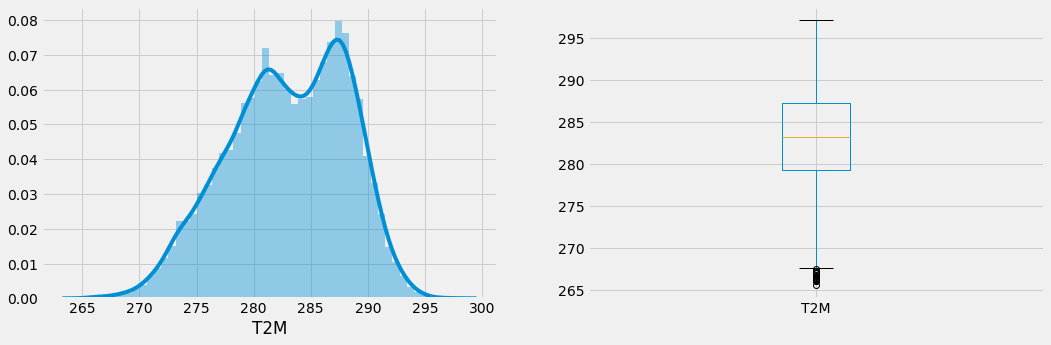

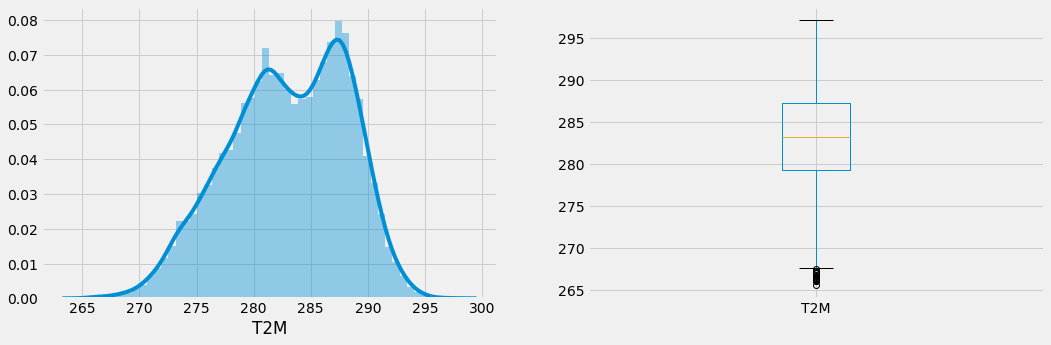

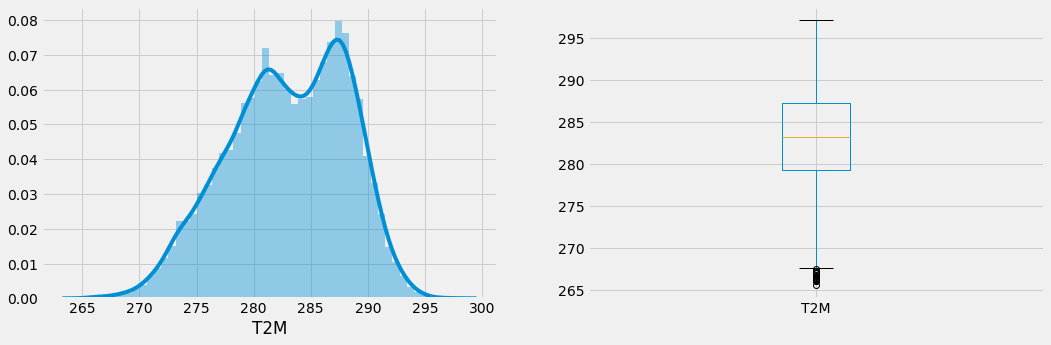

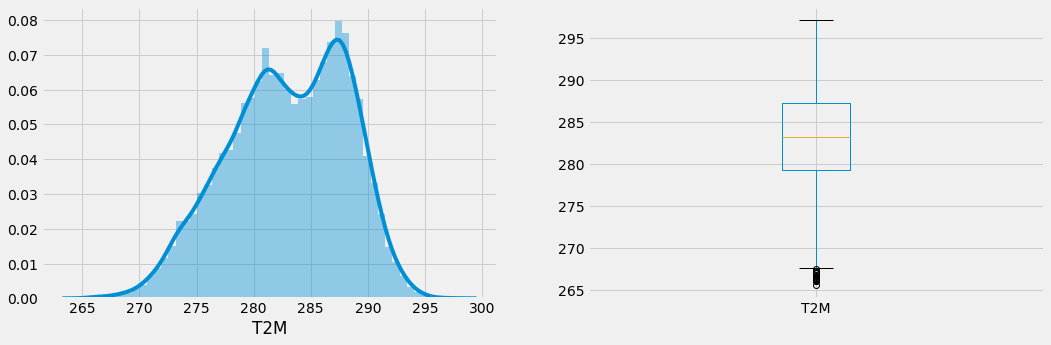

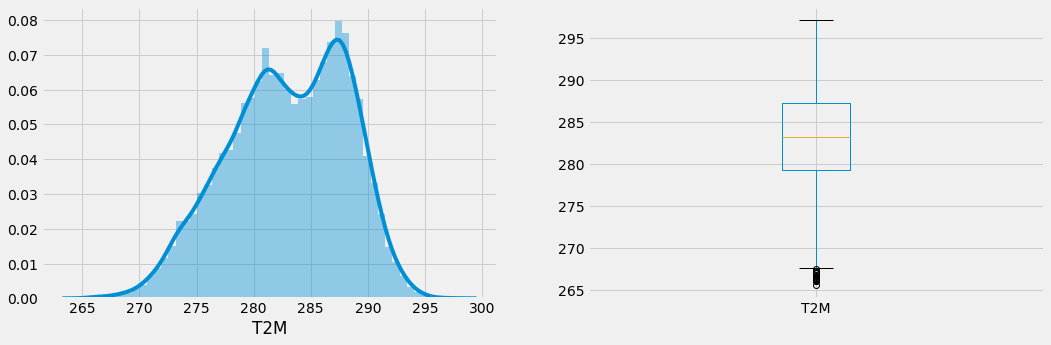

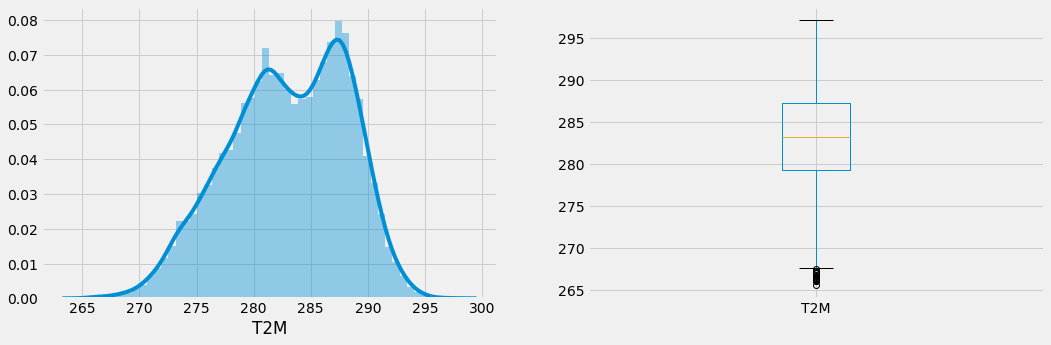

In [47]:
for r in train['region'].unique():
  t = train[train['region']==r]
  t2m(t)

In [0]:
#train1.groupby("region")["Region"].unique()

In [49]:
train1.head()

date  mortality_rate      O3  ...      T2M       Code      Region
0 2007-01-02           2.264  42.358  ...  278.138  E12000001  North East
1 2007-01-03           2.030  49.506  ...  281.745  E12000001  North East
2 2007-01-04           1.874  51.101  ...  280.523  E12000001  North East
3 2007-01-05           2.069  47.478  ...  280.421  E12000001  North East
4 2007-01-06           1.913  45.226  ...  278.961  E12000001  North East

[5 rows x 9 columns]

## Transformations

# Bivariate analysis - Region Wise

### variation with date - time series plot ##

### For region 1 - North East

In [50]:
train_r1 = train1[train1["Region"]=="North East"]
fig1 = px.line(train_r1, x='date', y='mortality_rate')
fig1.show()

In [51]:
fig2 = go.Figure([go.Scatter(x=train_r1['date'], y=train_r1['mortality_rate'])])
#fig2.show()

fig2.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)

In [52]:
fig3 = go.Figure([go.Scatter(x=train_r1['date'], y=train_r1["O3"])])
#fig2.show()

fig3.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)

In [53]:
fig2 = go.Figure([go.Scatter(x=train_r1['date'], y=train_r1["PM10"])])
#fig2.show()

fig2.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)

In [54]:
fig4 = go.Figure([go.Scatter(x=train_r1['date'], y=train_r1["PM25"])])
#fig2.show()

fig4.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)

In [55]:
fig5 = go.Figure([go.Scatter(x=train_r1['date'], y=train_r1["NO2"])])
#fig2.show()

fig5.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)

### scatter plot of PM25 with other varibles ###

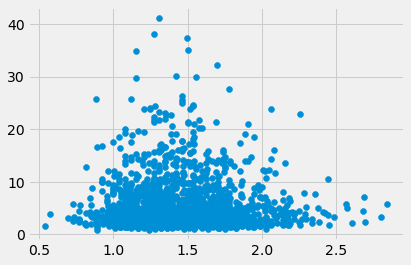

In [56]:
plt.scatter(x=train_r1['mortality_rate'], y=train_r1["PM25"])

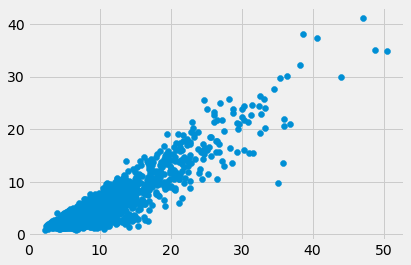

In [57]:
plt.scatter(x=train_r1['PM10'], y=train_r1["PM25"])

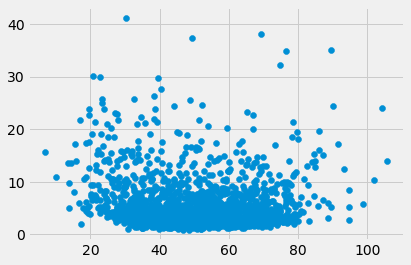

In [58]:
plt.scatter(x=train_r1['O3'], y=train_r1["PM25"])

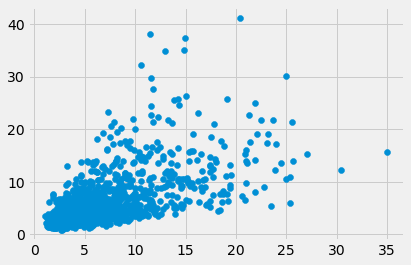

In [59]:
plt.scatter(x=train_r1['NO2'], y=train_r1["PM25"])

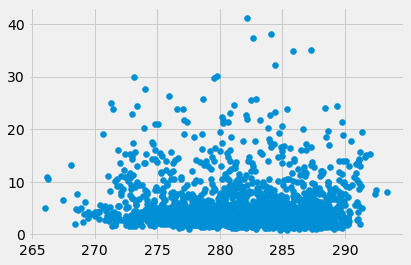

In [60]:
plt.scatter(x=train_r1['T2M'], y=train_r1["PM25"])

### scatter plot of NO2 with other variables ###

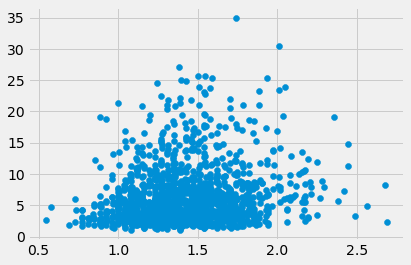

In [61]:
plt.scatter(x=train_r1['mortality_rate'], y=train_r1["NO2"])

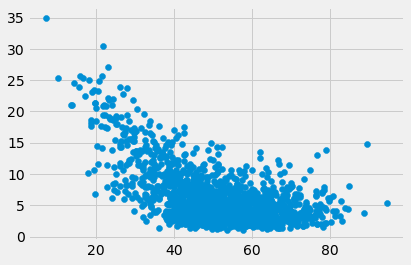

In [62]:
plt.scatter(x=train_r1['O3'], y=train_r1["NO2"])

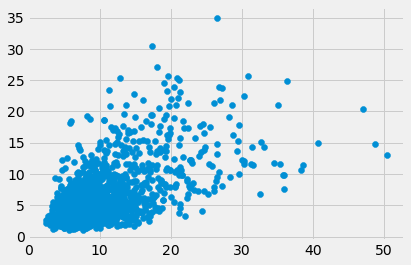

In [63]:
plt.scatter(x=train_r1['PM10'], y=train_r1["NO2"])

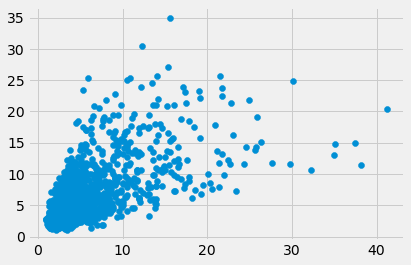

In [64]:
plt.scatter(x=train_r1['PM25'], y=train_r1["NO2"])

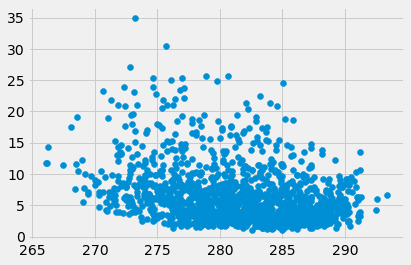

In [65]:
plt.scatter(x=train_r1['T2M'], y=train_r1["NO2"])

## Missing value imputation using MICE 

#### For Region1 - North East

In [66]:
train_r1.head()

date  mortality_rate      O3  ...      T2M       Code      Region
0 2007-01-02           2.264  42.358  ...  278.138  E12000001  North East
1 2007-01-03           2.030  49.506  ...  281.745  E12000001  North East
2 2007-01-04           1.874  51.101  ...  280.523  E12000001  North East
3 2007-01-05           2.069  47.478  ...  280.421  E12000001  North East
4 2007-01-06           1.913  45.226  ...  278.961  E12000001  North East

[5 rows x 9 columns]

In [67]:
train_r1.isna().sum()

date                0
mortality_rate      0
O3                  1
PM10                1
PM25              364
NO2               730
T2M                 0
Code                0
Region              0
dtype: int64

In [68]:
train_r1.drop(columns=["date", "Code", "Region"], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
from impyute.imputation.cs import mice

# start the MICE training
train_r1_imp=mice(train_r1.values)

In [0]:
train_r1_imp = pd.DataFrame(train_r1_imp, columns = ["mortality_rate", "O3", "PM10", "PM25","NO2","T2M"])

In [71]:
train_r1_imp.isna().sum()

mortality_rate    0
O3                0
PM10              0
PM25              0
NO2               0
T2M               0
dtype: int64

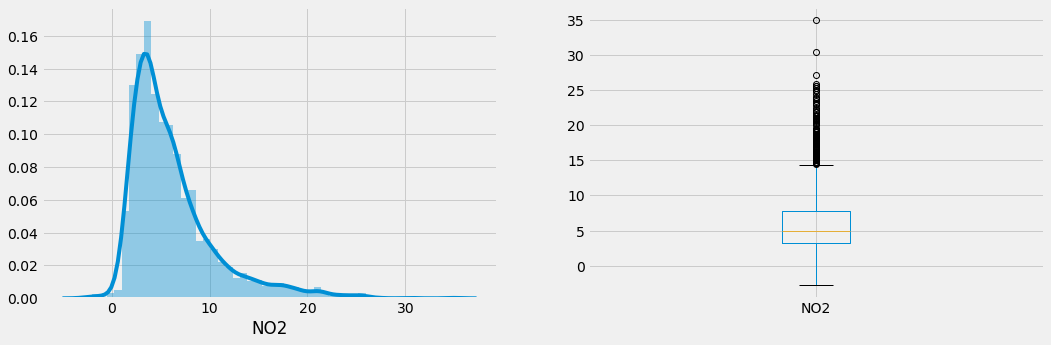

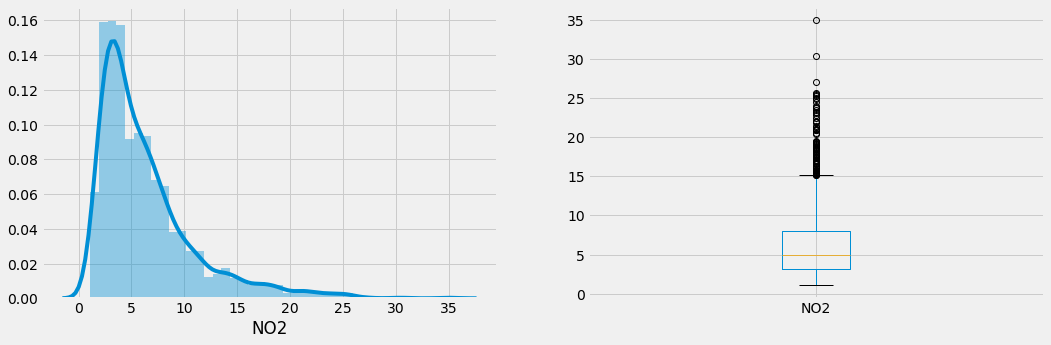

In [72]:
# Visualizing NO2
# plt.figure(1)
plt.subplot(121)
NO2_1 = train_r1_imp['NO2'].dropna()
sns.distplot(NO2_1);

plt.subplot(122)
NO2_1.plot.box(figsize=(16,5))

plt.show()


plt.subplot(121)
NO2_1 = train_r1['NO2'].dropna()
sns.distplot(NO2_1);

plt.subplot(122)
NO2_1.plot.box(figsize=(16,5))

plt.show()

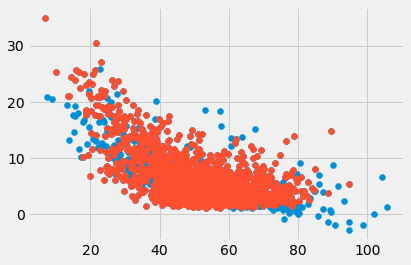

In [73]:
plt.scatter(x=train_r1_imp['O3'], y=train_r1_imp["NO2"])
plt.scatter(x=train_r1['O3'], y=train_r1["NO2"])

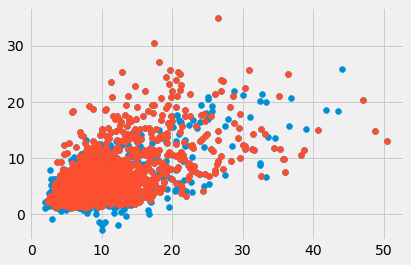

In [74]:
plt.scatter(x=train_r1_imp['PM10'], y=train_r1_imp["NO2"])
plt.scatter(x=train_r1['PM10'], y=train_r1["NO2"])

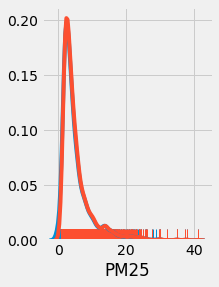

In [75]:
# Visualizing NO2
# plt.figure(1)
plt.subplot(121)
NO2_1_imp = train_r1_imp['PM25'].dropna()
NO2_1 = train_r1['PM25'].dropna()
#sns.distplot(NO2_1_imp)
#sns.distplot(NO2_1)

sns.distplot(NO2_1_imp, hist=False, rug=True)
sns.distplot(NO2_1, hist=False, rug=True)


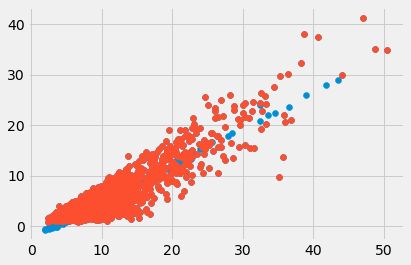

In [76]:
plt.scatter(x=train_r1_imp['PM10'], y=train_r1_imp["PM25"])
plt.scatter(x=train_r1['PM10'], y=train_r1["PM25"])

In [77]:
train_r1_imp['PM25'].describe(), train_r1['PM25'].describe()

(count    2191.000000
 mean        5.203044
 std         4.765004
 min        -0.656271
 25%         2.325434
 50%         3.636000
 75%         6.168487
 max        41.255000
 Name: PM25, dtype: float64, count    1827.000000
 mean        5.368816
 std         4.773007
 min         0.904000
 25%         2.451500
 50%         3.802000
 75%         6.269000
 max        41.255000
 Name: PM25, dtype: float64)

In [0]:
## changing negative values to min value
train_r1_imp['PM25'] = np.where(train_r1_imp['PM25']<=0, 0.904000, train_r1_imp['PM25'] )

In [79]:
train_r1_imp['NO2'].describe(), train_r1['NO2'].describe()

(count    2191.000000
 mean        6.164154
 std         4.378407
 min        -2.754285
 25%         3.228438
 50%         4.988000
 75%         7.738791
 max        34.990000
 Name: NO2, dtype: float64, count    1461.000000
 mean        6.353291
 std         4.572821
 min         1.104000
 25%         3.172000
 50%         4.988000
 75%         7.971000
 max        34.990000
 Name: NO2, dtype: float64)

In [0]:
## changing negative values to min value
train_r1_imp['NO2'] = np.where(train_r1_imp['NO2']<=0, 1.104000, train_r1_imp['NO2'] )

#### Since we are getting good enough results region wise we can impute PM25 and NO2 on the basis of regions

### Region wise imputation

In [81]:
train1.head()

date  mortality_rate      O3  ...      T2M       Code      Region
0 2007-01-02           2.264  42.358  ...  278.138  E12000001  North East
1 2007-01-03           2.030  49.506  ...  281.745  E12000001  North East
2 2007-01-04           1.874  51.101  ...  280.523  E12000001  North East
3 2007-01-05           2.069  47.478  ...  280.421  E12000001  North East
4 2007-01-06           1.913  45.226  ...  278.961  E12000001  North East

[5 rows x 9 columns]

In [82]:
regions = list(region["Region"].values)
train_imp = pd.DataFrame()

for reg in regions:
    
    train_r = train1[train1["Region"] == reg].reset_index(drop=True)
    train_r_imp = mice(train_r.drop(["date", "Code", "Region"], axis = 1).values)
    train_r_imp = pd.DataFrame(train_r_imp, columns = ["mortality_rate", "O3", "PM10", "PM25","NO2","T2M"])
    
    ## changing negative values to min value
    train_r_imp['PM25'] = np.where(train_r_imp['PM25']<=0, min(train_r['PM25']), train_r_imp['PM25'] )
    
    ## changing negative values to min value
    train_r_imp['NO2'] = np.where(train_r_imp['NO2']<=0, min(train_r['NO2']), train_r_imp['NO2'] )
    
    print("\n\n")
    print("train_r = before", train_r.isna().sum())
    
    train_r['PM25'] = train_r_imp['PM25']
    train_r['NO2'] = train_r_imp['NO2']
    train_r['O3'] = train_r_imp['O3']
    train_r['PM10'] = train_r_imp['PM10']
    
    print("train_r_imp = \n", train_r_imp.isna().sum())
    print("train_r = \n", train_r.isna().sum())
    print("----------------------------------------")
    
    train_imp = train_imp.append(train_r)
    
print("train_imp = ", train_imp.isna().sum(), '\n')
    
    




train_r = before date                0
mortality_rate      0
O3                  1
PM10                1
PM25              364
NO2               730
T2M                 0
Code                0
Region              0
dtype: int64
train_r_imp = 
 mortality_rate     0
O3                 0
PM10               0
PM25              13
NO2                8
T2M                0
dtype: int64
train_r = 
 date               0
mortality_rate     0
O3                 0
PM10               0
PM25              13
NO2                8
T2M                0
Code               0
Region             0
dtype: int64
----------------------------------------



train_r = before date                0
mortality_rate      0
O3                  1
PM10                1
PM25              364
NO2               730
T2M                 0
Code                0
Region              0
dtype: int64
train_r_imp = 
 mortality_rate    0
O3                0
PM10              0
PM25              5
NO2               3
T2M         

In [0]:
pd.set_option('display.max_rows', None)
#train_imp
                                    

In [84]:
train_imp.head()

date  mortality_rate      O3  ...      T2M       Code      Region
0 2007-01-02           2.264  42.358  ...  278.138  E12000001  North East
1 2007-01-03           2.030  49.506  ...  281.745  E12000001  North East
2 2007-01-04           1.874  51.101  ...  280.523  E12000001  North East
3 2007-01-05           2.069  47.478  ...  280.421  E12000001  North East
4 2007-01-06           1.913  45.226  ...  278.961  E12000001  North East

[5 rows x 9 columns]

In [85]:
temp_r_imp = mice(train_imp.drop(columns=['date','Code','Region']).values)
temp_r_imp = pd.DataFrame(temp_r_imp, columns = ["mortality_rate", "O3", "PM10", "PM25","NO2","T2M"])

train_r_imp_full = train_imp.copy()
train_r_imp_full["NO2"] = temp_r_imp["NO2"]
train_r_imp_full["PM25"] = temp_r_imp["PM25"]
train_r_imp_full["O3"] = temp_r_imp["O3"]
train_r_imp_full["PM10"] = temp_r_imp["PM10"]

train_r_imp_full.isna().sum()  #### FINAL DATAFRAME WITH IMPUTED VALUES REGION WISE

date              0
mortality_rate    0
O3                0
PM10              0
PM25              0
NO2               0
T2M               0
Code              0
Region            0
dtype: int64

In [86]:
train_r_imp_full.shape, train1.shape

((18403, 9), (18403, 9))

In [87]:
train_r_imp_full.head()

date  mortality_rate      O3  ...      T2M       Code      Region
0 2007-01-02           2.264  42.358  ...  278.138  E12000001  North East
1 2007-01-03           2.030  49.506  ...  281.745  E12000001  North East
2 2007-01-04           1.874  51.101  ...  280.523  E12000001  North East
3 2007-01-05           2.069  47.478  ...  280.421  E12000001  North East
4 2007-01-06           1.913  45.226  ...  278.961  E12000001  North East

[5 rows x 9 columns]

In [88]:
train_r_imp_full['NO2'].describe()

count    18403.000000
mean         6.137423
std          4.403698
min         -5.495204
25%          3.220000
50%          4.971415
75%          7.737107
max         34.990000
Name: NO2, dtype: float64

In [89]:
train1['NO2'].describe()

count    11833.000000
mean        12.045813
std          8.296675
min          1.104000
25%          6.056000
50%          9.769000
75%         15.858000
max         76.765000
Name: NO2, dtype: float64

In [90]:
train_r_imp_full['PM25'].describe()

count    18403.000000
mean         5.162043
std          4.756403
min         -0.993929
25%          2.272000
50%          3.572000
75%          6.127000
max         41.255000
Name: PM25, dtype: float64

In [91]:
train1['PM25'].describe()

count    15127.000000
mean         7.498714
std          5.758357
min          0.904000
25%          3.624000
50%          5.636000
75%          9.326500
max         45.846000
Name: PM25, dtype: float64

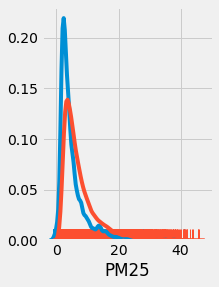

In [92]:
plt.subplot(121)
NO2_1= train1['PM25'].dropna()
NO2_1_imp  = train_r_imp_full['PM25'].dropna()

sns.distplot(NO2_1_imp, hist=False, rug=True)
sns.distplot(NO2_1, hist=False, rug=True)

Region wise imputation is fine but at an overall level it does not suits well..

### Impution on full data - MICE

In [0]:
# start the MICE training
temp_imp = mice(train1.drop(["date", "Code", "Region"], axis = 1).values)
temp_imp = pd.DataFrame(temp_imp, columns = ["mortality_rate", "O3", "PM10", "PM25","NO2","T2M"])

train_full_imp = train1.copy()
train_full_imp["NO2"] = temp_imp["NO2"]
train_full_imp["PM25"] = temp_imp["PM25"]
train_full_imp["O3"] = temp_imp["O3"]
train_full_imp["PM10"] = temp_imp["PM10"]

In [94]:
train_full_imp.isna().sum() ### FINAL DATAFRAME WITH IMPUTATION ON FULL DATA

date              0
mortality_rate    0
O3                0
PM10              0
PM25              0
NO2               0
T2M               0
Code              0
Region            0
dtype: int64

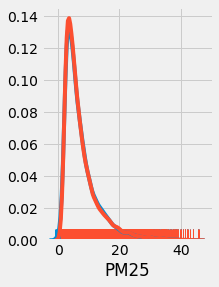

In [95]:
plt.subplot(121)
NO2_1= train1['PM25'].dropna()
NO2_1_imp  = train_full_imp['PM25'].dropna()

sns.distplot(NO2_1_imp, hist=False, rug=True)
sns.distplot(NO2_1, hist=False, rug=True)

#  Feature Engeering

one hot encoding for regions

In [0]:
dummy1= pd.get_dummies(train['region'])
train_f = train.join(dummy1)

dummy2= pd.get_dummies(test['region'])
test_f = test.join(dummy2)

In [97]:
train_f.shape,test_f.shape

((18403, 17), (7886, 16))

doy (day of year) and year

In [0]:
train_f['year'] = train_f['date'].map(lambda x: x.year)
test_f['year'] = test_f['date'].map(lambda x: x.year)

train_f['year^2'] = train_f['year']**2
test_f['year^2'] = test_f['year']**2

train_f['doy'] = train_f['date'].map(lambda x: x.dayofyear)
test_f['doy'] = test_f['date'].map(lambda x: x.dayofyear)

train_f['doy^2'] = train_f['doy']**2
test_f['doy^2'] = test_f['doy']**2

Log Transformation

In [0]:
train_f['NO2_log']=np.log(train_f['NO2'])
train_f['PM10_log']=np.log(train_f['PM10'])
train_f['PM25_log']=np.log(train_f['PM25'])

test_f['NO2_log']=np.log(test_f['NO2'])
test_f['PM10_log']=np.log(test_f['PM10'])
test_f['PM25_log']=np.log(test_f['PM25'])

In [0]:
#train_f.info(),test_f.info()

In [0]:
total_f=total=pd.concat([train_f,test_f],sort=False)

In [0]:
total_f['T2M_rolling'] = total_f.groupby('region')['T2M'].transform(lambda x: x.rolling(30).mean())

In [103]:
total_f.shape

(26289, 25)

#  Modelling

## Dropping Missing Values

In [0]:
train_f=total_f[:18403].dropna()
test_f=total_f[18403:].drop(['mortality_rate'],axis=1)

In [105]:
train_f.shape,test_f.shape

((11833, 25), (7886, 24))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_f.drop(['mortality_rate'],axis=1), train_f['mortality_rate'], test_size=0.2)

In [0]:
RMSE= make_scorer(metrics.mean_squared_error)

In [0]:
X=train_f.drop(['mortality_rate'],axis=1)
y=train_f['mortality_rate']

### Predictor Set 1

In [0]:
predictors=['O3','PM10','PM25','NO2','T2M']

#### Regularized Linear Regression without CV

##### Ridge Regression

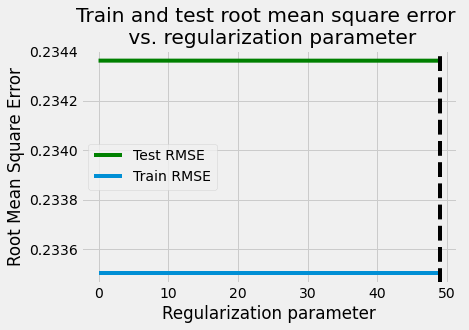

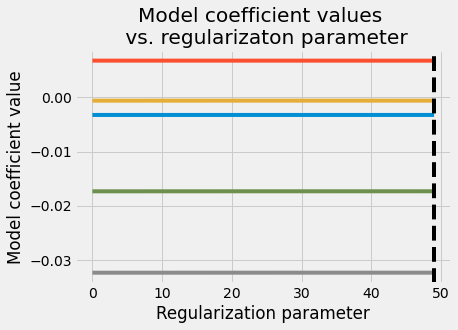

(49, 0.2343624656929934)

MSE = 0.05492576532569951
RMSE =0.2343624656929934
Mean Absolute Error =0.18307320123963072
Median Absolute Error  = 0.15209967613369968
R^2                    = 0.34669221311633336


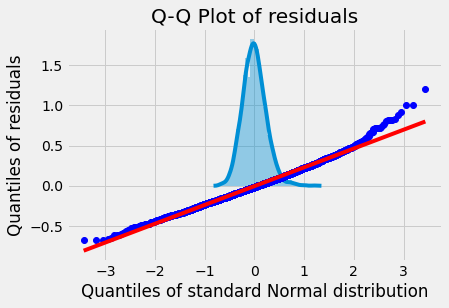

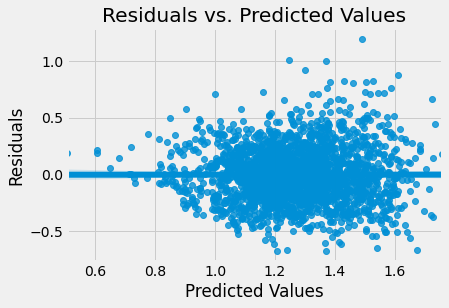

In [127]:
ridge(X_train[predictors],y_train,X_test[predictors],y_test)

##### Lasso Regression

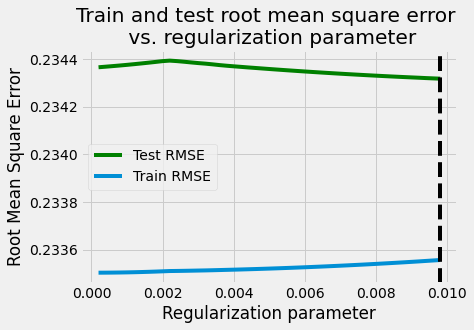

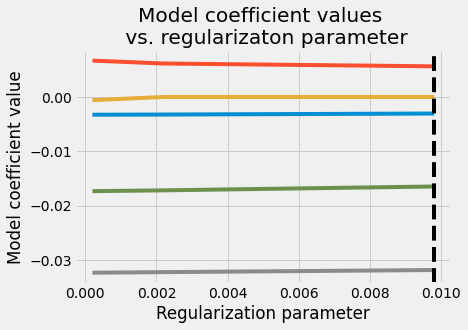

(0.0098, 0.23431716389671567)

MSE = 0.05490453329660032
RMSE =0.23431716389671567
Mean Absolute Error =0.18297643706847325
Median Absolute Error  = 0.1522334085242789
R^2                    = 0.3469447548853847


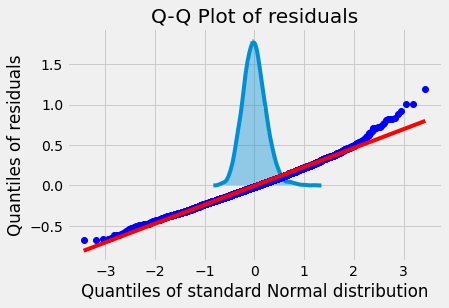

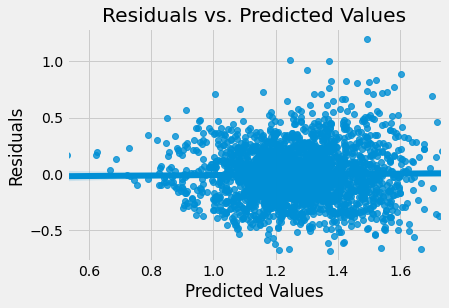

In [123]:
lasso(X_train[predictors],y_train,X_test[predictors],y_test)

#### CV Model

In [128]:
models = [
    LinearRegression(),
    linear_model.Lasso(alpha=0.0098),
    Ridge(alpha=49),
    RandomForestRegressor(max_depth=2, random_state=0),
]
CV = 5
for model in models:
    model_name = model.__class__.__name__
    
    accuracies = cross_val_score(model,X[predictors], y,scoring=RMSE, cv=CV)
    
    print(model_name,"RMSE",np.sqrt(accuracies),"\n")
    print("average RMSE :", np.sqrt(accuracies).mean(),"\n","\n")

LinearRegression RMSE [0.25590564 0.2384088  0.23534413 0.24975171 0.21540355] 

average RMSE : 0.23896276599941646 
 

Lasso RMSE [0.25663464 0.23869078 0.23564212 0.24957773 0.21430635] 

average RMSE : 0.23897032276208613 
 

Ridge RMSE [0.25591206 0.23841334 0.23534448 0.24975198 0.21539392] 

average RMSE : 0.23896315757779935 
 

RandomForestRegressor RMSE [0.27209648 0.25170445 0.26211702 0.26120663 0.21941687] 

average RMSE : 0.2533082876488943 
 



### Predictor Set 2

In [0]:
predictors=['O3','PM10','PM25','NO2_log','T2M']

#### Regularized Linear Regression without CV

##### Ridge Regression

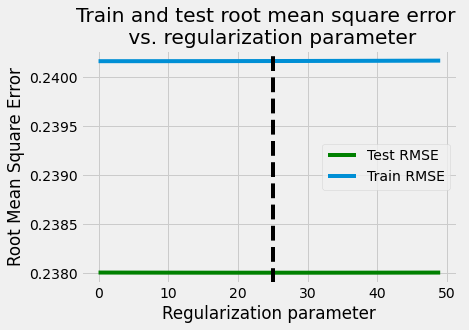

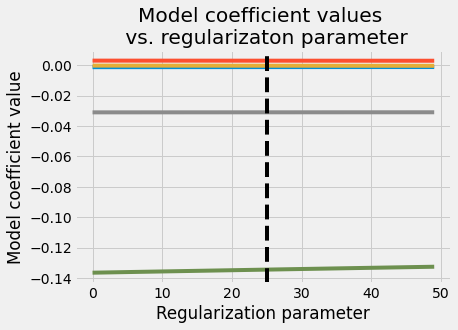

(25, 0.23800193040077172)

MSE = 0.05664491887449379
RMSE =0.23800193040077172
Mean Absolute Error =0.18713251159771382
Median Absolute Error  = 0.15374116464634047
R^2                    = 0.32624395183829746


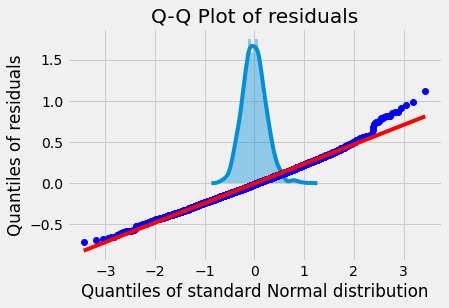

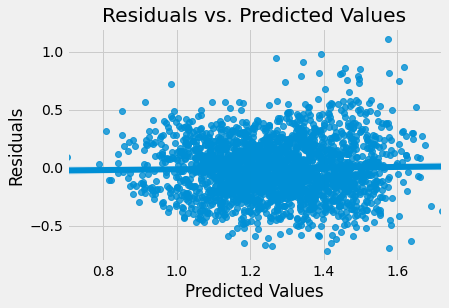

In [130]:
ridge(X_train[predictors],y_train,X_test[predictors],y_test)

##### Lasso Regression

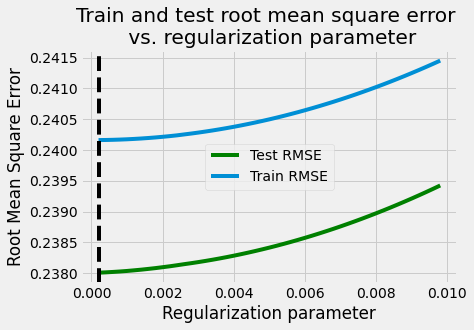

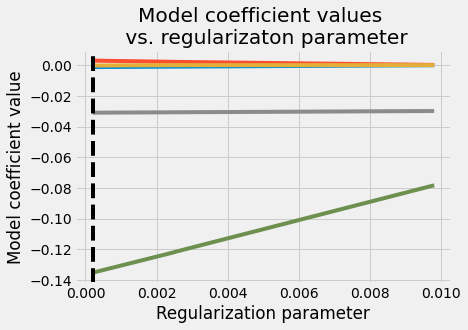

(0.0002, 0.23800782096708173)

MSE = 0.05664772284149843
RMSE =0.23800782096708173
Mean Absolute Error =0.1871476943846006
Median Absolute Error  = 0.1536363013610369
R^2                    = 0.3262106003962659


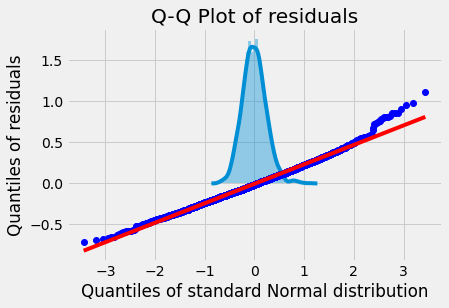

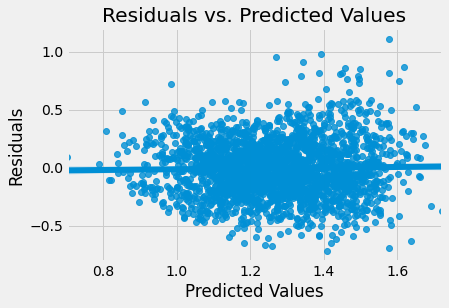

In [131]:
lasso(X_train[predictors],y_train,X_test[predictors],y_test)

In [132]:
models = [
    LinearRegression(),
    linear_model.Lasso(alpha=0.002),
    Ridge(alpha=25),
    RandomForestRegressor(max_depth=2, random_state=0),
]
CV = 5
for model in models:
    model_name = model.__class__.__name__
    
    accuracies = cross_val_score(model,X[predictors], y,scoring=RMSE, cv=CV)
    
    print(model_name,"RMSE",np.sqrt(accuracies),"\n")
    print("average RMSE :", np.sqrt(accuracies).mean(),"\n","\n")

LinearRegression RMSE [0.26527521 0.24409334 0.24623856 0.25499492 0.21608415] 

average RMSE : 0.24533723378104755 
 

Lasso RMSE [0.26572951 0.24430576 0.24678138 0.25485295 0.21511459] 

average RMSE : 0.2453568390021071 
 

Ridge RMSE [0.2653397  0.24412219 0.246327   0.25494357 0.21591051] 

average RMSE : 0.24532859445263783 
 

RandomForestRegressor RMSE [0.27209715 0.25170576 0.26211702 0.26120663 0.21941673] 

average RMSE : 0.253308657930002 
 



-LinearRegression      0.2453372337810475 
-Lasso                 0.25363080541258476  
-Ridge                 0.24533682390299894 
-RandomForestRegressor 0.253308657930002   

-LB socre
-LinearRegression  0.   
-Lasso             0. 
-Ridge             0. 
-RandomForestRegressor 0. 

### Predictor Set 3

In [0]:
predictors=['O3','PM10','PM25_log','NO2_log','T2M']

#### Regularized Linear Regression without CV

##### Ridge Regression

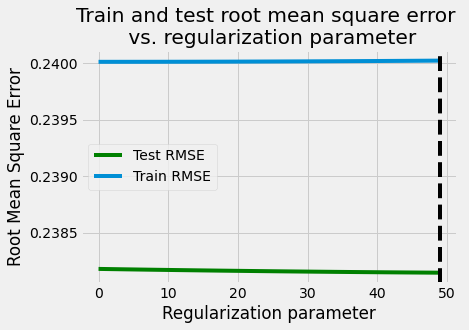

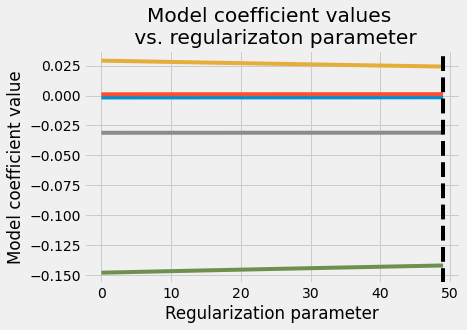

(49, 0.23814715658992505)

MSE = 0.056714068191866286
RMSE =0.23814715658992505
Mean Absolute Error =0.18731822231189993
Median Absolute Error  = 0.1541089692668931
R^2                    = 0.3254214637540759


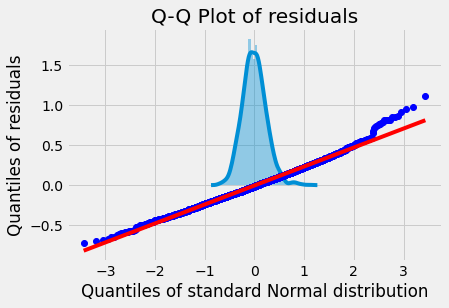

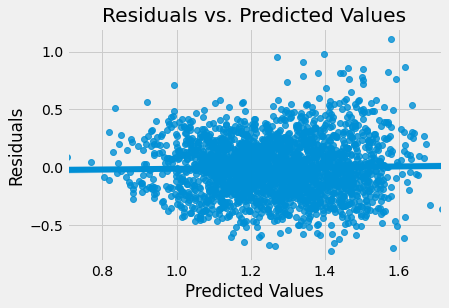

In [134]:
ridge(X_train[predictors],y_train,X_test[predictors],y_test)

##### Lasso Regression

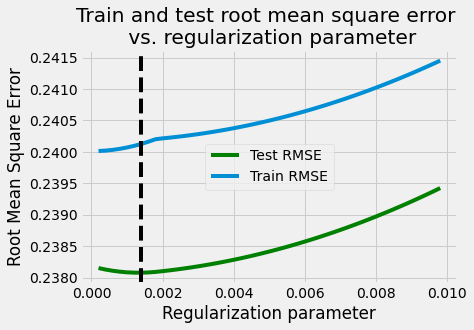

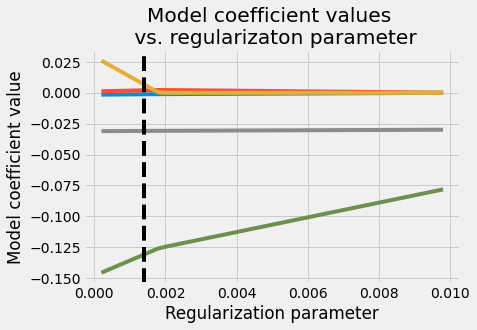

(0.0014, 0.2380785835624419)

MSE = 0.05668141195109864
RMSE =0.2380785835624419
Mean Absolute Error =0.18711037171620626
Median Absolute Error  = 0.1539328205614685
R^2                    = 0.32580988940927325


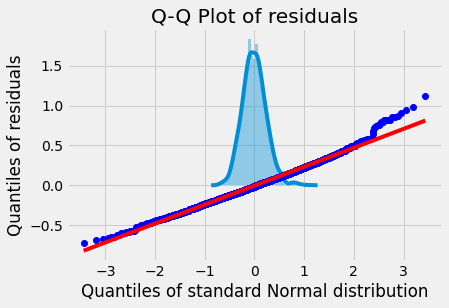

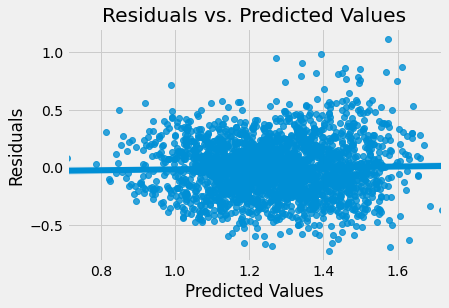

In [135]:
lasso(X_train[predictors],y_train,X_test[predictors],y_test)

In [137]:
models = [
    LinearRegression(),
    Lasso(alpha=0.0014),
    Ridge(alpha=49),
    RandomForestRegressor(max_depth=2)
]
CV = 5
for model in models:
    model_name = model.__class__.__name__
    
    accuracies = cross_val_score(model,X[predictors], y,scoring=RMSE, cv=CV)
    
    print(model_name,"RMSE",np.sqrt(accuracies),"\n")
    print("average RMSE :", np.sqrt(accuracies).mean(),"\n","\n")

LinearRegression RMSE [0.26573681 0.24385109 0.24598684 0.25584064 0.21617526] 

average RMSE : 0.24551812699677641 
 

Lasso RMSE [0.26568831 0.24386428 0.24649168 0.2551565  0.21526707] 

average RMSE : 0.2452935676632393 
 

Ridge RMSE [0.26579072 0.24388459 0.24617146 0.25562726 0.21572752] 

average RMSE : 0.2454403118695489 
 

RandomForestRegressor RMSE [0.27239033 0.25193767 0.26231458 0.26113029 0.21915916] 

average RMSE : 0.2533864050781358 
 



-LinearRegression      0.24551812699677633 
-Lasso                 0.25364131894103525  
-Ridge                 0.2455161592022304     
-RandomForestRegressor 0.253308657930002   

-LB socre
-LinearRegression  0. 
-Lasso             0.  
-Ridge             0.  
-RandomForestRegressor 0. 

### Predictor Set 4

In [0]:
predictors=['O3','PM10_log','PM25_log','NO2_log','T2M']

#### Regularized Linear Regression without CV

##### Ridge Regression

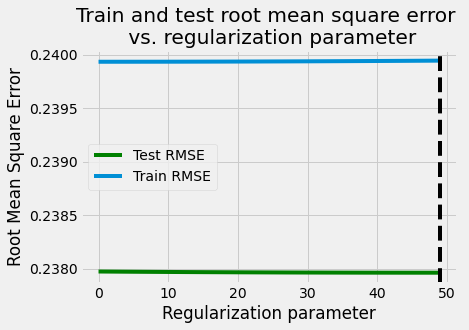

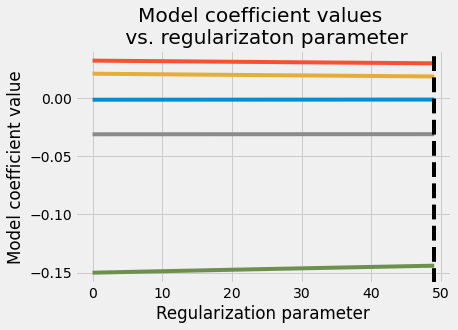

(49, 0.23796126562609415)

MSE = 0.05662556393837254
RMSE =0.23796126562609415
Mean Absolute Error =0.1871958489181682
Median Absolute Error  = 0.15407753009706315
R^2                    = 0.32647416675487917


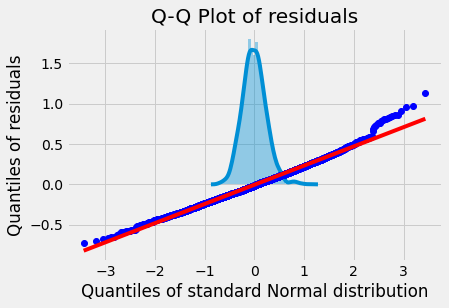

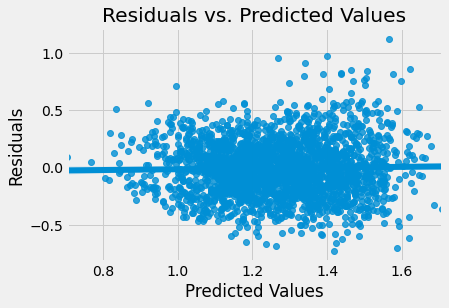

In [139]:
ridge(X_train[predictors],y_train,X_test[predictors],y_test)

##### Lasso Regression

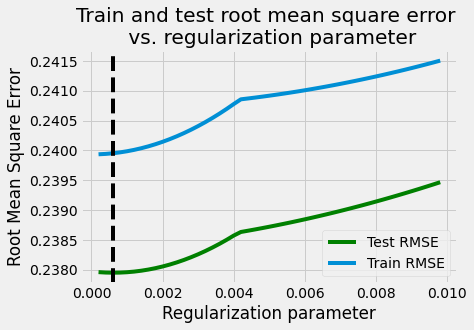

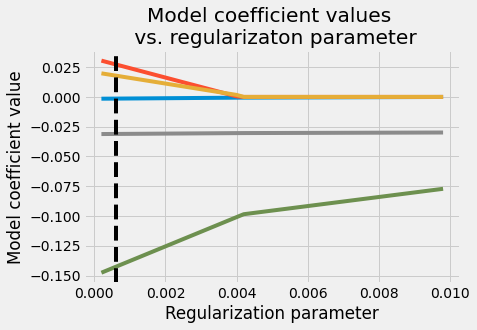

(0.0006, 0.23795136954913024)

MSE = 0.05662085427030674
RMSE =0.23795136954913024
Mean Absolute Error =0.18719209412773438
Median Absolute Error  = 0.15386910394472797
R^2                    = 0.32653018532472133


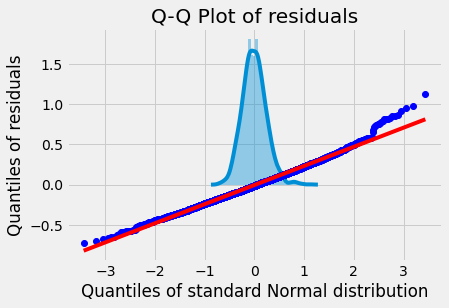

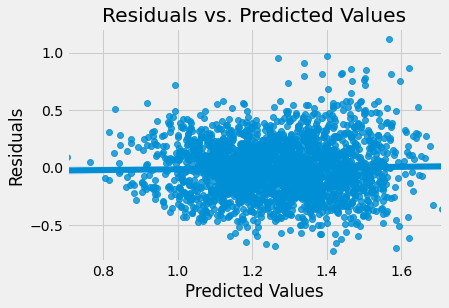

In [140]:
lasso(X_train[predictors],y_train,X_test[predictors],y_test)

In [141]:
models = [
    LinearRegression(),
    Lasso(alpha=0.0006),
    Ridge(alpha=49),
    RandomForestRegressor(max_depth=2, random_state=0),
]
CV = 5
for model in models:
    model_name = model.__class__.__name__
    
    accuracies = cross_val_score(model,X[predictors], y,scoring=RMSE, cv=CV)
    
    print(model_name,"RMSE",np.sqrt(accuracies),"\n")
    print("average RMSE :", np.sqrt(accuracies).mean(),"\n","\n")

LinearRegression RMSE [0.26538614 0.24372114 0.24603913 0.25564884 0.21685364] 

average RMSE : 0.24552977824727953 
 

Lasso RMSE [0.2654062  0.24399624 0.24626923 0.25527027 0.21623705] 

average RMSE : 0.24543579734596674 
 

Ridge RMSE [0.26547426 0.24377944 0.2462302  0.2554212  0.2162352 ] 

average RMSE : 0.24542806061198577 
 

RandomForestRegressor RMSE [0.27209715 0.25170576 0.26211702 0.26120663 0.21941673] 

average RMSE : 0.253308657930002 
 



-LinearRegression      0.24552977824727984 
-Lasso                 0.2536717498662236   
-Ridge                 0.2455272255973945      
-RandomForestRegressor 0.253308657930002   

-LB socre
-LinearRegression  0. 
-Lasso             0. 
-Ridge              0.  
-RandomForestRegressor 0. 

### Predictor Set 5

In [0]:
predictors=['O3','PM10_log','PM25_log','NO2_log','T2M_rolling']

#### Regularized Linear Regression without CV

##### Ridge Regression

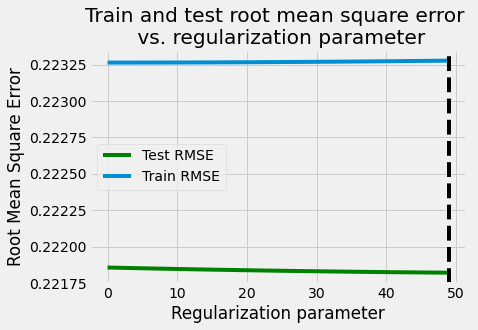

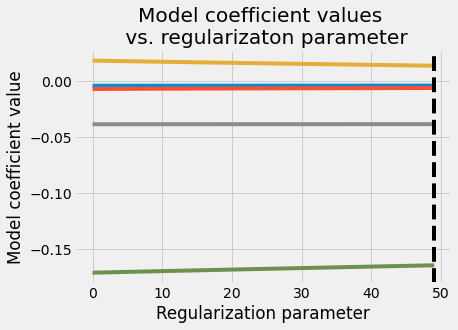

(49, 0.2218202458772421)

MSE = 0.049204221481040145
RMSE =0.2218202458772421
Mean Absolute Error =0.17501537983936058
Median Absolute Error  = 0.14549943796474263
R^2                    = 0.41474641544828195


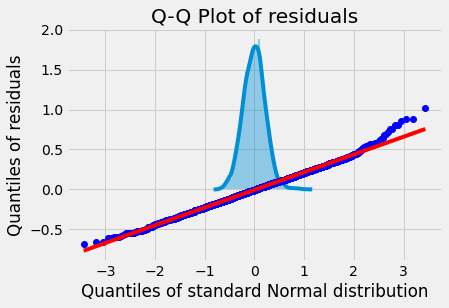

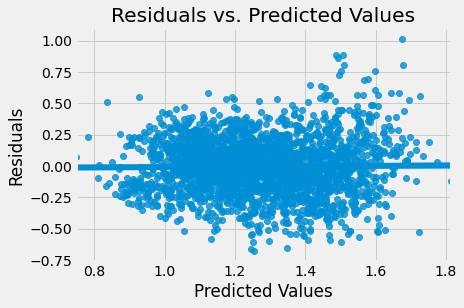

In [143]:
ridge(X_train[predictors],y_train,X_test[predictors],y_test)

##### Lasso Regression

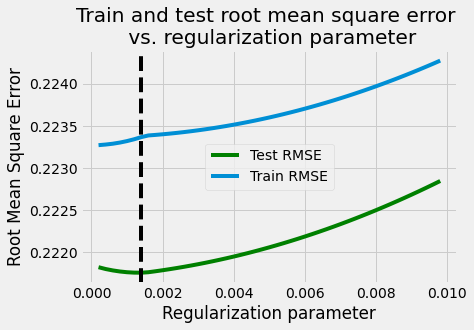

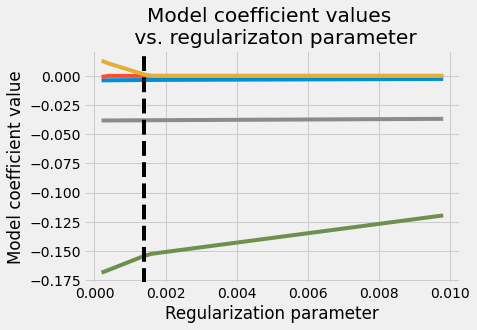

(0.0014, 0.22175425601645501)

MSE = 0.049174950061411475
RMSE =0.22175425601645501
Mean Absolute Error =0.1749344453112652
Median Absolute Error  = 0.14617966672019023
R^2                    = 0.41509458076310557


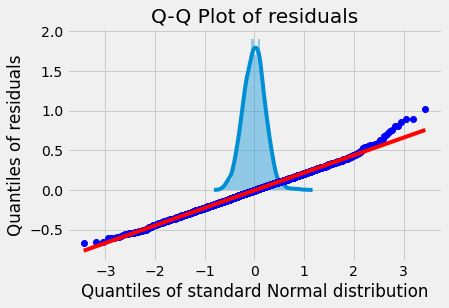

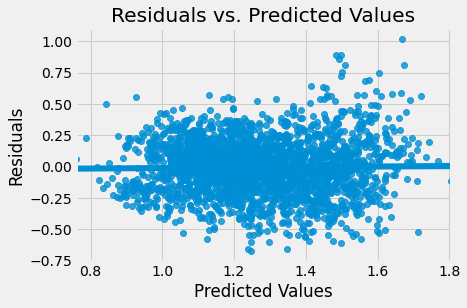

In [144]:
lasso(X_train[predictors],y_train,X_test[predictors],y_test)

In [146]:
models = [
    LinearRegression(),
    Lasso(alpha=0.0014),
    Ridge(alpha=49),
    RandomForestRegressor(max_depth=2, random_state=0),
]
CV = 5
for model in models:
    model_name = model.__class__.__name__
    
    accuracies = cross_val_score(model,X[predictors], y,scoring=RMSE, cv=CV)
    
    print(model_name,"RMSE",np.sqrt(accuracies),"\n")
    print("average RMSE :", np.sqrt(accuracies).mean(),"\n","\n")

LinearRegression RMSE [0.25155239 0.22712925 0.23355815 0.23378694 0.19377511] 

average RMSE : 0.22796036576314554 
 

Lasso RMSE [0.25187297 0.22612061 0.2337834  0.23291547 0.19286488] 

average RMSE : 0.22751146488059515 
 

Ridge RMSE [0.25174193 0.22702235 0.23370858 0.23353807 0.19326326] 

average RMSE : 0.22785483991423855 
 

RandomForestRegressor RMSE [0.27247375 0.245499   0.25977973 0.25826535 0.1943188 ] 

average RMSE : 0.2460673252607887 
 



-LinearRegression      0.22796036576314532 
-Lasso                 0.24235147415525443   
-Ridge                 0.2279576652270535  
-RandomForestRegressor 0.2460673252607887 

-LB score
-LinearRegression  0.  
-Lasso             0.
-Ridge              0.  
-RandomForestRegressor 0. 

### Predictor Set 6

In [0]:
predictors=['O3','PM10_log','PM25_log','NO2_log','T2M_rolling','year','year^2','doy','doy^2']

#### Regularized Linear Regression without CV

##### Ridge Regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning:

Ill-conditioned matrix (rcond=3.26216e-17): result may not be accurate.



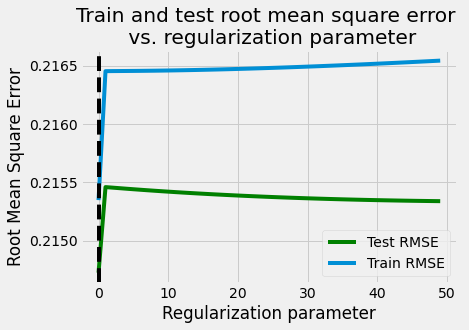

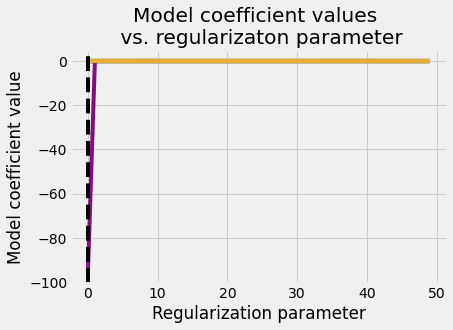

(0, 0.214724527128906)

MSE = 0.046106622550732286
RMSE =0.214724527128906
Mean Absolute Error =0.17058173109194638
Median Absolute Error  = 0.14475723924266637
R^2                    = 0.4515904264477203


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning:

Ill-conditioned matrix (rcond=3.26216e-17): result may not be accurate.



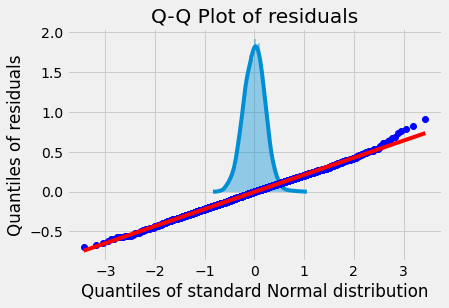

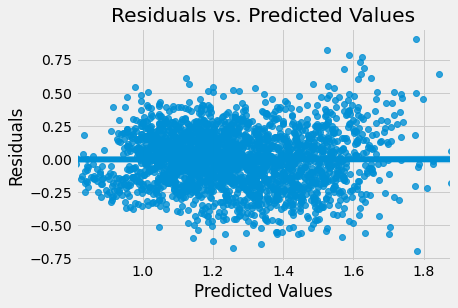

In [148]:
ridge(X_train[predictors],y_train,X_test[predictors],y_test)

##### Lasso Regression

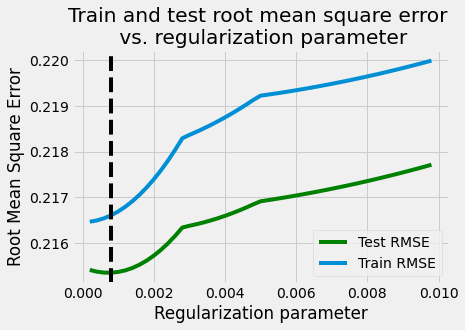

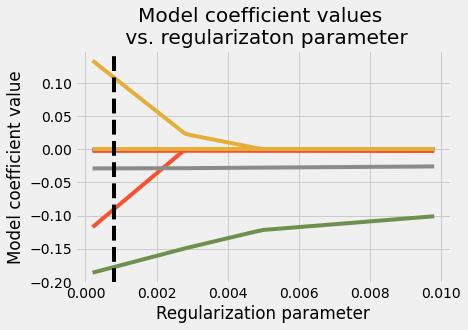

(0.0008, 0.21534732574447943)

MSE = 0.04637447070529894
RMSE =0.21534732574447943
Mean Absolute Error =0.17087664783461465
Median Absolute Error  = 0.1463411791138387
R^2                    = 0.44840453938646263


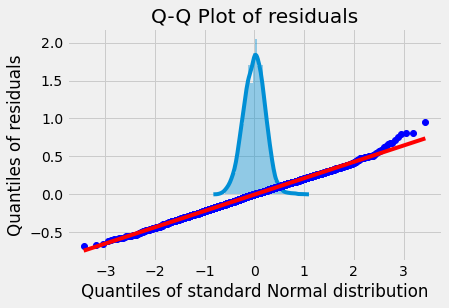

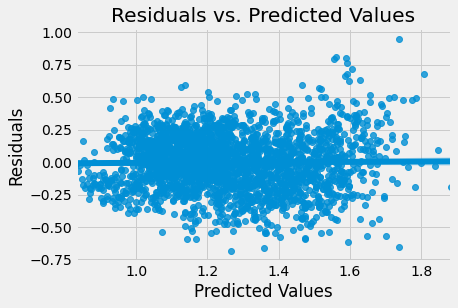

In [149]:
lasso(X_train[predictors],y_train,X_test[predictors],y_test)

In [151]:
models = [
    LinearRegression(),
    Lasso(alpha=0.008),
    Ridge(alpha=1.0),
    RandomForestRegressor(max_depth=2),
]
CV = 5
for model in models:
    model_name = model.__class__.__name__
    
    accuracies = cross_val_score(model,X[predictors], y,scoring=RMSE, cv=CV)
    
    print(model_name,"RMSE",np.sqrt(accuracies),"\n")
    print("average RMSE :", np.sqrt(accuracies).mean(),"\n","\n")

LinearRegression RMSE [0.23254874 0.23921699 0.22731851 0.22662792 0.35888154] 

average RMSE : 0.25691874212147575 
 

Lasso RMSE [0.24250605 0.22246162 0.23097633 0.23652245 0.22269063] 

average RMSE : 0.23103141524540324 
 

Ridge RMSE [0.23454083 0.22509922 0.23005836 0.23010584 0.2357758 ] 

average RMSE : 0.23111601199135529 
 

RandomForestRegressor RMSE [0.26671686 0.23956369 0.25509744 0.26236743 0.19142024] 

average RMSE : 0.24303313172348995 
 



-LinearRegression      0.25691874212490495  
-Lasso                 0.24943533679256355  
-Ridge                 0.23111601199135615     
-RandomForestRegressor 0.2435420386323374  

-LB score
-LinearRegression  0.  
-Lasso             0.
-Ridge              0.  
-RandomForestRegressor 0. 

### Predictor Set 7

In [0]:
predictors=['T2M_rolling', 'year', 'year^2', 'doy', 'doy^2','E12000001', 'E12000002', 'E12000003', 'E12000004','E12000005', 'E12000006', 'E12000007', 'E12000008']

#### Regularized Linear Regression without CV

##### Ridge Regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning:

Ill-conditioned matrix (rcond=3.54111e-17): result may not be accurate.



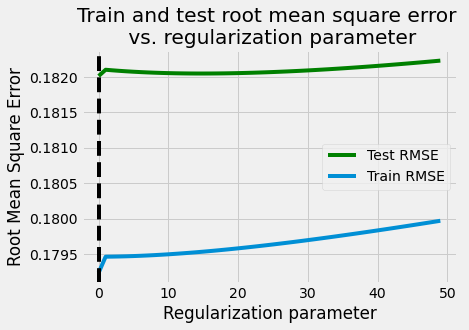

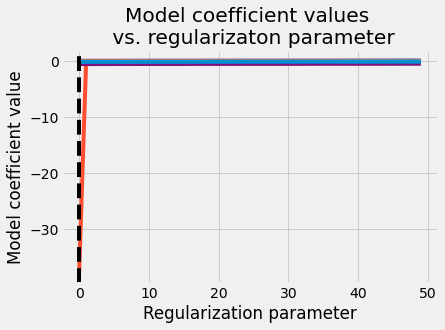

(0, 0.182015815878412)

MSE = 0.033129757229883976
RMSE =0.182015815878412
Mean Absolute Error =0.14063951177544512
Median Absolute Error  = 0.11430724814615667
R^2                    = 0.6059421612515692


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning:

Ill-conditioned matrix (rcond=3.54111e-17): result may not be accurate.



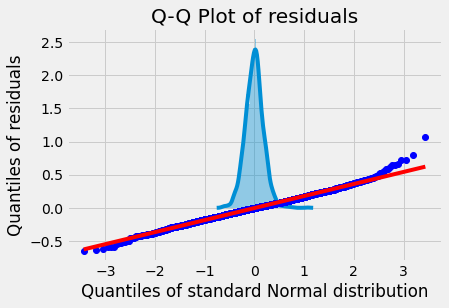

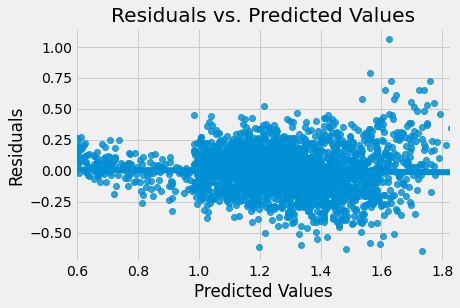

In [153]:
ridge(X_train[predictors],y_train,X_test[predictors],y_test)

##### Lasso Regression

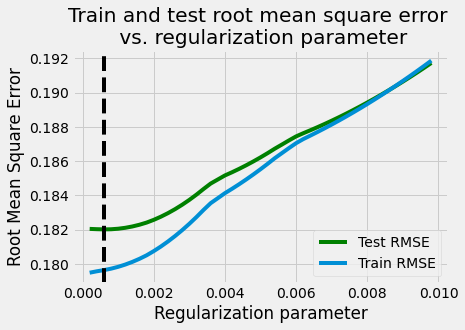

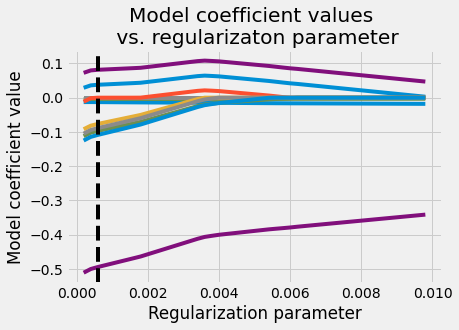

(0.0006, 0.18201555941819234)

MSE = 0.03312966387031751
RMSE =0.18201555941819234
Mean Absolute Error =0.14072824528189753
Median Absolute Error  = 0.11183665607109794
R^2                    = 0.6059432717054953


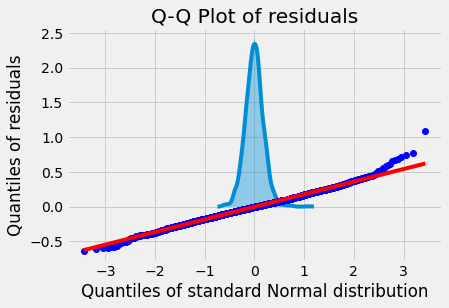

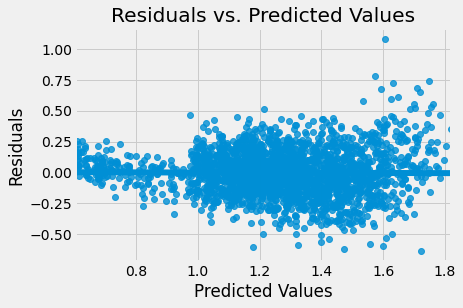

In [154]:
lasso(X_train[predictors],y_train,X_test[predictors],y_test)

In [155]:
models = [
    LinearRegression(),
    Lasso(alpha=0.006),
    Ridge(alpha=1.0),
    RandomForestRegressor(max_depth=2, random_state=0),
]
CV = 5
for model in models:
    model_name = model.__class__.__name__
    
    accuracies = cross_val_score(model,X[predictors], y,scoring=RMSE, cv=CV)
    
    print(model_name,"RMSE",np.sqrt(accuracies),"\n")
    print("average RMSE :", np.sqrt(accuracies).mean(),"\n","\n")

LinearRegression RMSE [0.20415681 0.18456036 0.17517828 0.16492889 0.24821156] 

average RMSE : 0.19540717885988548 
 

Lasso RMSE [0.21026374 0.19406697 0.18058726 0.1820534  0.20290798] 

average RMSE : 0.19397586988636187 
 

Ridge RMSE [0.2017823  0.18332612 0.17372941 0.16563076 0.19561269] 

average RMSE : 0.18401625729827084 
 

RandomForestRegressor RMSE [0.24741372 0.22554667 0.19961574 0.21522269 0.19597469] 

average RMSE : 0.2167547019932517 
 



### Best Predictors

In [0]:
predictors1=['NO2_log', 'year', 'year^2', 'doy', 'doy^2','PM10_log']
predictors2=['T2M_rolling', 'year', 'year^2', 'doy', 'doy^2','E12000001', 'E12000002', 'E12000003', 'E12000004','E12000005', 'E12000006', 'E12000007', 'E12000008']
predictors3=['E12000001', 'E12000002', 'E12000003', 'E12000004','E12000005', 'E12000006', 'E12000007', 'E12000008']

In [157]:
pred = [
    predictors1,
    predictors2,
    predictors3,
]
for preds in pred:
    #model_name = model.__class__.__name__
    
    accuracies = cross_val_score(LinearRegression(),X[preds], y,scoring=RMSE, cv=CV)
    
    print(model_name,"RMSE",np.sqrt(accuracies),"\n")
    print("average RMSE :", np.sqrt(accuracies).mean(),"\n","\n")

RandomForestRegressor RMSE [0.23201375 0.26048128 0.22666889 0.25644528 0.42542438] 

average RMSE : 0.28020671587939494 
 

RandomForestRegressor RMSE [0.20415681 0.18456036 0.17517828 0.16492889 0.24821156] 

average RMSE : 0.19540717885988548 
 

RandomForestRegressor RMSE [0.28887085 0.26111306 0.24310381 0.22983521 0.22967401] 

average RMSE : 0.25051938878501434 
 



### Final Algo - mixed LR


Notation:
X0 - training predictors
y0 - training target
X1 - test predictors
y1 - predictions


In [0]:
a = LinearRegression()
b = LinearRegression()
c = LinearRegression()
ab = LinearRegression()

In [0]:

y0 = train_f['mortality_rate']



#modela
a_predictors = ['NO2_log', 'year', 'year^2', 'doy', 'doy^2','PM10_log']
a_X0 = train_f[a_predictors]
a.fit(a_X0, y0)



#modelb
b_predictors = [
        'T2M_rolling', 'year', 'year^2', 'doy', 'doy^2',
        'E12000001', 'E12000002', 'E12000003', 'E12000004',
        'E12000005', 'E12000006', 'E12000007', 'E12000008'
        ]
b_X0 = train_f[b_predictors]
b.fit(b_X0, y0)



#modelc
c_predictors = [
        'E12000001', 'E12000002', 'E12000003', 'E12000004',
        'E12000005', 'E12000006', 'E12000007', 'E12000008'
        ]
c_X0 = train_f[c_predictors]
c.fit(c_X0, y0)


region_effect_reduction = 0.85


# Model AB
# Produces the final solution. Combines A and "reduced B" by using their predictions as features for a linear regression.

ab_X0 = pd.DataFrame({
    'A': a.predict(a_X0),
    'reduced B': b.predict(b_X0) - (c.predict(c_X0) * region_effect_reduction)
    })

ab.fit(ab_X0, y0)

# predict

a_X1 = test_f[a_predictors]
b_X1 = test_f[b_predictors]
c_X1 = test_f[c_predictors]

ab_X1 = pd.DataFrame({'A': a.predict(a_X1),'reduced B': b.predict(b_X1) - (c.predict(c_X1) * region_effect_reduction)})

ab_y1 = ab.predict(ab_X1)



predictions = pd.DataFrame(index=test_f.index)
#predictions['mortality_rate'] =  a.predict(a_X1)
predictions['mortality_rate'] = ab_y1
predictions.to_csv('final_0.0.csv')


# Results
best LB socre for -(region_effect_reduction = 0.85)<br>
private score - 0.28948<br>
public score - 0.28784<br>


benchmark -<br>
private score - 0.29022<br>
public socre - 0.29259<br>